In [1]:
library(mice)
library(finalfit)
library(ggplot2)
library(dplyr)
library(stats)
library(miceadds)
library(missMethods)
library(smotefamily)
library(caret)
library(cowplot)
library(mlr)
library(fastDummies)
library(DMwR2)
library(mlmi)
library(ranger)
library(scales)
library(Hmisc)
library(mlbench)

Warning message:
"pakiet 'mice' został zbudowany w wersji R 4.3.2"

Dołączanie pakietu: 'mice'


Następujący obiekt został zakryty z 'package:stats':

    filter


Następujące obiekty zostały zakryte z 'package:base':

    cbind, rbind


Warning message:
"pakiet 'ggplot2' został zbudowany w wersji R 4.3.3"

Dołączanie pakietu: 'dplyr'


Następujące obiekty zostały zakryte z 'package:stats':

    filter, lag


Następujące obiekty zostały zakryte z 'package:base':

    intersect, setdiff, setequal, union


* miceadds 3.16-18 (2023-01-06 10:54:00)

Ładowanie wymaganego pakietu: lattice

Warning message:
"pakiet 'cowplot' został zbudowany w wersji R 4.3.2"
Warning message:
"pakiet 'mlr' został zbudowany w wersji R 4.3.2"
Ładowanie wymaganego pakietu: ParamHelpers

Warning message:
"pakiet 'ParamHelpers' został zbudowany w wersji R 4.3.2"
Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to t

In [2]:
visImpCont <- function(orig_train, orig_test, imp_train, imp_test, miss_var, imp_type) {
    #' Visualize imputation of missing data for continuous variable.

    orig_data <- rbind(orig_train, orig_test)
    orig_data <- orig_data[order(orig_data$index),]
    imp_data <- rbind(imp_train, imp_test)
    imp_data <- imp_data[order(imp_data$index),]

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    ggplot(data = imp_data, aes(x = index, y = !!as.name(miss_var), color = imputed)) +
        geom_point(data = subset(imp_data, imputed == "Observed"), size = 3, alpha = 0.8) +
        geom_point(data = subset(imp_data, imputed == "Imputed"), size = 3) +
        scale_color_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18))
}

In [3]:
visImpCat <- function(orig_train, orig_test, imp_train, imp_test, miss_var, imp_type) {
    #' Visualize imputation of missing data for categorical variable.

    orig_data <- rbind(orig_train, orig_test)
    orig_data <- orig_data[order(orig_data$index),]
    imp_data <- rbind(imp_train, imp_test)
    imp_data <- imp_data[order(imp_data$index),]

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    ggplot(data = imp_data, aes(x = !!as.name(miss_var), fill = imputed)) +
        geom_bar() +
        scale_fill_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18))
}

In [4]:
visImpMul <- function(orig_train, orig_test, imp_train, imp_test, miss_var, imp_type) {
    #' Visualize imputation of missing data for continuous variable (multiple imputation).

    orig_data <- rbind(orig_train, orig_test)
    orig_data <- orig_data[order(orig_data$index),]
    imp_data <- rbind(imp_train, imp_test)
    imp_data <- imp_data[order(imp_data$index),]

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    p <- ggplot(data = imp_data, aes(x = index, y = !!as.name(miss_var), color = imputed)) +
        geom_point(data = subset(imp_data, imputed == "Observed"), size = 3, alpha = 0.8) +
        geom_point(data = subset(imp_data, imputed == "Imputed"), size = 3) +
        scale_color_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18),
            strip.text = element_text(size = 18))

    p + facet_wrap(~ .imp, ncol = 2, scales="free")
}

In [5]:
visImpMulCat <- function(orig_train, orig_test, imp_train, imp_test, miss_var, imp_type) {
    #' Visualize imputation of missing data for continuous variable (multiple imputation).

    orig_data <- rbind(orig_train, orig_test)
    orig_data <- orig_data[order(orig_data$index),]
    imp_data <- rbind(imp_train, imp_test)
    imp_data <- imp_data[order(imp_data$index),]

    miss_ind <- which(is.na(orig_data[[miss_var]]))
    imp_data$imputed <- "Observed"
    imp_data$imputed[miss_ind] <- "Imputed"

    p<- ggplot(data = imp_data, aes(x = !!as.name(miss_var), fill = imputed)) +
        geom_bar() +
        scale_fill_manual(values = c("steelblue1", "royalblue4")) +
        ggtitle(paste(miss_var, imp_type, "imputation")) +
        theme(
            plot.title = element_text(size = 26),
            axis.title = element_text(size = 22),         
            axis.text.x = element_text(size = 18),        
            axis.text.y = element_text(size = 18),
            legend.text = element_text(size = 16),        
            legend.title = element_text(size = 18),
            strip.text = element_text(size = 18))

    p + facet_wrap(~ .imp, ncol = 2, scales="free")
}

In [6]:
newblots <- function(old_blots, param_list){
    #' Create new blots for narfcs imputation.
    
    new_blots <- old_blots
    for (i in names(new_blots)) {
        par <- param_list[[i]]
        ums <- new_blots[[i]][["ums"]]
        for (j in 1:length(par)){
            ind <- regexpr("\\$", ums)[1]
            if (par[[j]] >= 0){
                part1 <- substr(ums, 1, ind-1)
                part2 <- substr(ums, ind+1, nchar(new_blots[[i]][["ums"]]))
            }
            else{
                part1 <- substr(ums, 1, ind-2)
                part2 <- substr(ums, ind+1, nchar(new_blots[[i]][["ums"]]))
            }
            ums <- paste0(part1, as.character(par[[j]]), part2)
            new_blots[[i]][["ums"]] <- ums
            }
    }
    new_blots
}

In [7]:
CSPalg2 <- function(data, base_blots, elicited, l, u, MSPmodels, MSPfamily, step, tol, parms, m, maxit, method, seed, predmat){
    #' Algorithm 2 for finding CSPs.
    
    MSP <- as.list(NULL)
    range <- as.list(NULL)

    for (i in 1:length(l)){
    range[[i]] <- vector("list", length(l[[i]]))
        for (j in 1:length(l[[i]])){
            range[[i]][[j]] <- seq(l[[i]][[j]], u[[i]][[j]], step[[i]][[j]])
        }
    }

    range2 <- list()
    counter <- 0
    for (i in 1:length(range)){
        for (j in 1:length(range[[i]])){
            counter <- counter + 1
            range2[[counter]] <- range[[i]][[j]]
        }
    }
    
    points <- expand.grid(range2)

    for(j in 1:nrow(points)){
        parmsnew <- relist(as.matrix(points[j,]), parms)
        for (k in 1:length(parmsnew)){
            for (l in 1:length(i)) {
                parmsnew[[k]][[l]] <- round(parmsnew[[k]][[l]], 4)
            }
        }
        imp_blots <- newblots(base_blots, parmsnew)
        set.seed(seed)
        narfcs <- mice(data=data, m=m, maxit=maxit, method=method, blots=imp_blots, print=FALSE, predictorMatrix=predmat)
        MSPlist <- c()
        for(n in 1:length(MSPmodels)){
            MSPlm <- with(data=narfcs, exp=glm(formula=as.formula(MSPmodels[n]), family=MSPfamily[n]))
            pooled <- summary(pool(MSPlm))$estimate
            estim <- pooled[2:length(pooled)]
            MSPlist <- c(MSPlist, estim)
            }
        MSP[[j]] <- MSPlist
    }
    
    dif <- as.vector(NULL)
    for(p in 1:nrow(points)){
        dif[[p]] <- tol-abs(MSP[[p]]-elicited)
    }

    Msps <- do.call(rbind, MSP)
    colnames(Msps) <- rep("c",ncol(Msps))
    for(i in 1:ncol(Msps)){ 
        colnames(Msps)[i] <- paste("MSP", i)
    }


    colnames(points) <- rep("c", ncol(points))
    for(i in 1:ncol(points)){ 
     colnames(points)[i] <- paste("CSP", i)
    }
    Csps <- points

    con <- lapply(dif, function(x) all(x>0))
    MSPcal <- MSP[c(which(con==TRUE))]
    CSPcal <- as.data.frame(points[c(which(con==TRUE)),])

    if (nrow(CSPcal) == 0){
        return(list(calibratedMSP=NA, calibratedCSP=NA, Csps=Csps, Msps=Msps))
    }

    else{
        calibratedMSP <- do.call(rbind, MSPcal)
        colnames(calibratedMSP) <- rep("c",ncol(calibratedMSP))
        for(i in 1:ncol(calibratedMSP)){ 
            colnames(calibratedMSP)[i] <- paste("MSP", i)
        }

        colnames(CSPcal) <- rep("c",ncol(CSPcal))
        for(i in 1:ncol(CSPcal)){ 
        colnames(CSPcal)[i] <- paste("CSP",i)
        }

        return(list(calibratedMSP=calibratedMSP, calibratedCSP=CSPcal, Csps=Csps, Msps=Msps))
    }
}

In [8]:
find_CSP <- function(data, base_blots, elicited, l, u, MSPmodels, MSPfamily, step, tol, parms, m, maxit, method, seed, predmat) {
    #' Run Algorithm 2 repeatedly to find CSPs.
    
    found <- FALSE
    counter <- 0

    while (!found) {
        calib <- CSPalg2(data, base_blots, elicited, l, u, MSPmodels, MSPfamily, step, tol, parms, m, maxit, method, seed, predmat)

        if (typeof(calib$calibratedMSP) != "logical") {
            diff <- abs(calib$calibratedMSP - elicited)
            csps <- rep(0, ncol(diff))
            for (i in 1:ncol(diff)) {
                ind <- which(diff[, i] == min(diff[, i]))[1]
                csps[i] <- calib$calibratedMSP[ind, i]
            }
            found <- TRUE
        }

        else {
            diff <- abs(calib$Msps - elicited)
            for (i in 1:ncol(diff)) {
                rng_len <- (u[[i]] - l[[i]]) / step[[i]]
                step[[i]] <- 0.9 * step[[i]]
                ind <- which(diff[, i] == min(diff[, i]))[1]
                mid <- calib$Csps[ind, i]
                newl <- mid - step[[i]] * (rng_len / 2)
                newu <- mid + step[[i]] * (rng_len / 2)
                l[[i]] <- newl
                u[[i]] <- newu
            counter <- counter + 1
            if (counter > 10) {
                csps <- elicited
                found <- TRUE
            }
            }
        }
    }

    return(csps)
}

In [9]:
create_zero_df <- function(num_rows, num_cols, colnames) {
  #' Create dataframe of zeros.
  
  df <- as.data.frame(matrix(0, nrow = num_rows, ncol = num_cols))
  names(df) <- colnames
  return(df)
}

In [10]:
create_data <- function(nrows, mechanism, categorical=FALSE, sd=1, prob1=0.6, prob2=0.2) {
    #' Create synthetic data for classification.

    null_data <- mlbench.2dnormals(n = nrows, cl = 2, sd = sd)
    vars <- as.data.frame(null_data$x)
    classes <- null_data$class
    V3 <- rep(0, nrow(vars))
    indclass1 <- which(classes=="1")
    indclass2 <- which(classes=="2")
    ind1class1 <- sample(indclass1, size = length(indclass1) * prob1, replace = FALSE)
    ind1class2 <- sample(indclass2, size = length(indclass2) * prob2, replace = FALSE)
    V3[ind1class1] <- 1
    V3[ind1class2] <- 1
    V3 <- as.factor(V3)
    data <- data.frame(x=vars$V1, y=vars$V2, z=V3, class=classes)
    data$class <- as.factor(ifelse(data$class == "2", "1", "0"))
    miscol <- ifelse(categorical==FALSE, 1, 3)

    if (mechanism == "MCAR") {
        miss_data <- delete_MCAR(ds=data, p=round(runif(n=1, min=0.5, max=0.55), 2), cols_mis=c(miscol), n_mis_stochastic=FALSE)
        miss_data$index <- as.numeric(row.names(miss_data))
        return(list(md=miss_data, dt=NULL))
    }

    else if (mechanism == "MAR") {
        miss_data <- delete_MAR_censoring(ds=data, p=round(runif(n=1, min=0.5, max=0.55), 2), cols_mis=c(miscol), cols_ctrl=c(2))
        miss_data$index <- as.numeric(row.names(miss_data))
        return(list(md=miss_data, dt=NULL))
    }

    else {
        miss_data <- delete_MNAR_censoring(ds=data, p=round(runif(n=1, min=0.5, max=0.55), 2), cols_mis=c(miscol))
        if (categorical==FALSE){
            x_obs <- mean(data[!is.na(miss_data$x),]$x)
            x_miss <- mean(data[is.na(miss_data$x),]$x)
            x_delta <- x_miss - x_obs
            miss_data$index <- as.numeric(row.names(miss_data))
            return(list(md=miss_data, dt=x_delta))
        }
        else {
            z_mi <- as.factor(ifelse(is.na(miss_data$z), "Missing", "Observed"))
            z_tab <- table(data.frame(miss = z_mi, z = data$z))
            z_miss <- z_tab["Missing", "1"] / z_tab["Missing", "0"]
            z_obs <- z_tab["Observed", "1"] / z_tab["Observed", "0"]
            z_delta <- z_miss - z_obs
            miss_data$index <- as.numeric(row.names(miss_data))
            return(list(md=miss_data, dt=z_delta))
        }
    }
}

In [11]:
num1 <- create_data(1000, "MCAR", FALSE)$md
num2 <- create_data(1000, "MAR", FALSE)$md
mnar_num <- create_data(1000, "MNAR", FALSE)
num3 <- mnar_num$md
delta_num <- mnar_num$dt

cat1 <- create_data(1000, "MCAR", TRUE)$md
cat2 <- create_data(1000, "MAR", TRUE)$md
mnar_cat <- create_data(1000, "MNAR", TRUE)
cat3 <- mnar_cat$md
delta_cat <- mnar_cat$dt

In [12]:
predm <- make.predictorMatrix(num1)
predm[,"index"] <- 0

In [13]:
set.seed(1234)
train_ind <- createDataPartition(num1$class, p = 0.75, list = FALSE)

In [14]:
train_num1 <- num1[train_ind,]
test_num1  <- num1[-train_ind,]

train_num2 <- num2[train_ind,]
test_num2  <- num2[-train_ind,]

train_num3 <- num3[train_ind,]
test_num3  <- num3[-train_ind,]

train_cat1 <- cat1[train_ind,]
test_cat1  <- cat1[-train_ind,]

train_cat2 <- cat2[train_ind,]
test_cat2  <- cat2[-train_ind,]

train_cat3 <- cat3[train_ind,]
test_cat3  <- cat3[-train_ind,]

In [26]:
head(num1)

,x,y,z,class,index
,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,NA,2.6807174,1,0,1
2,NA,-0.2879268,1,0,2
3,1.315563,1.1054995,0,0,3
4,NA,0.3201142,0,0,4
5,NA,1.2721533,1,0,5
6,-1.250829,-2.4532029,0,1,6


In [25]:
method1 <- c("mean", "", "", "", "")
train_num1_mean <- mice(data = train_num1, m = 1, maxit = 1, printFlag = FALSE, method = method1, predictorMatrix = predm) %>% complete()
train_num2_mean <- mice(data = train_num2, m = 1, maxit = 1, printFlag = FALSE, method = method1, predictorMatrix = predm) %>% complete()

test_num1_mean <- mice(data = test_num1, m = 1, maxit = 1, printFlag = FALSE, method = method1, predictorMatrix = predm) %>% complete()
test_num2_mean <- mice(data = test_num2, m = 1, maxit = 1, printFlag = FALSE, method = method1, predictorMatrix = predm) %>% complete()

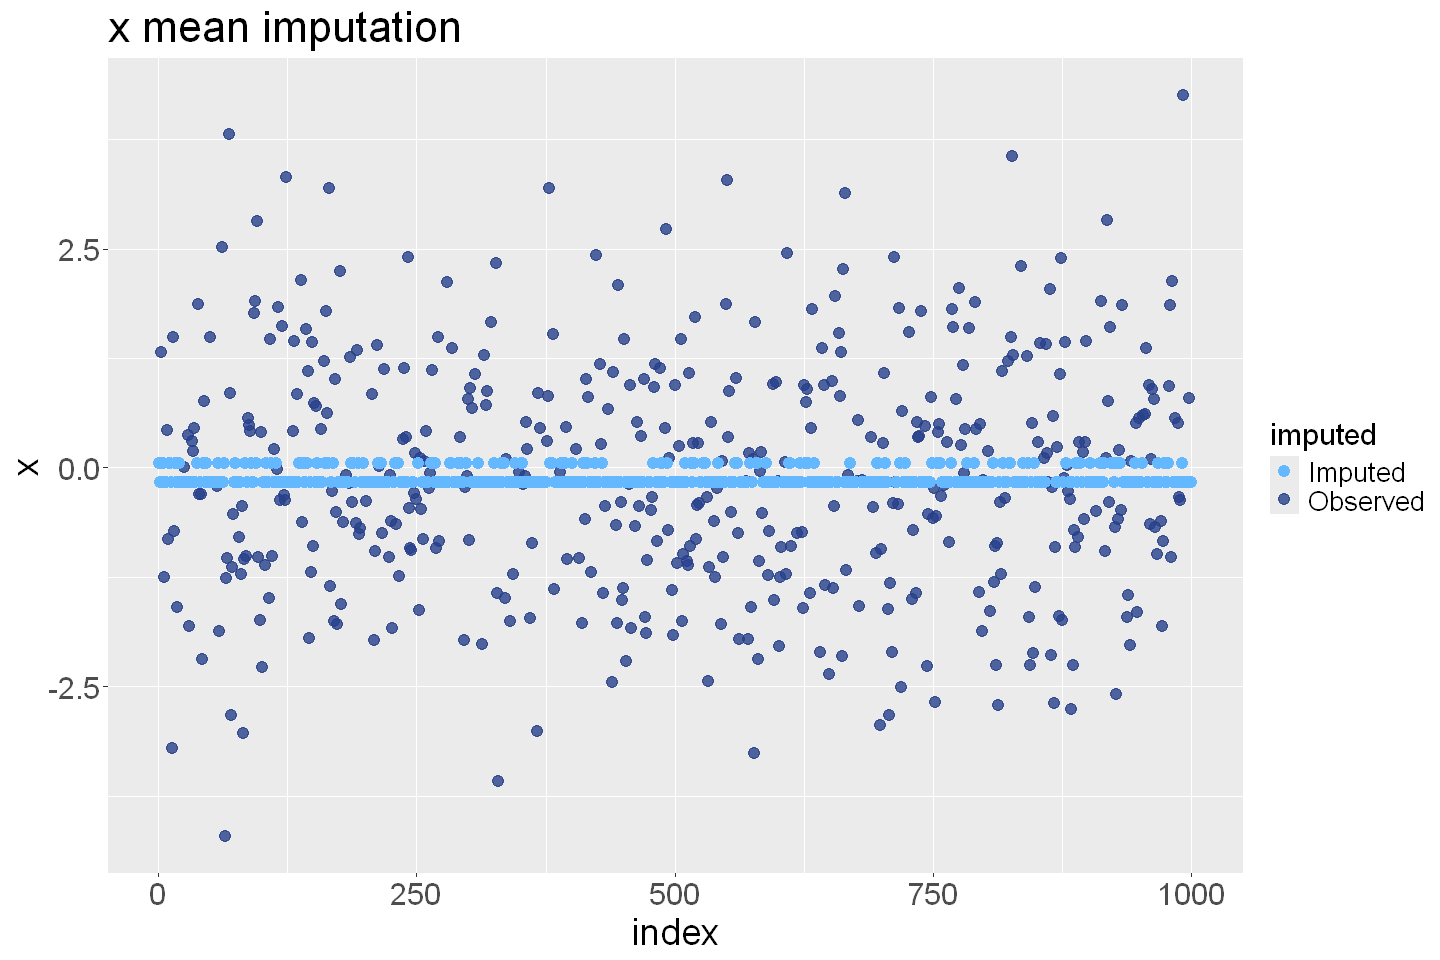

In [27]:
options(repr.plot.width = 12, repr.plot.height = 8)
visImpCont(train_num1, test_num1, train_num1_mean, test_num1_mean, "x", "mean")

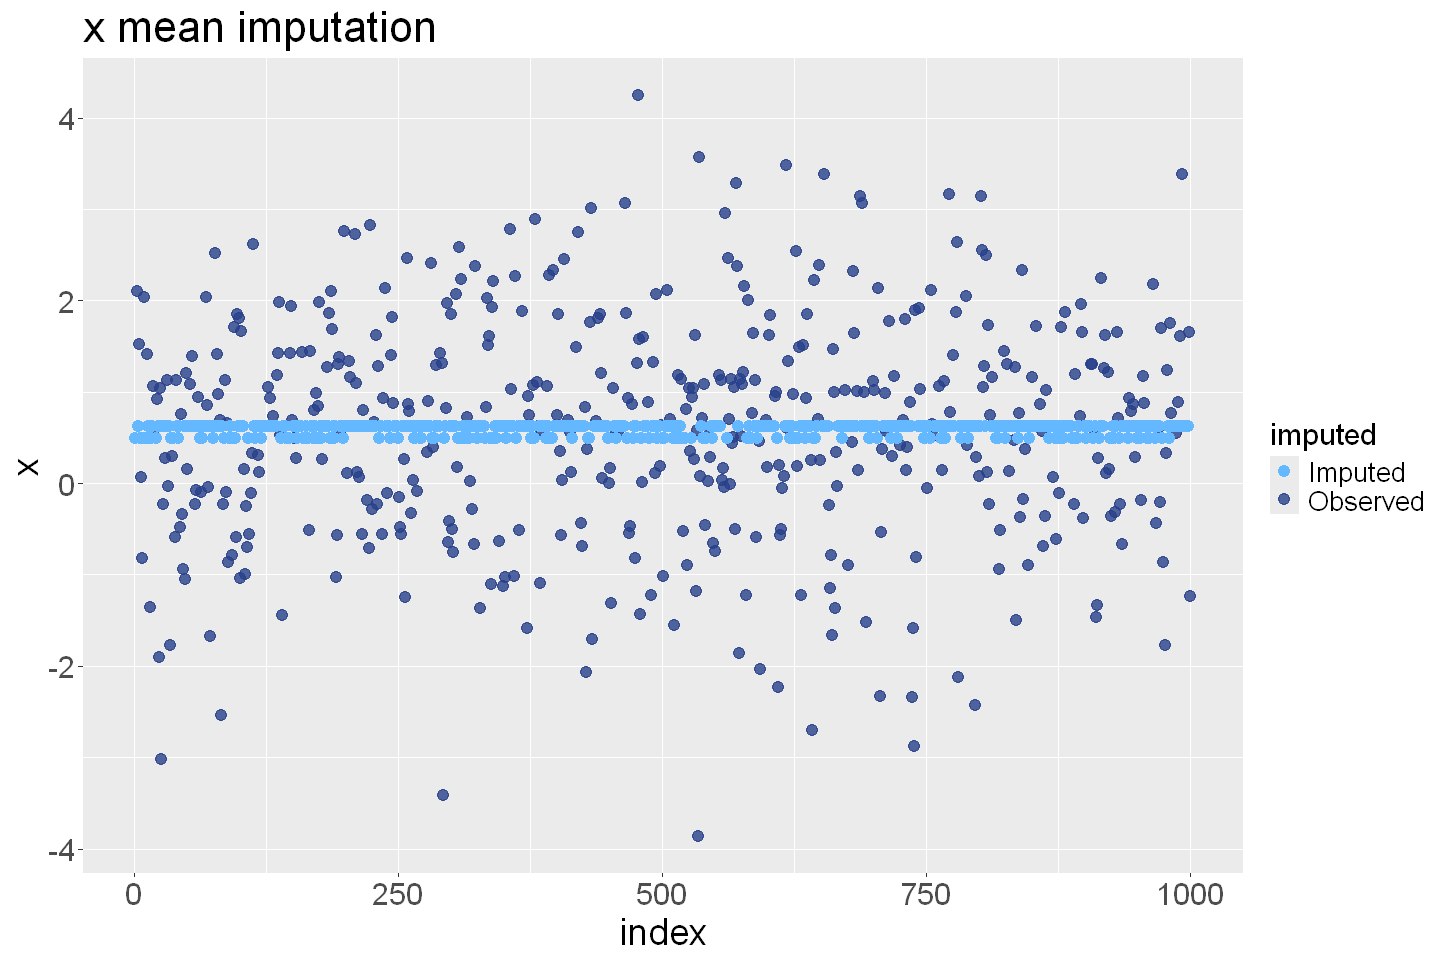

In [28]:
visImpCont(train_num2, test_num2, train_num2_mean, test_num2_mean, "x", "mean")

In [29]:
method2 <- c("norm.predict", "", "", "", "")
train_num1_linreg <- mice(data = train_num1, m = 1, maxit = 1, printFlag = FALSE, method = method2, predictorMatrix = predm) %>% complete()
train_num2_linreg <- mice(data = train_num2, m = 1, maxit = 1, printFlag = FALSE, method = method2, predictorMatrix = predm) %>% complete()

test_num1_linreg <- mice(data = test_num1, m = 1, maxit = 1, printFlag = FALSE, method = method2, predictorMatrix = predm) %>% complete()
test_num2_linreg <- mice(data = test_num2, m = 1, maxit = 1, printFlag = FALSE, method = method2, predictorMatrix = predm) %>% complete()

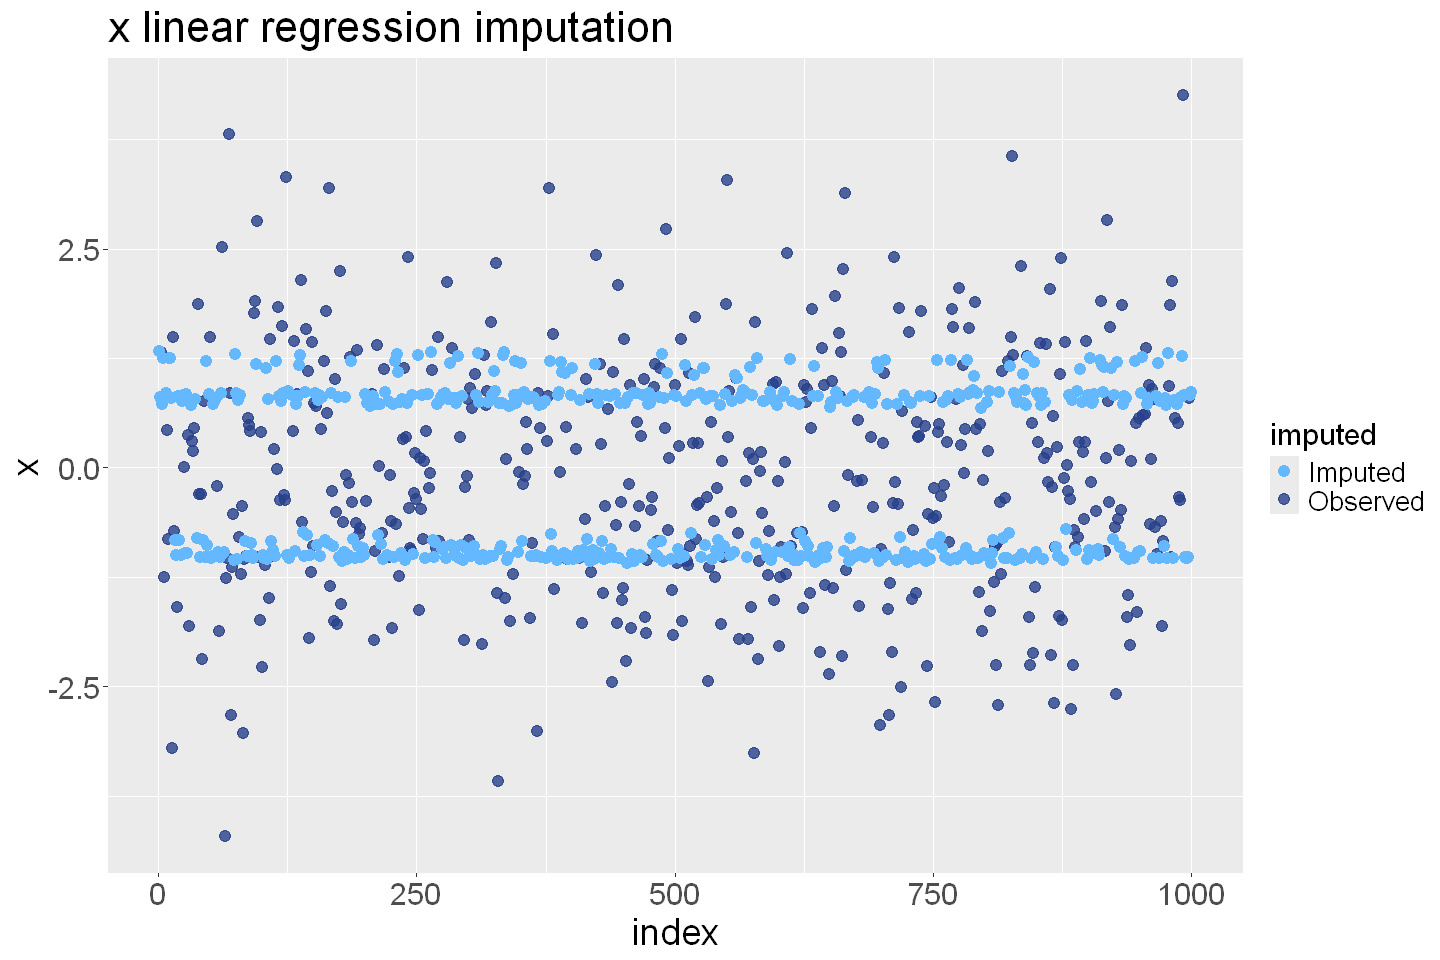

In [30]:
visImpCont(train_num1, test_num1, train_num1_linreg, test_num1_linreg, "x", "linear regression")

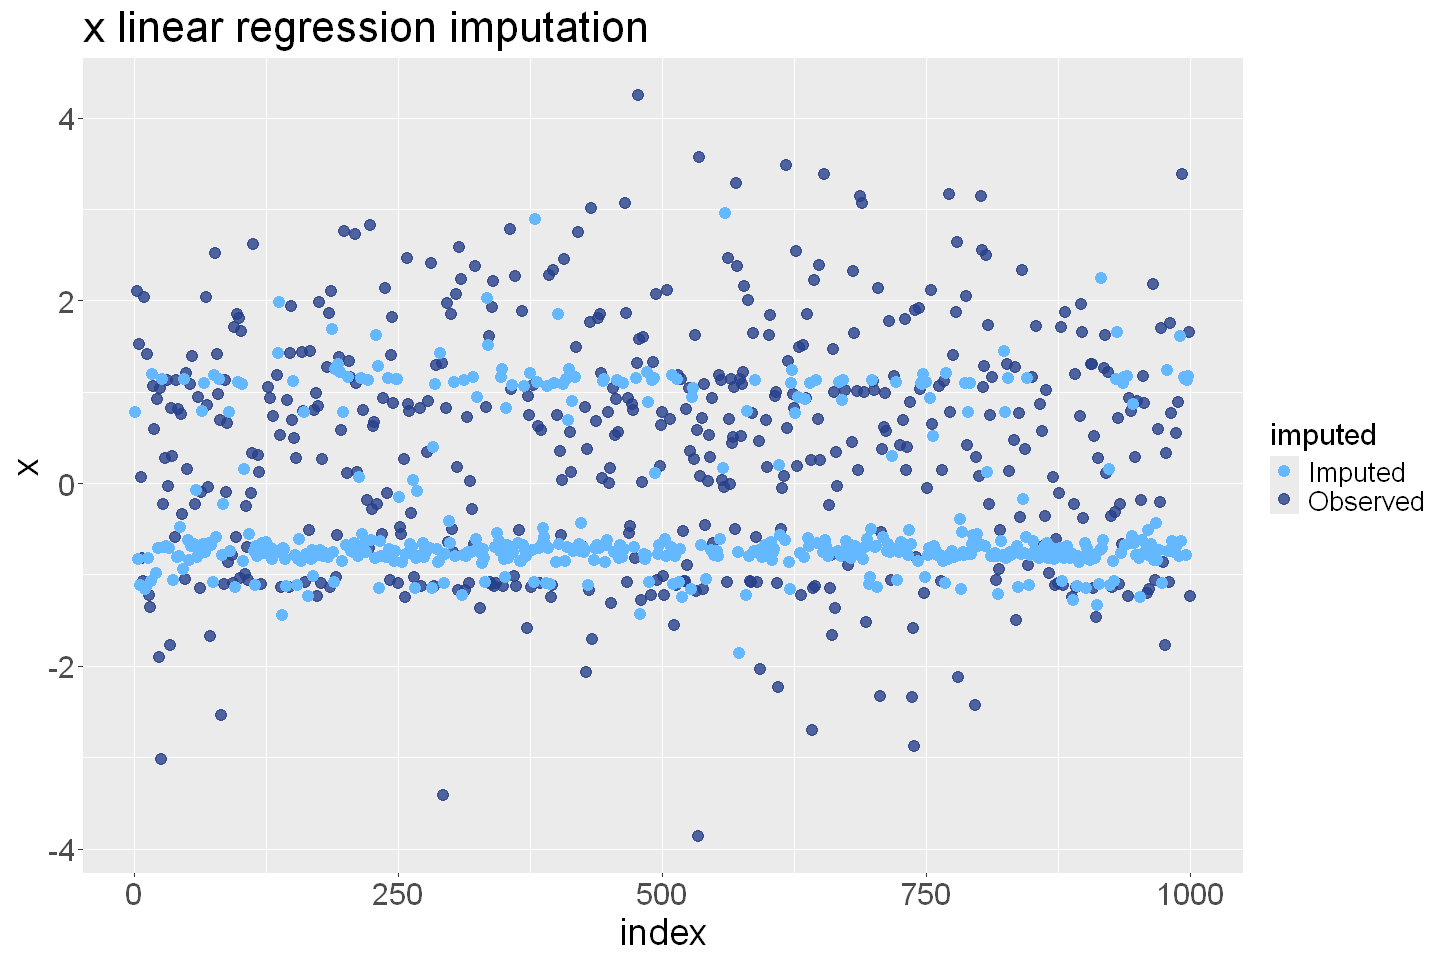

In [31]:
visImpCont(train_num2, test_num1, train_num2_linreg, test_num2_linreg, "x", "linear regression")

In [32]:
method3 <- c("norm.nob", "", "", "", "")
train_num1_stochreg <- mice(data = train_num1, m = 1, maxit = 1, printFlag = FALSE, method = method3, predictorMatrix = predm) %>% complete()
train_num2_stochreg <- mice(data = train_num2, m = 1, maxit = 1, printFlag = FALSE, method = method3, predictorMatrix = predm) %>% complete()

test_num1_stochreg <- mice(data = test_num1, m = 1, maxit = 1, printFlag = FALSE, method = method3, predictorMatrix = predm) %>% complete()
test_num2_stochreg <- mice(data = test_num2, m = 1, maxit = 1, printFlag = FALSE, method = method3, predictorMatrix = predm) %>% complete()

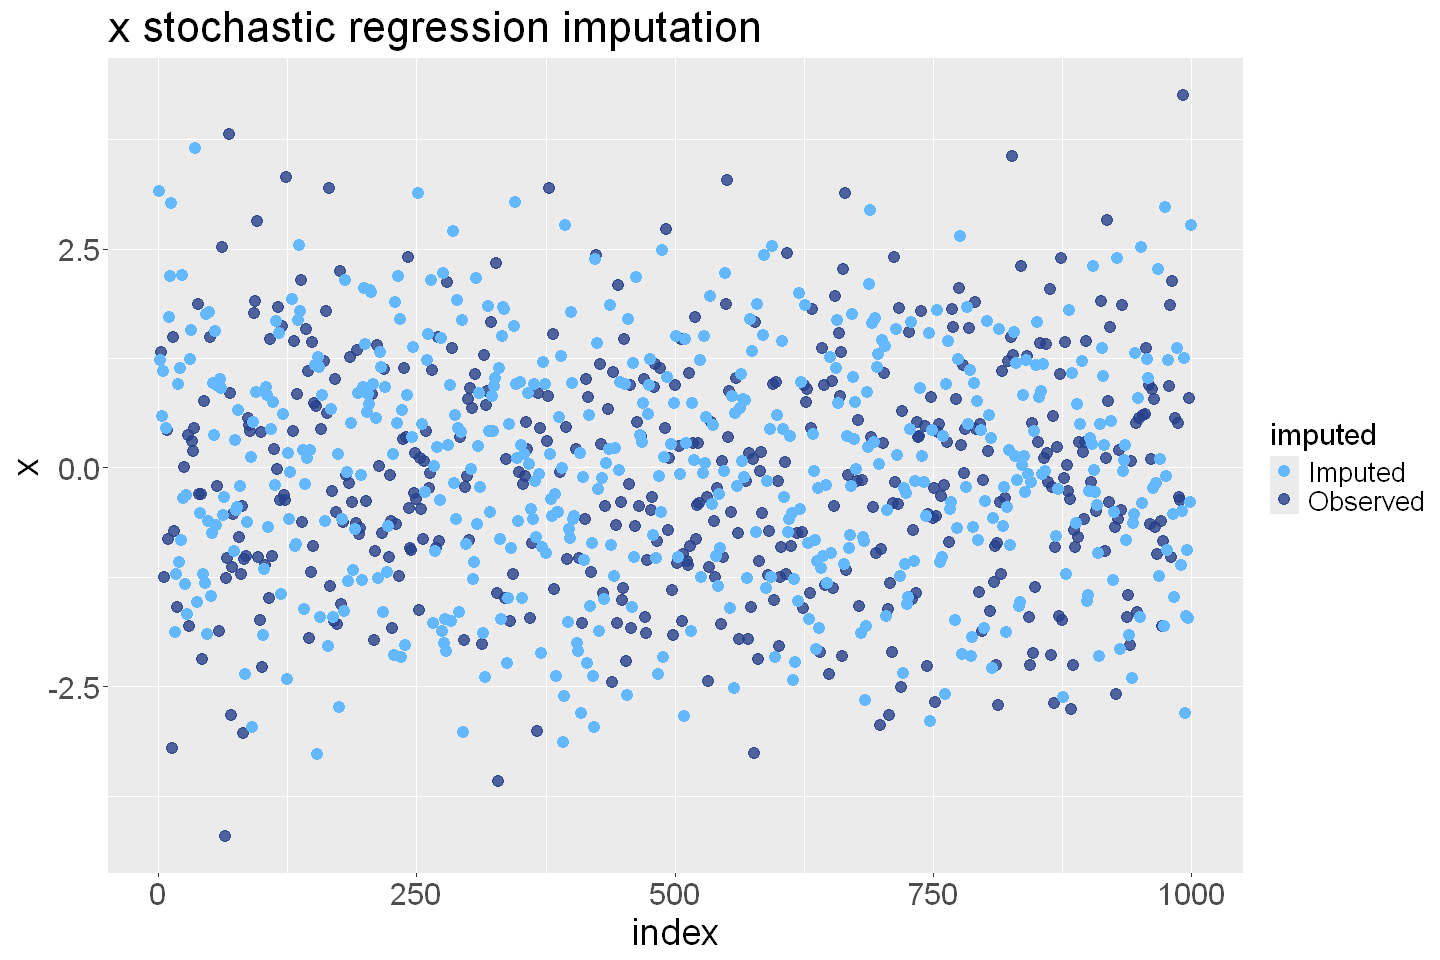

In [33]:
visImpCont(train_num1, test_num1, train_num1_stochreg, test_num1_stochreg, "x", "stochastic regression")

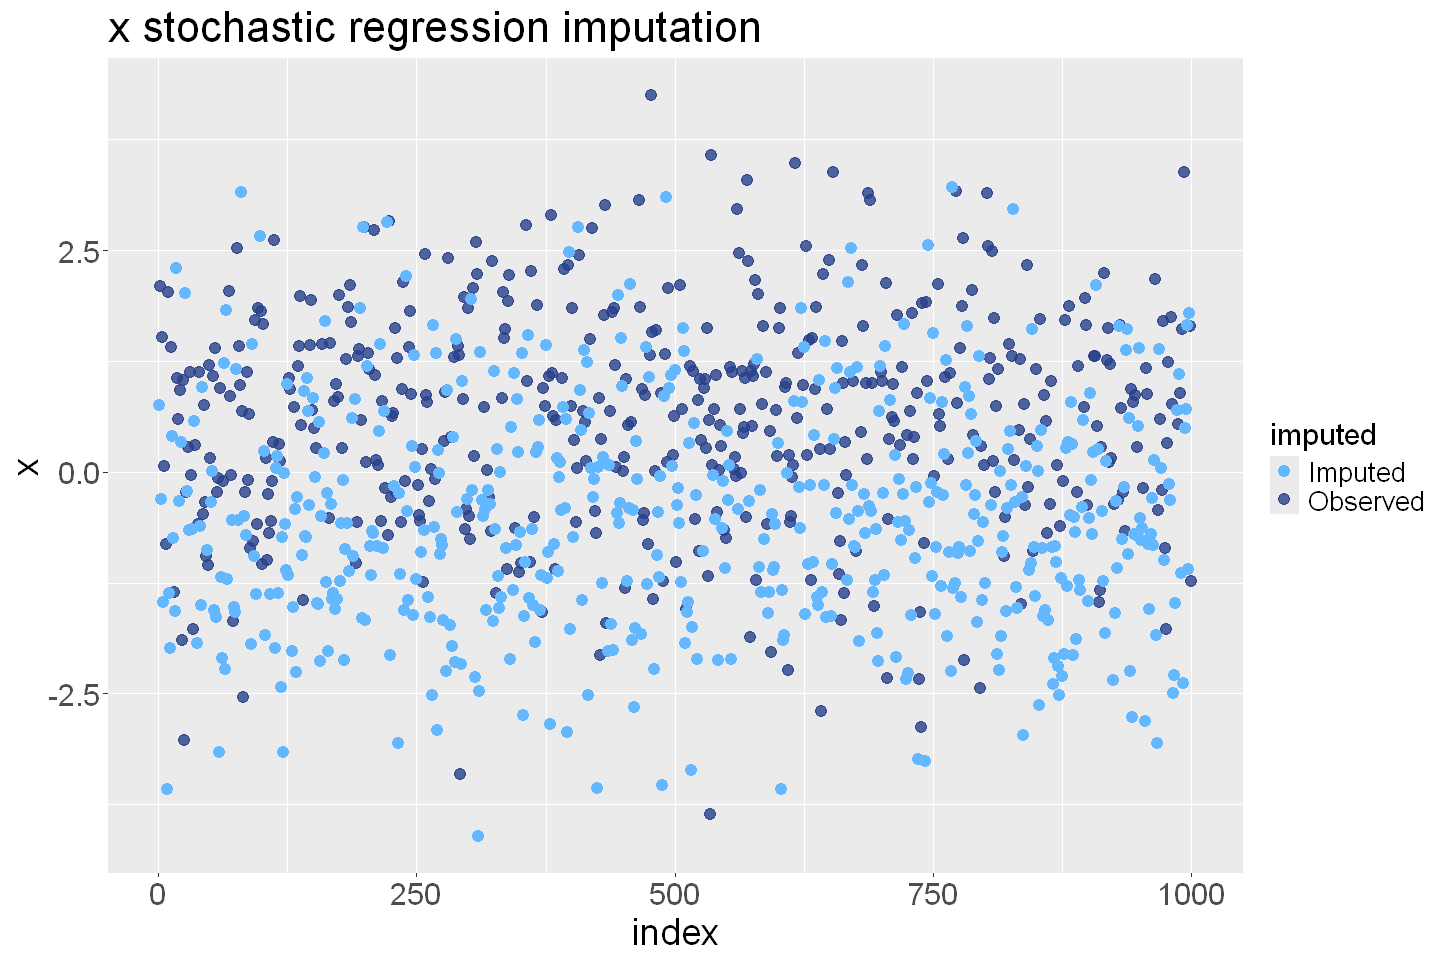

In [34]:
visImpCont(train_num2, test_num2, train_num2_stochreg, test_num2_stochreg, "x", "stochastic regression")

In [35]:
method4 <- c("pmm", "", "", "", "")
train_num1_pmm <- mice(data = train_num1, m = 1, maxit = 1, printFlag = FALSE, method = method4, predictorMatrix = predm) %>% complete()
train_num2_pmm <- mice(data = train_num2, m = 1, maxit = 1, printFlag = FALSE, method = method4, predictorMatrix = predm) %>% complete()

test_num1_pmm <- mice(data = test_num1, m = 1, maxit = 1, printFlag = FALSE, method = method4, predictorMatrix = predm) %>% complete()
test_num2_pmm <- mice(data = test_num2, m = 1, maxit = 1, printFlag = FALSE, method = method4, predictorMatrix = predm) %>% complete()

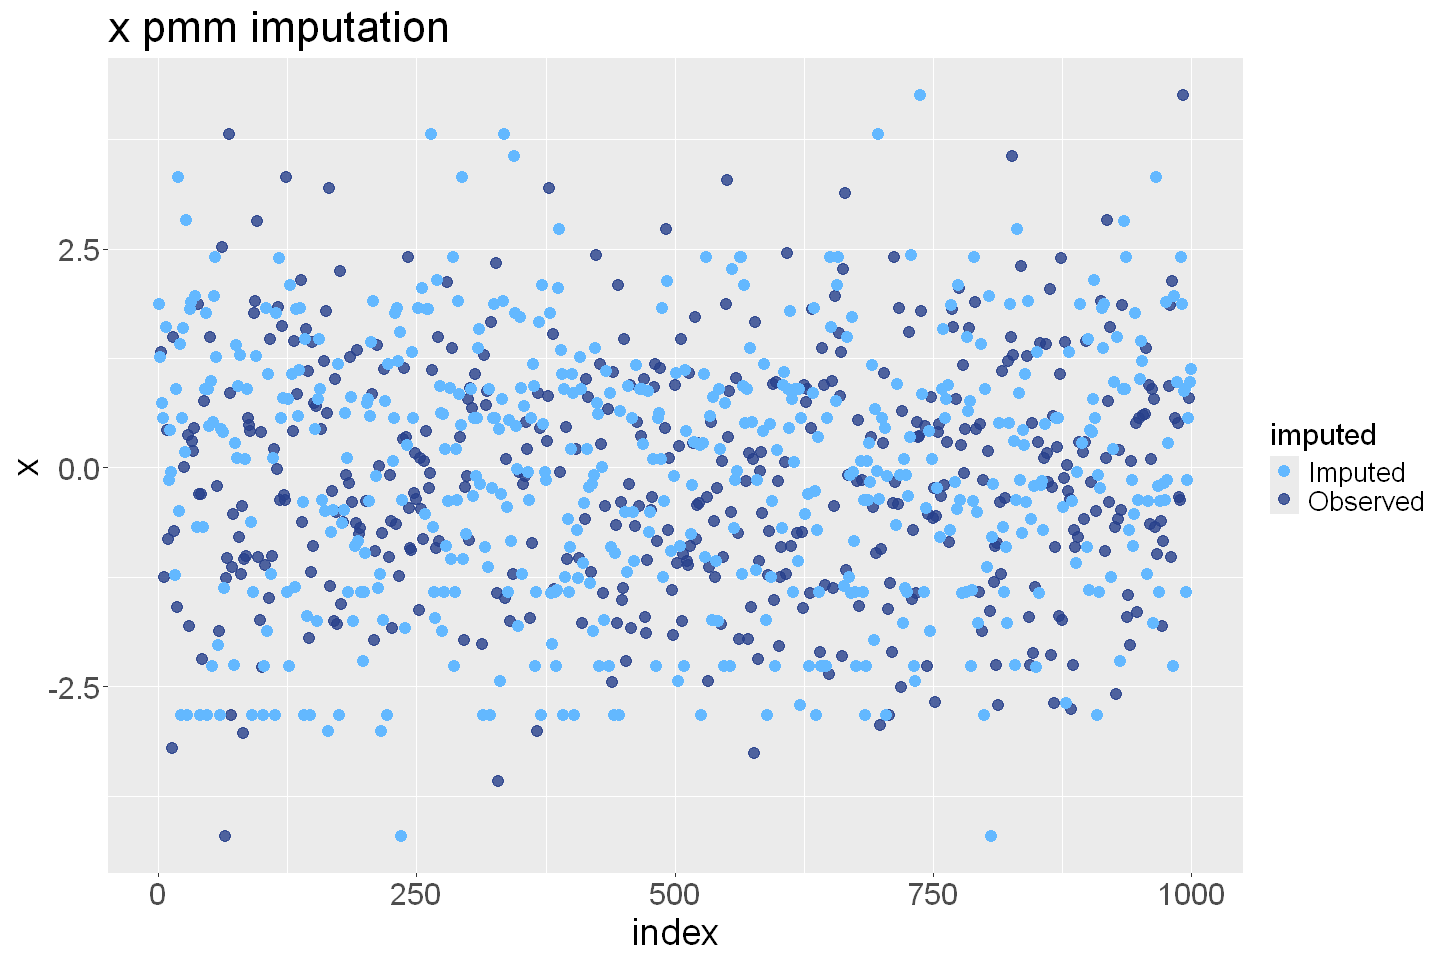

In [36]:
visImpCont(train_num1, test_num1, train_num1_pmm, test_num1_pmm, "x", "pmm")

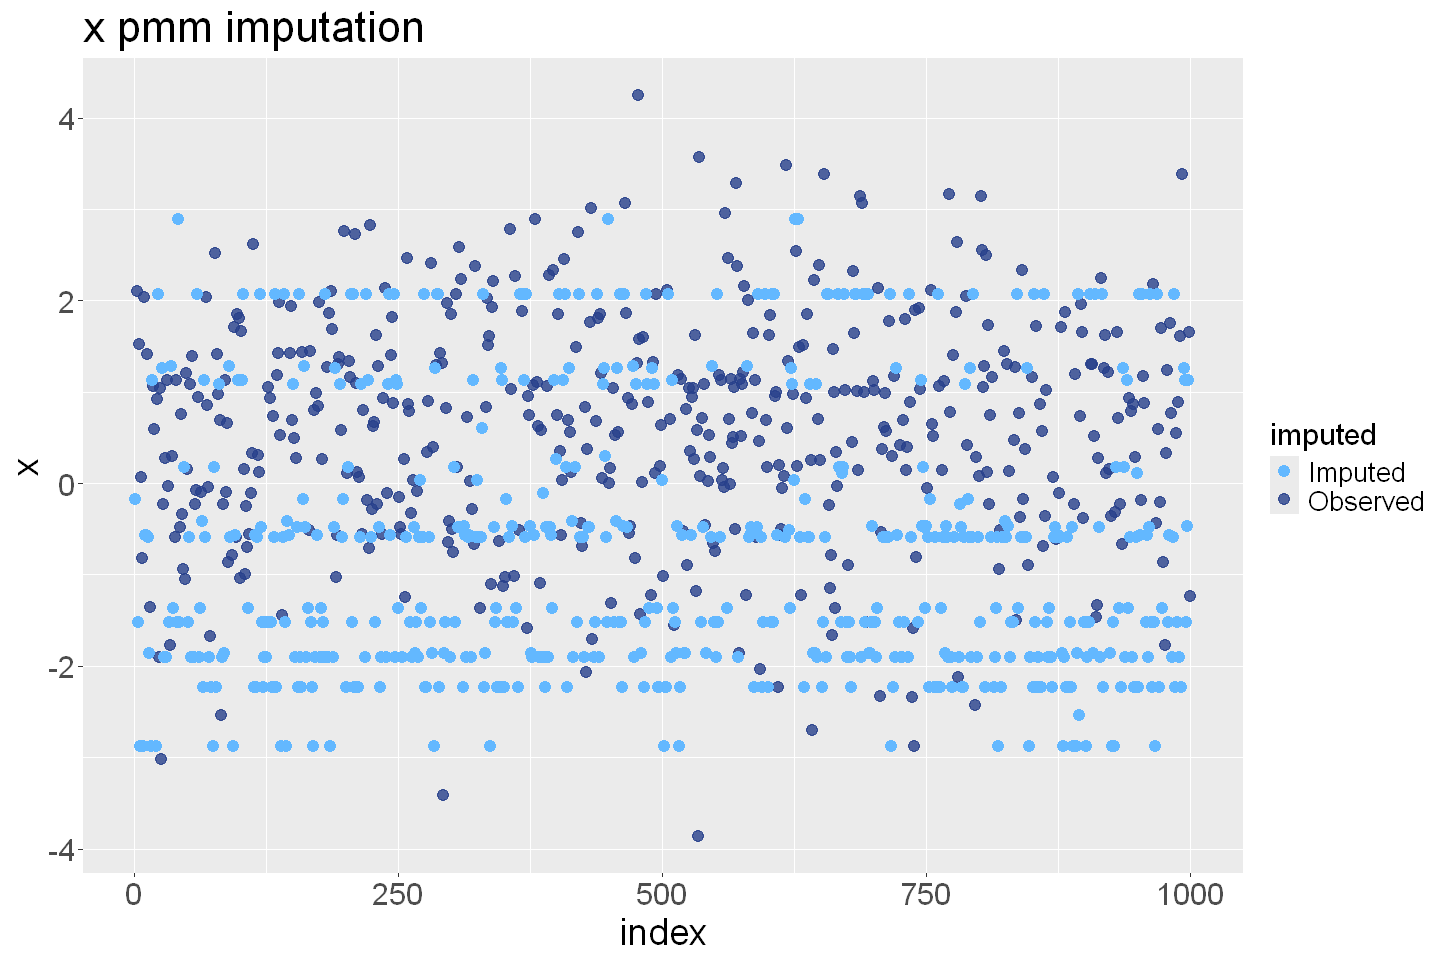

In [37]:
visImpCont(train_num2, test_num2, train_num2_pmm, test_num2_pmm, "x", "pmm")

In [38]:
method5 <- c("norm.predict", "", "", "", "")
train_num1_mice_linreg <- mice(data = train_num1, m = 4, maxit = 10, printFlag = FALSE, method = method5, predictorMatrix = predm) %>% complete(action="long")
train_num2_mice_linreg <- mice(data = train_num2, m = 4, maxit = 10, printFlag = FALSE, method = method5, predictorMatrix = predm) %>% complete(action="long")

test_num1_mice_linreg <- mice(data = test_num1, m = 4, maxit = 10, printFlag = FALSE, method = method5, predictorMatrix = predm) %>% complete(action="long")
test_num2_mice_linreg <- mice(data = test_num2, m = 4, maxit = 10, printFlag = FALSE, method = method5, predictorMatrix = predm) %>% complete(action="long")

In [39]:
train_num1_stack <- rbind(train_num1, train_num1, train_num1, train_num1)
test_num1_stack <- rbind(test_num1, test_num1, test_num1, test_num1)
train_num2_stack <- rbind(train_num2, train_num2, train_num2, train_num2)
test_num2_stack <- rbind(test_num2, test_num2, test_num2, test_num2)

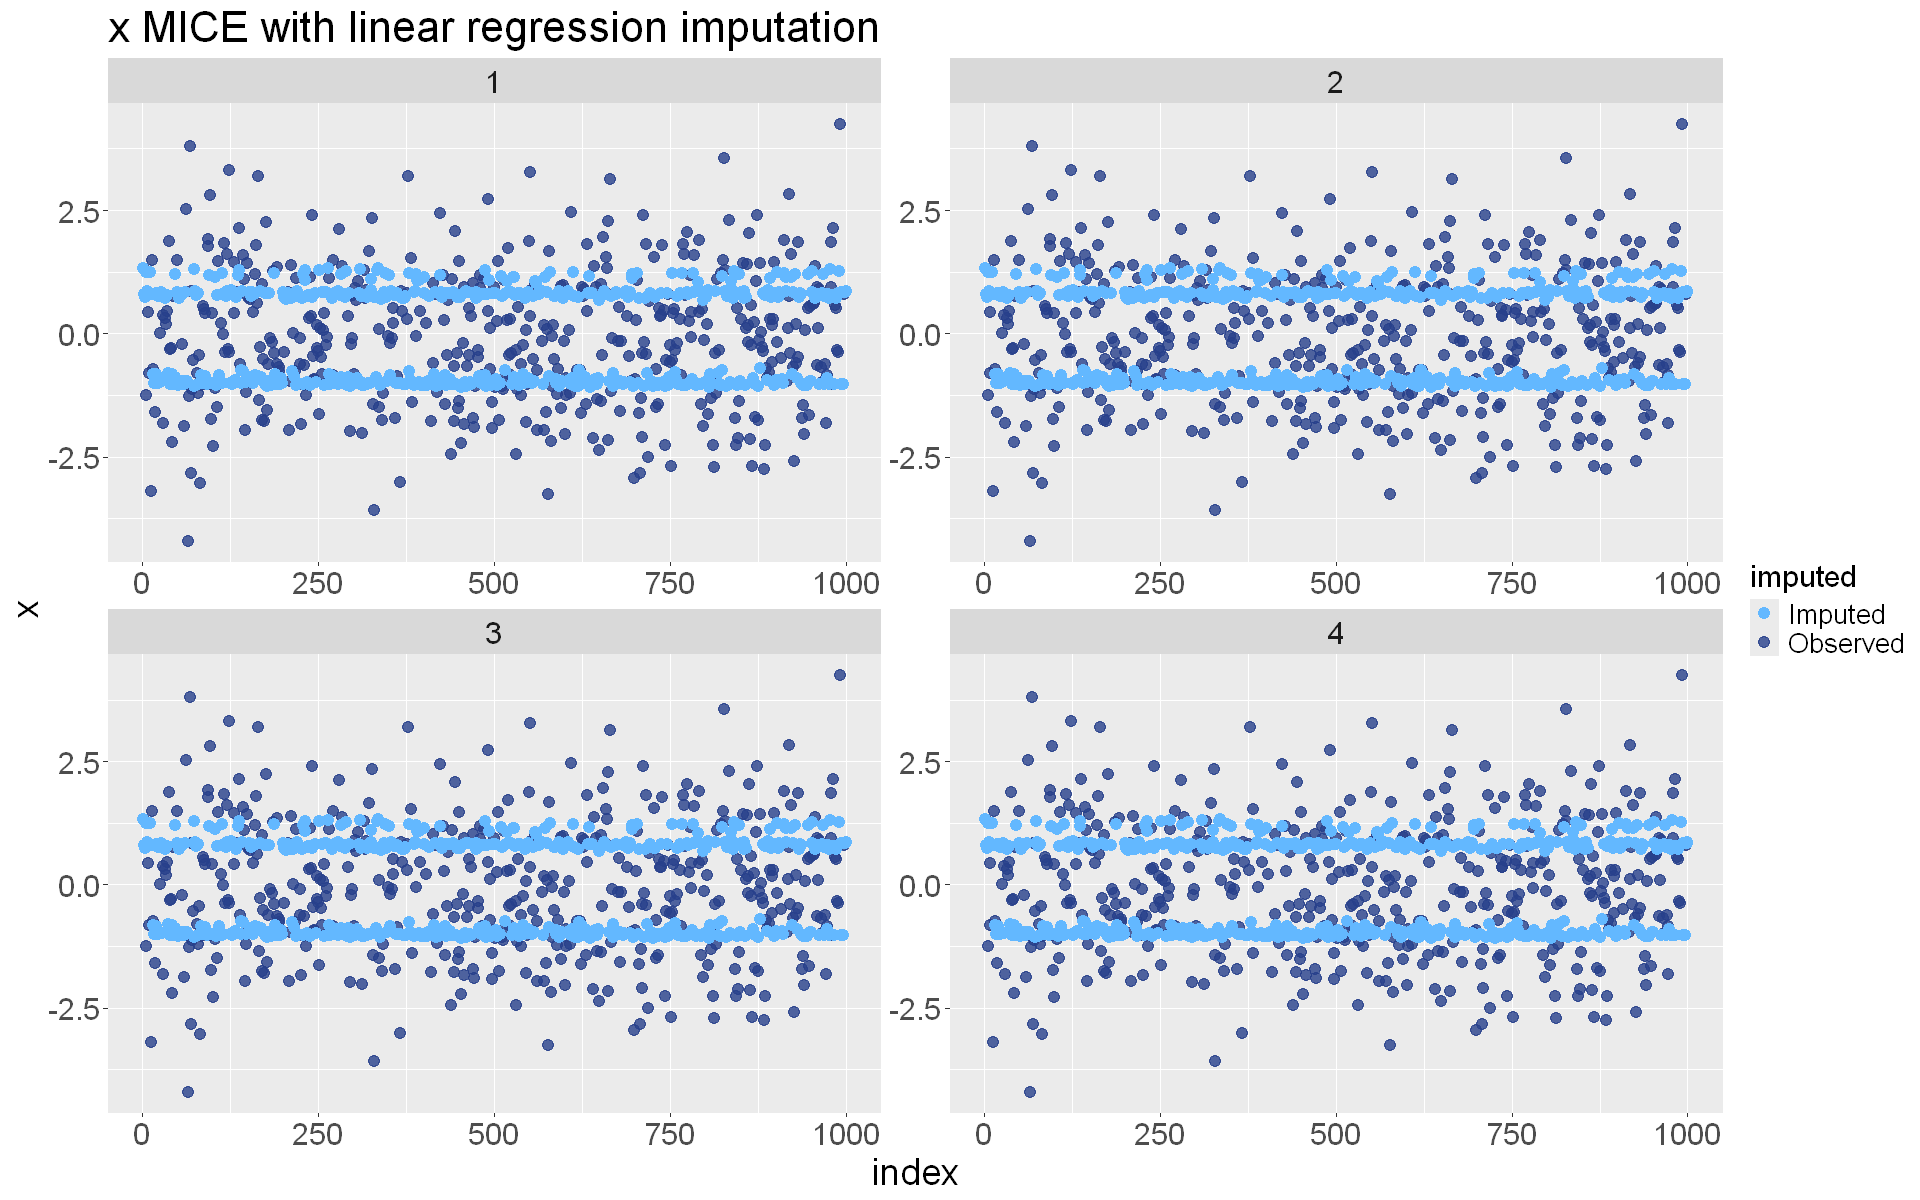

In [41]:
options(repr.plot.width = 16, repr.plot.height = 10)
visImpMul(train_num1_stack, test_num1_stack, train_num1_mice_linreg, test_num1_mice_linreg, "x", "MICE with linear regression")

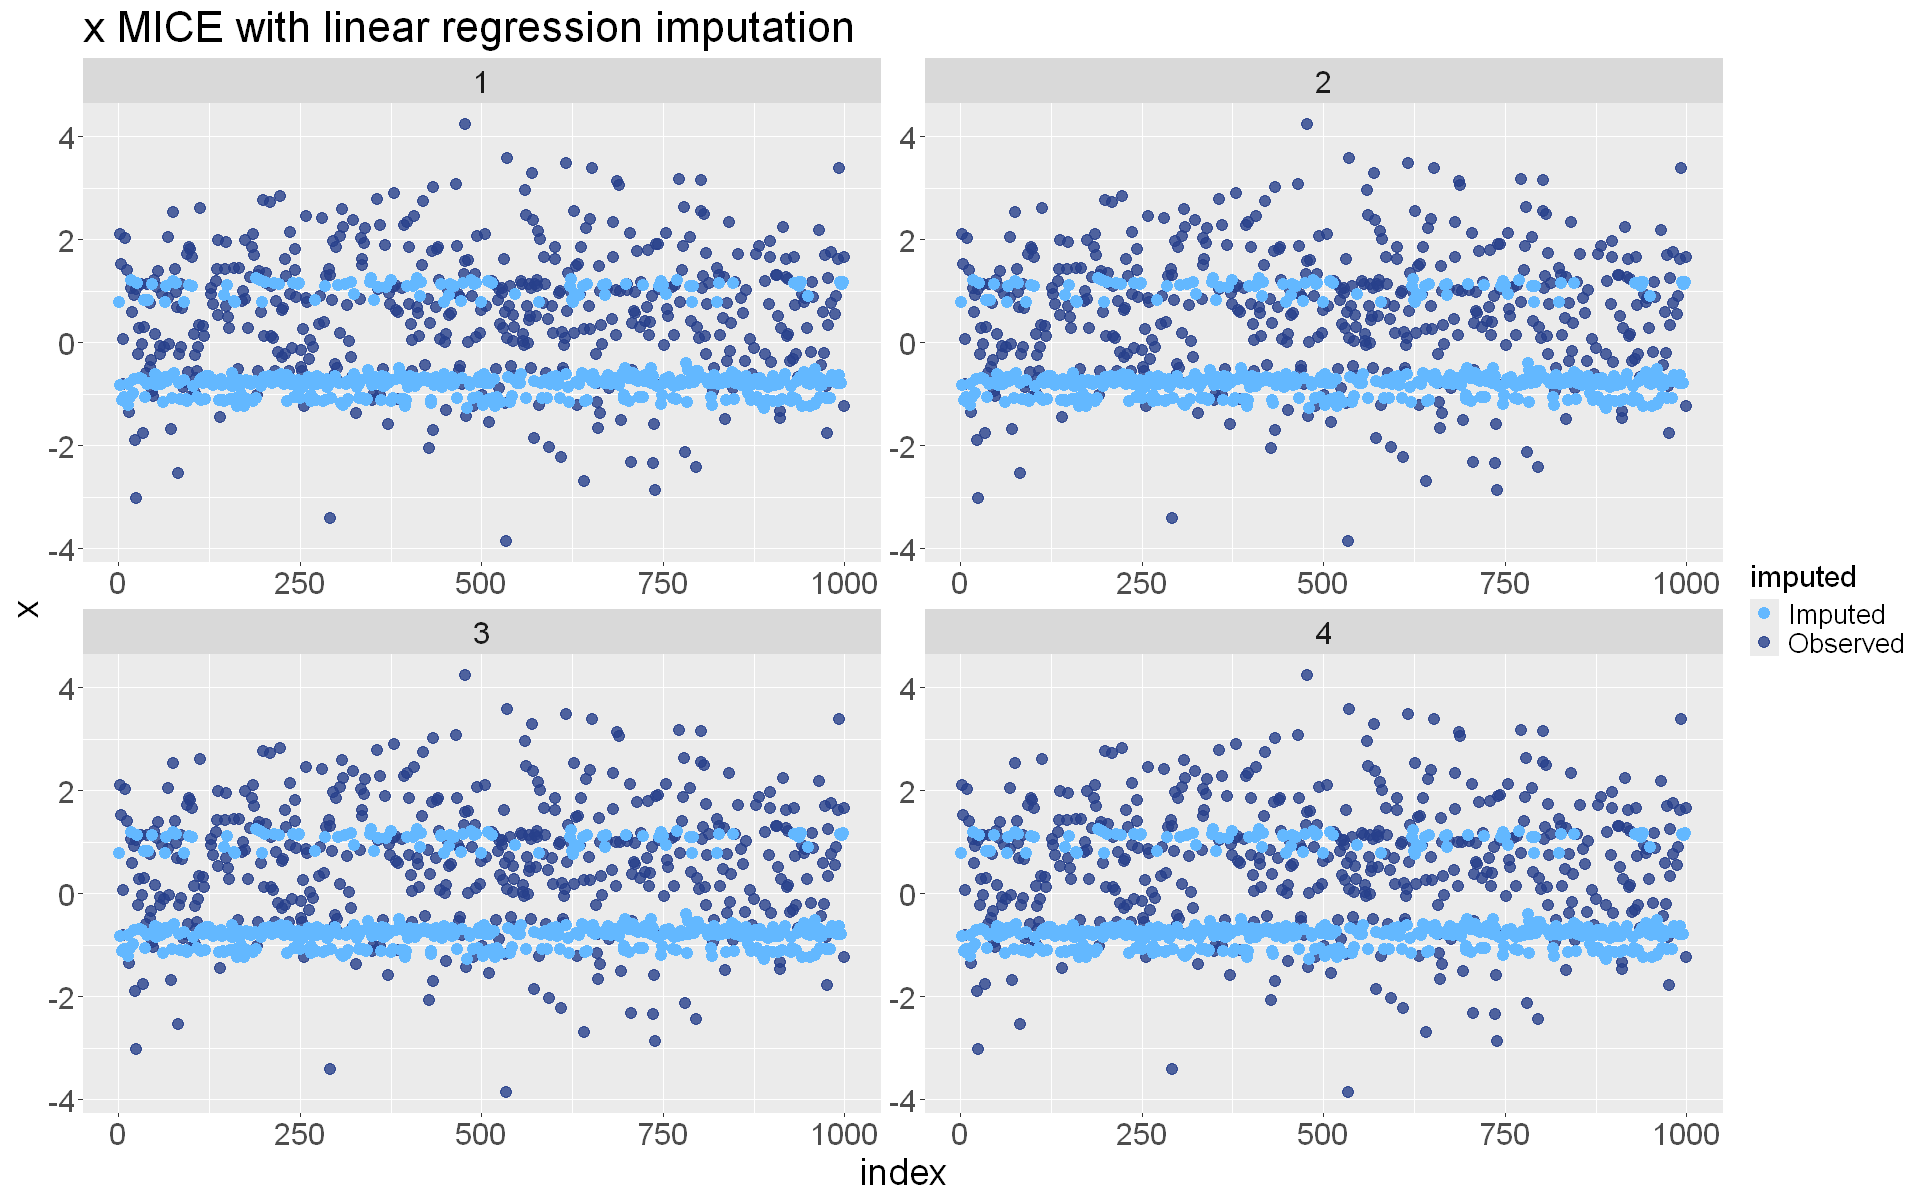

In [42]:
visImpMul(train_num2_stack, test_num2_stack, train_num2_mice_linreg, test_num2_mice_linreg, "x", "MICE with linear regression")

In [43]:
method6 <- c("norm.nob", "", "", "", "")
train_num1_mice_stochreg <- mice(data = train_num1, m = 4, maxit = 10, printFlag = FALSE, method = method6, predictorMatrix = predm) %>% complete(action="long")
train_num2_mice_stochreg <- mice(data = train_num2, m = 4, maxit = 10, printFlag = FALSE, method = method6, predictorMatrix = predm) %>% complete(action="long")

test_num1_mice_stochreg <- mice(data = test_num1, m = 4, maxit = 10, printFlag = FALSE, method = method6, predictorMatrix = predm) %>% complete(action="long")
test_num2_mice_stochreg <- mice(data = test_num2, m = 4, maxit = 10, printFlag = FALSE, method = method6, predictorMatrix = predm) %>% complete(action="long")


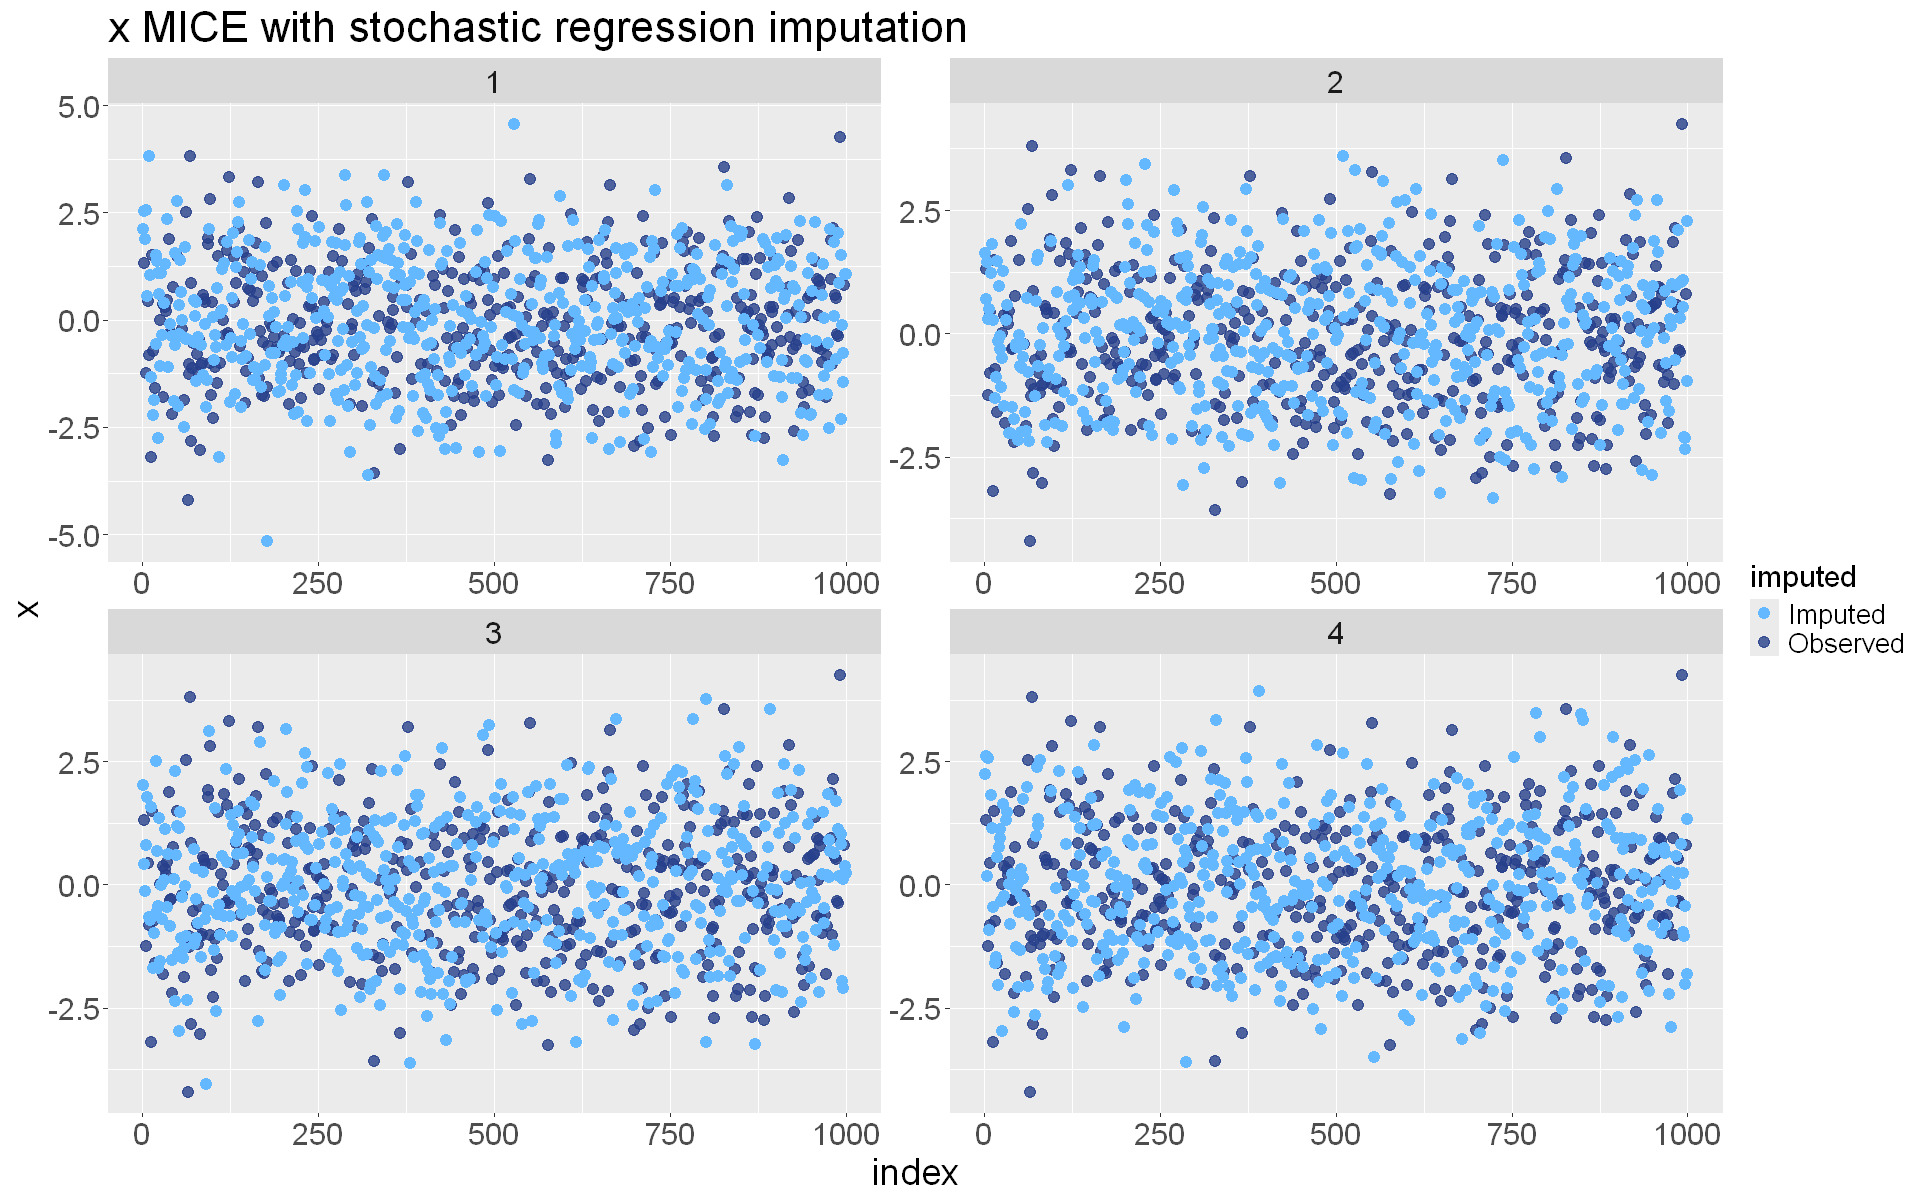

In [44]:
visImpMul(train_num1_stack, test_num1_stack, train_num1_mice_stochreg, test_num1_mice_stochreg, "x", "MICE with stochastic regression")

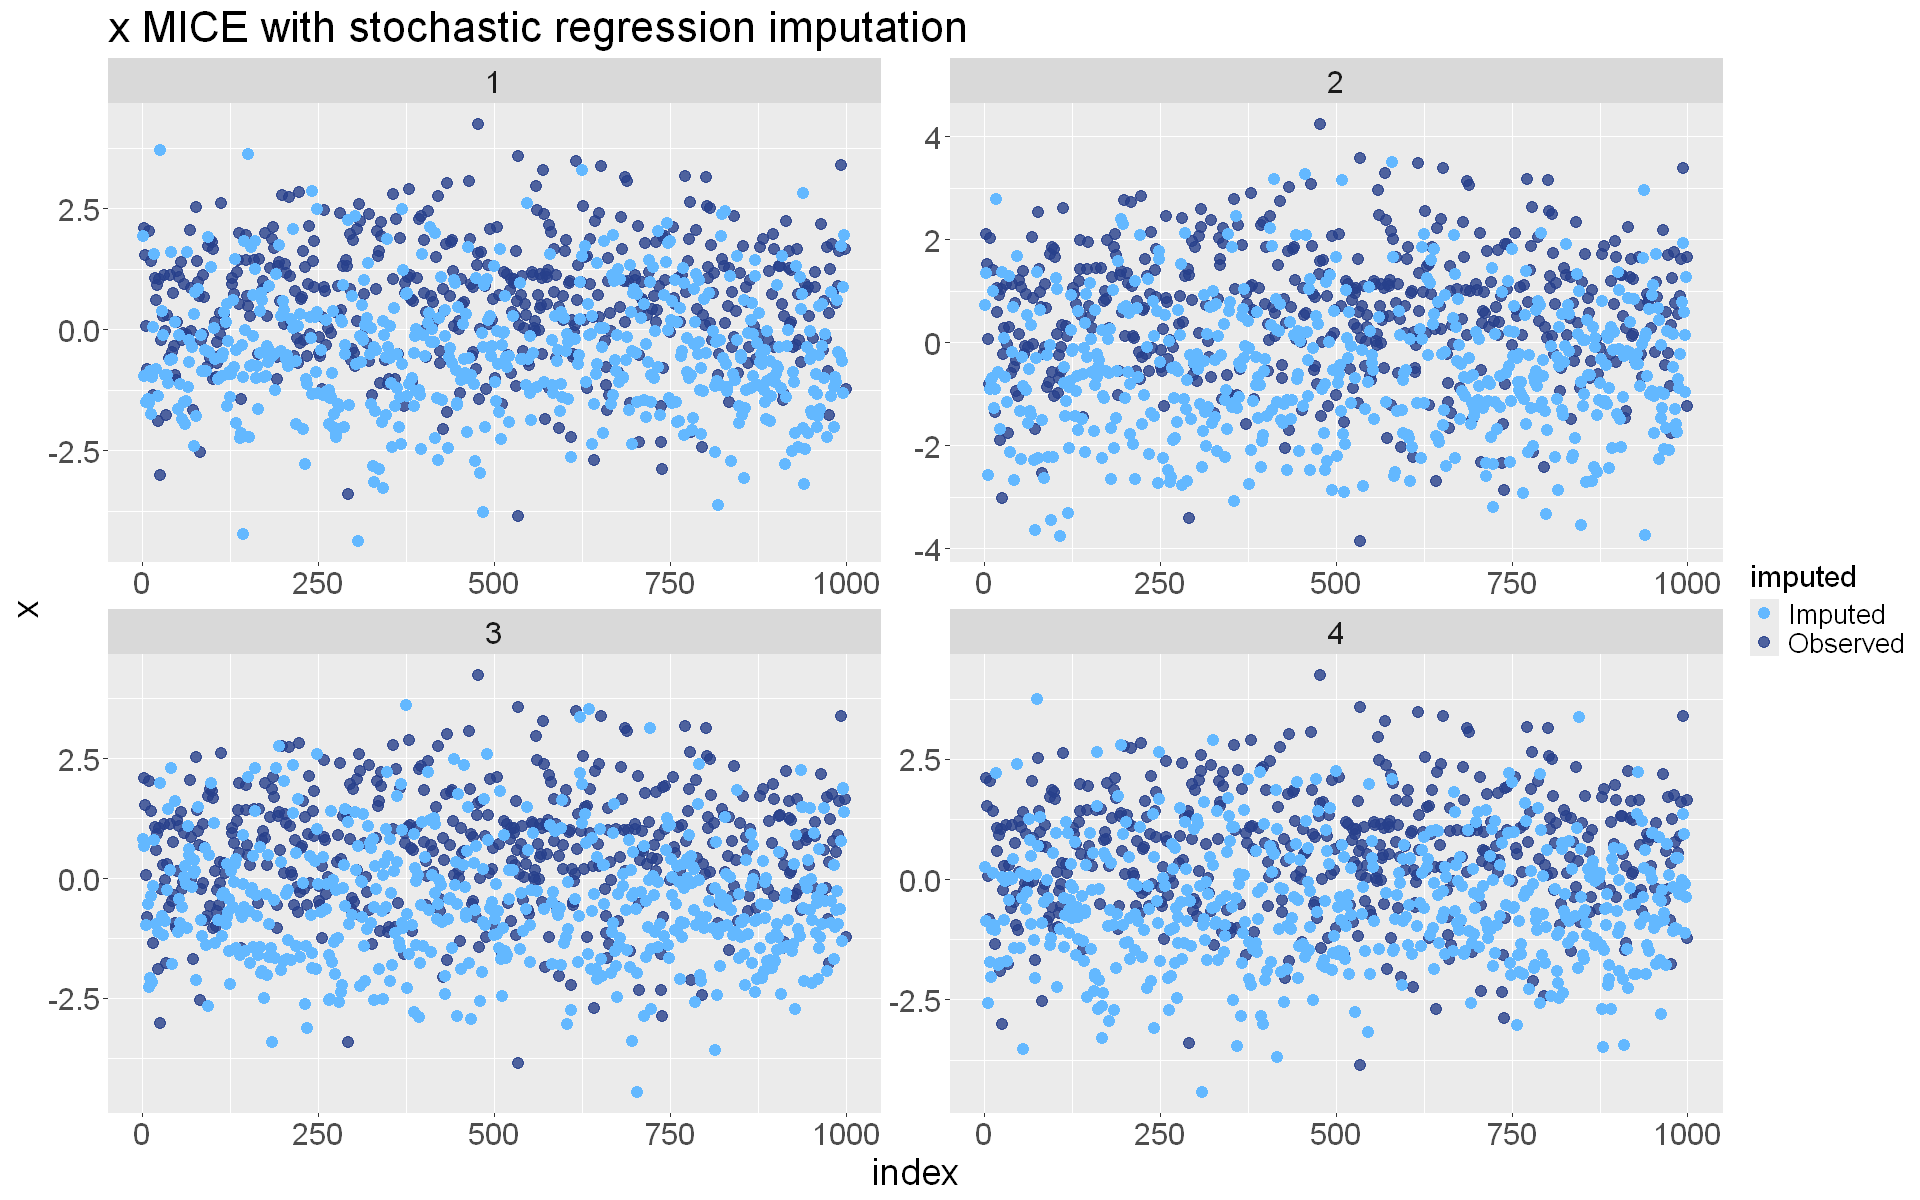

In [45]:
visImpMul(train_num2_stack, test_num2_stack, train_num2_mice_stochreg, test_num2_mice_stochreg, "x", "MICE with stochastic regression")

In [46]:
method7 <- c("pmm", "", "", "", "")
train_num1_mice_pmm <- mice(data = train_num1, m = 4, maxit = 10, printFlag = FALSE, method = method7, predictorMatrix = predm) %>% complete(action="long")
train_num2_mice_pmm <- mice(data = train_num2, m = 4, maxit = 10, printFlag = FALSE, method = method7, predictorMatrix = predm) %>% complete(action="long")

test_num1_mice_pmm <- mice(data = test_num1, m = 4, maxit = 10, printFlag = FALSE, method = method7, predictorMatrix = predm) %>% complete(action="long")
test_num2_mice_pmm <- mice(data = test_num2, m = 4, maxit = 10, printFlag = FALSE, method = method7, predictorMatrix = predm) %>% complete(action="long")

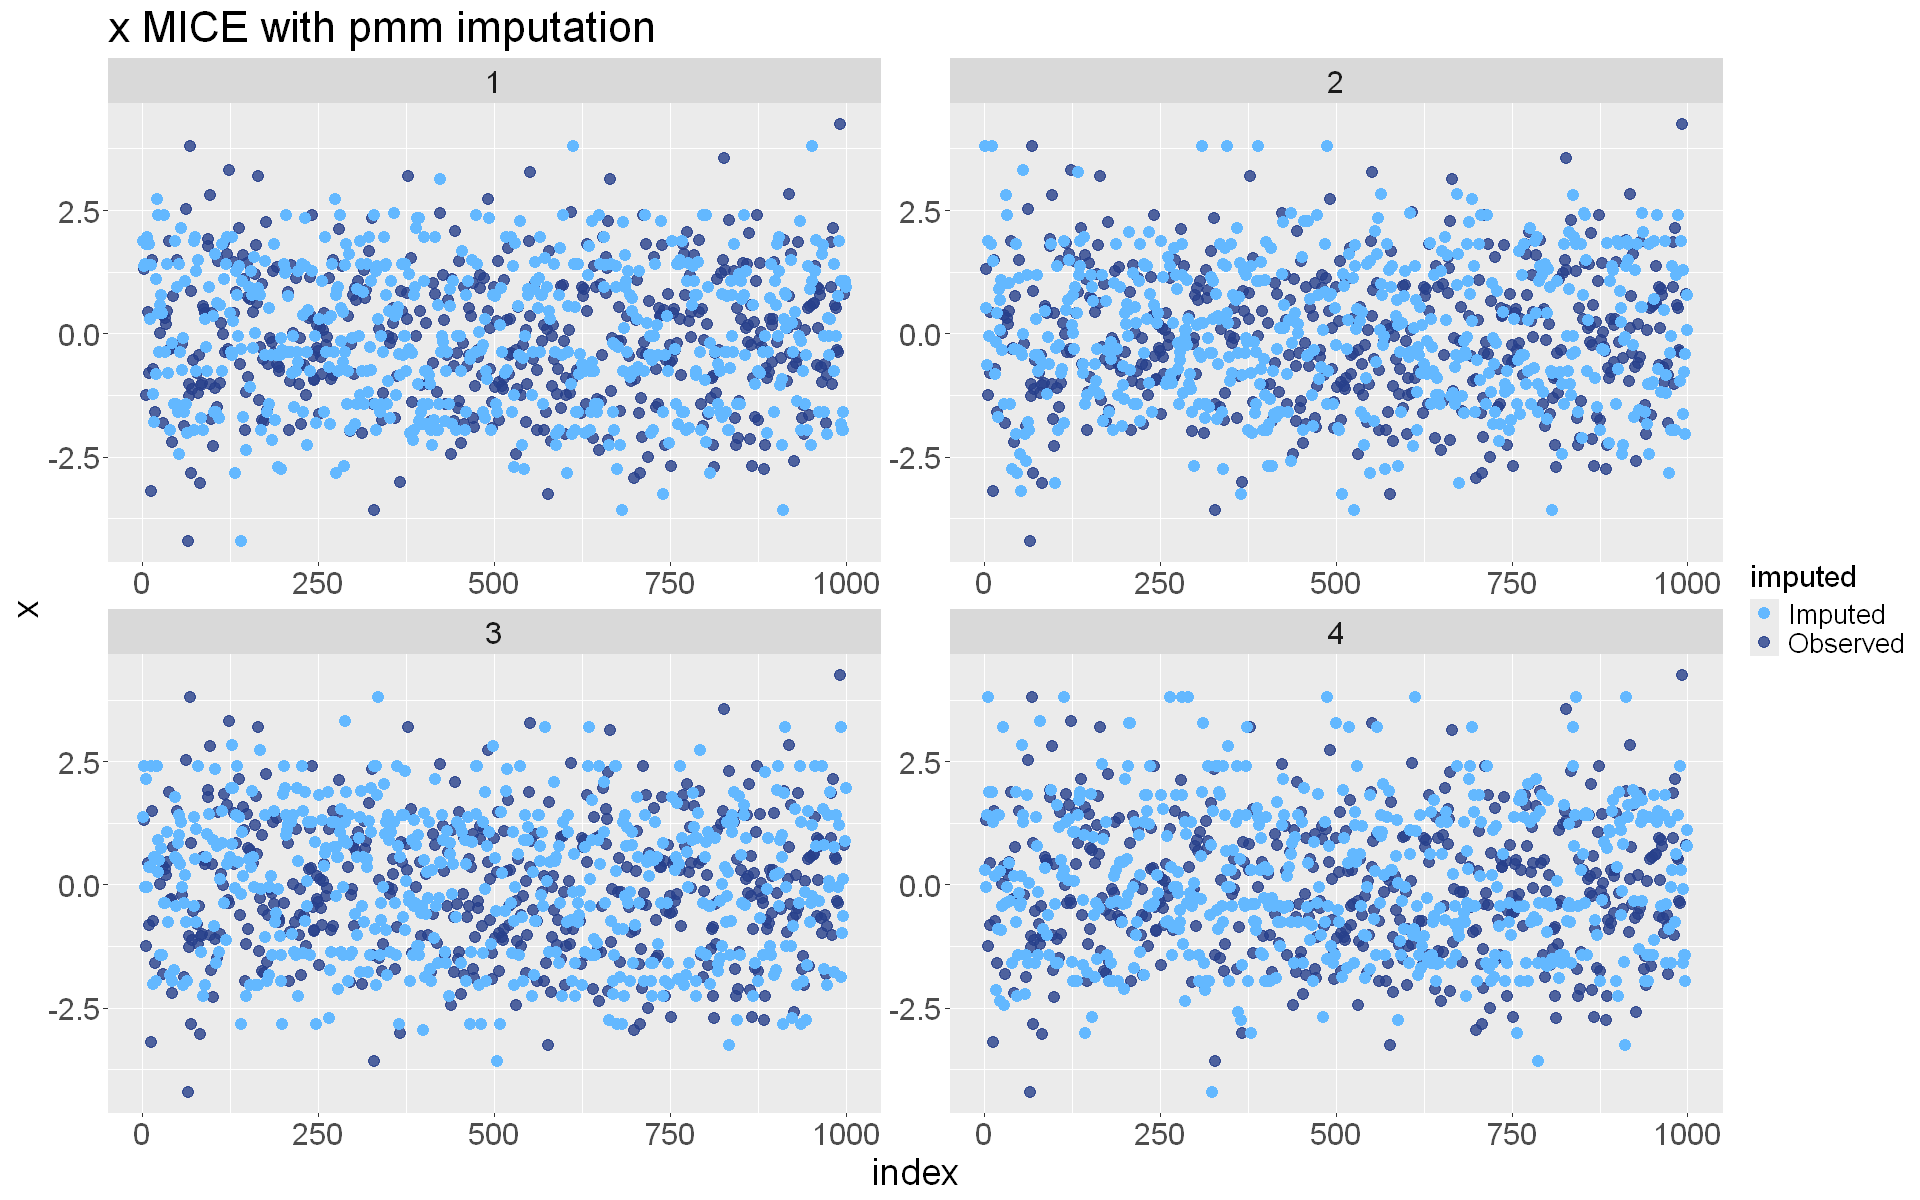

In [47]:
visImpMul(train_num1_stack, test_num1_stack, train_num1_mice_pmm, test_num1_mice_pmm, "x", "MICE with pmm")

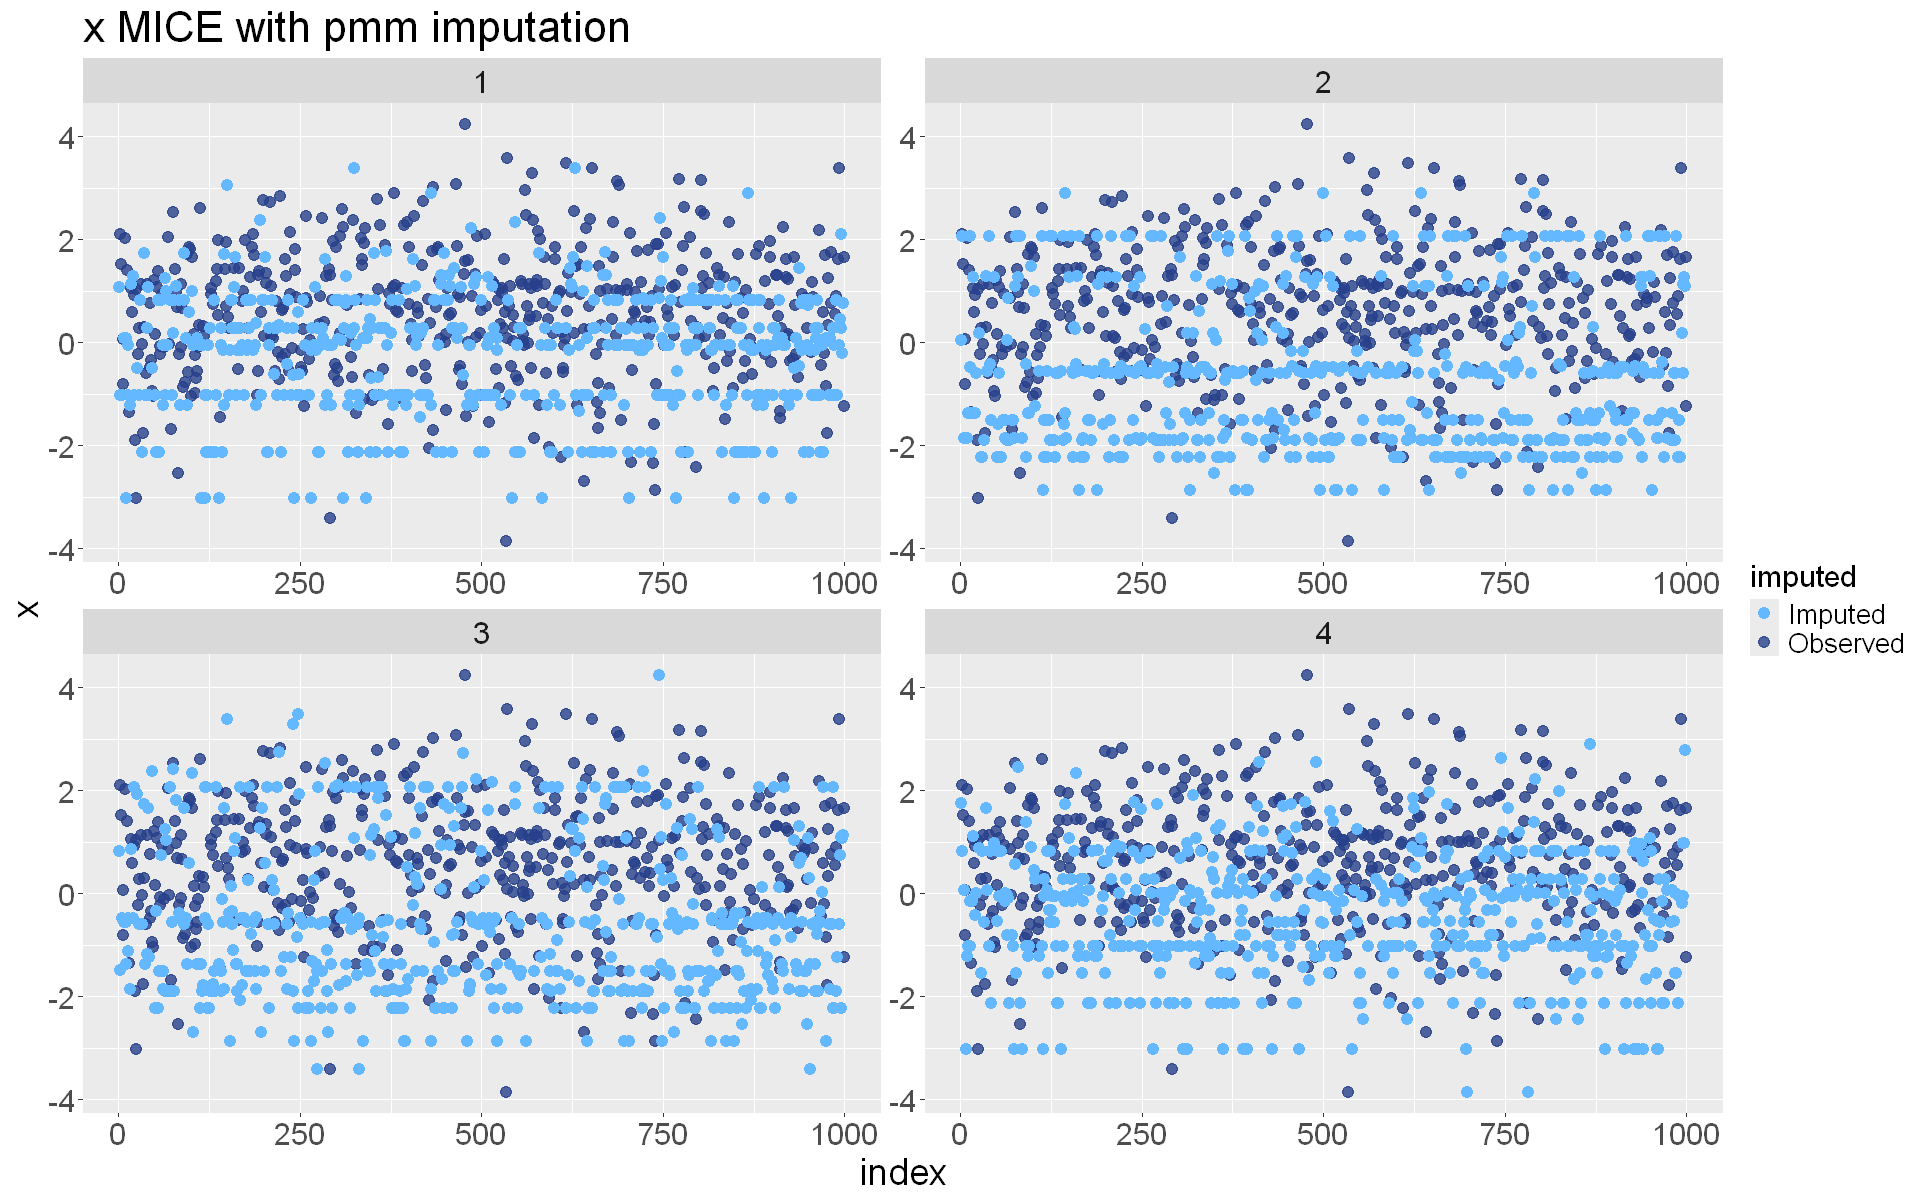

In [48]:
visImpMul(train_num2_stack, test_num2_stack, train_num2_mice_pmm, test_num2_mice_pmm, "x", "MICE with pmm")

In [49]:
train_num1_knn <- knnImputation(train_num1, scale=FALSE)
test_num1_knn <- knnImputation(test_num1, scale=FALSE)

train_num2_knn <- knnImputation(train_num2, scale=FALSE)
test_num2_knn <- knnImputation(test_num2, scale=FALSE)

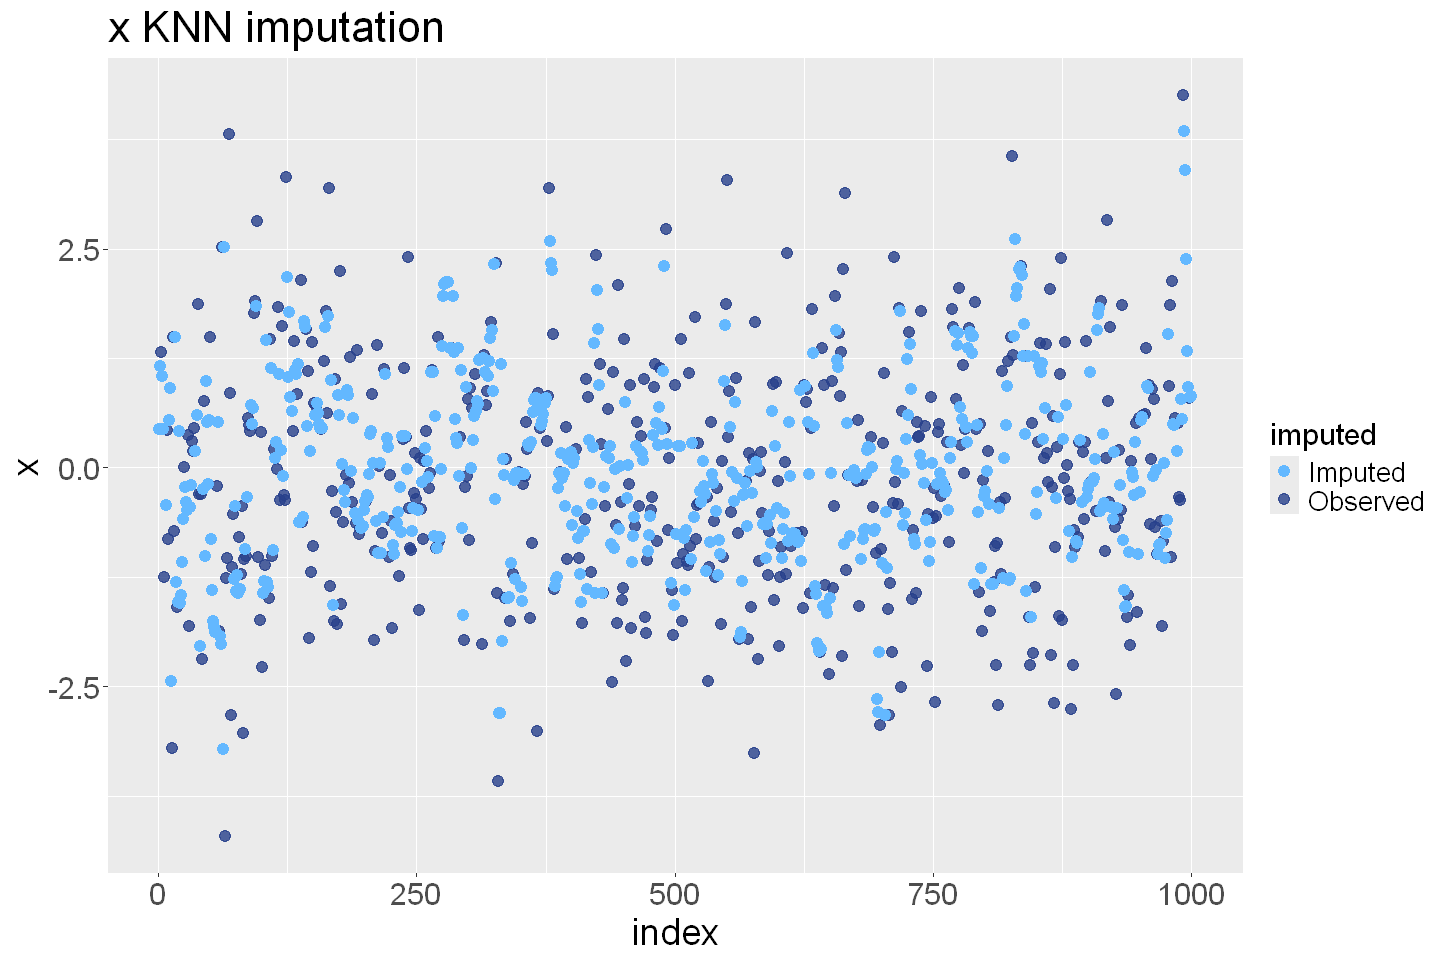

In [50]:
options(repr.plot.width = 12, repr.plot.height = 8)
visImpCont(train_num1, test_num1, train_num1_knn, test_num1_knn, "x", "KNN")

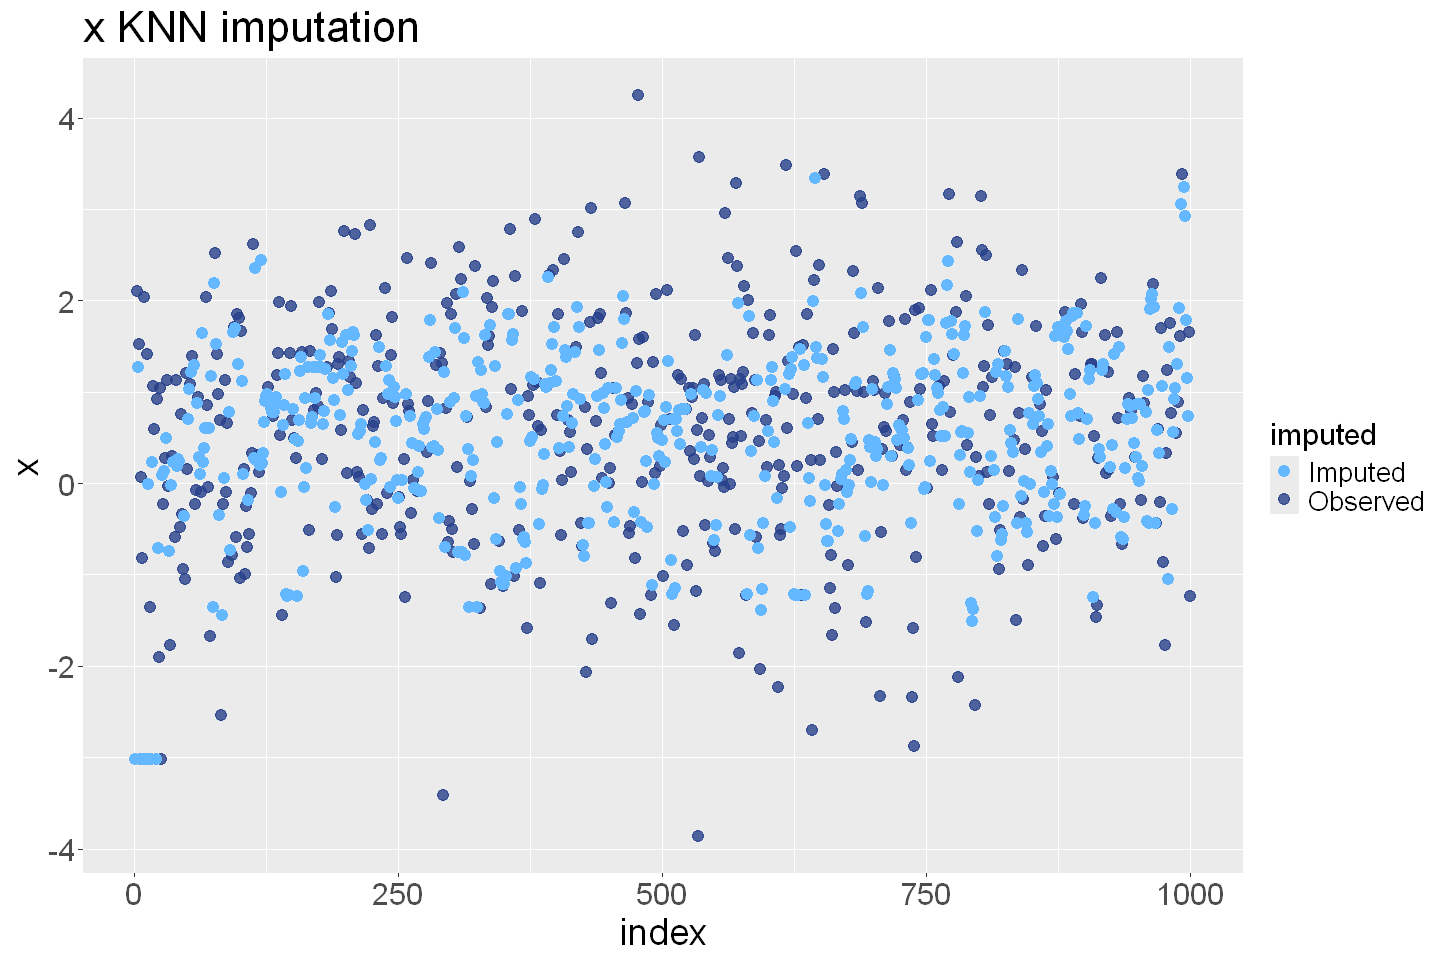

In [51]:
visImpCont(train_num2, test_num2, train_num2_knn, test_num2_knn, "x", "KNN")

In [52]:
head(num1)

,x,y,z,class,index
,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,NA,2.6807174,1,0,1
2,NA,-0.2879268,1,0,2
3,1.315563,1.1054995,0,0,3
4,NA,0.3201142,0,0,4
5,NA,1.2721533,1,0,5
6,-1.250829,-2.4532029,0,1,6


In [53]:
train_num1_mlmi <- normImp(obsData = train_num1, M = 4, rseed = 1234)
test_num1_mlmi <- normImp(obsData = test_num1, M = 4, rseed = 1234)

train_num2_mlmi <- normImp(obsData = train_num2, M = 4, rseed = 1234)
test_num2_mlmi <- normImp(obsData = test_num2, M = 4, rseed = 1234)

Iterations of EM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...
Iterations of EM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...
Iterations of EM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...
Iterations of EM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85

In [54]:
for (i in 1:4) {
    rownames(train_num1_mlmi[[i]]) <- NULL
    rownames(test_num1_mlmi[[i]]) <- NULL
    train_num1_mlmi[[i]]$class <- as.factor(train_num1_mlmi[[i]]$class)
    train_num1_mlmi[[i]]$z <- as.factor(train_num1_mlmi[[i]]$z)
    train_num1_mlmi[[i]]$y <- as.numeric(train_num1_mlmi[[i]]$y)
    train_num1_mlmi[[i]]$x <- as.numeric(train_num1_mlmi[[i]]$x)
    test_num1_mlmi[[i]]$class <- as.factor(test_num1_mlmi[[i]]$class)
    test_num1_mlmi[[i]]$z <- as.factor(test_num1_mlmi[[i]]$z)
    test_num1_mlmi[[i]]$y <- as.numeric(test_num1_mlmi[[i]]$y)
    test_num1_mlmi[[i]]$x <- as.numeric(test_num1_mlmi[[i]]$x)

    rownames(train_num2_mlmi[[i]]) <- NULL
    rownames(test_num2_mlmi[[i]]) <- NULL
    train_num2_mlmi[[i]]$class <- as.factor(train_num2_mlmi[[i]]$class)
    train_num2_mlmi[[i]]$z <- as.factor(train_num2_mlmi[[i]]$z)
    train_num2_mlmi[[i]]$y <- as.numeric(train_num2_mlmi[[i]]$y)
    train_num2_mlmi[[i]]$x <- as.numeric(train_num2_mlmi[[i]]$x)
    test_num2_mlmi[[i]]$class <- as.factor(test_num2_mlmi[[i]]$class)
    test_num2_mlmi[[i]]$z <- as.factor(test_num2_mlmi[[i]]$z)
    test_num2_mlmi[[i]]$y <- as.numeric(test_num2_mlmi[[i]]$y)
    test_num2_mlmi[[i]]$x <- as.numeric(test_num2_mlmi[[i]]$x)
}

In [66]:
train_num1_mlmi_con <- train_num1_mlmi[[1]]
train_num2_mlmi_con <- train_num2_mlmi[[1]]
train_num1_mlmi_con$.imp <- 1
train_num2_mlmi_con$.imp <- 1
test_num1_mlmi_con <- test_num1_mlmi[[1]]
test_num2_mlmi_con <- test_num2_mlmi[[1]]
test_num1_mlmi_con$.imp <- 1
test_num2_mlmi_con$.imp <- 1

for (i in 2:4) {
    n1 <- train_num1_mlmi[[i]]
    n2 <- train_num2_mlmi[[i]]
    n1$.imp <- i
    n2$.imp <- i
    train_num1_mlmi_con <- rbind(train_num1_mlmi_con, n1)
    train_num2_mlmi_con <- rbind(train_num2_mlmi_con, n2)

    n1 <- test_num1_mlmi[[i]]
    n2 <- test_num2_mlmi[[i]]
    n1$.imp <- i
    n2$.imp <- i
    test_num1_mlmi_con <- rbind(test_num1_mlmi_con, n1)
    test_num2_mlmi_con <- rbind(test_num2_mlmi_con, n2)
}

In [67]:
train_num1_mlmi_con$index <- train_num1_stack$index
test_num1_mlmi_con$index <- test_num1_stack$index

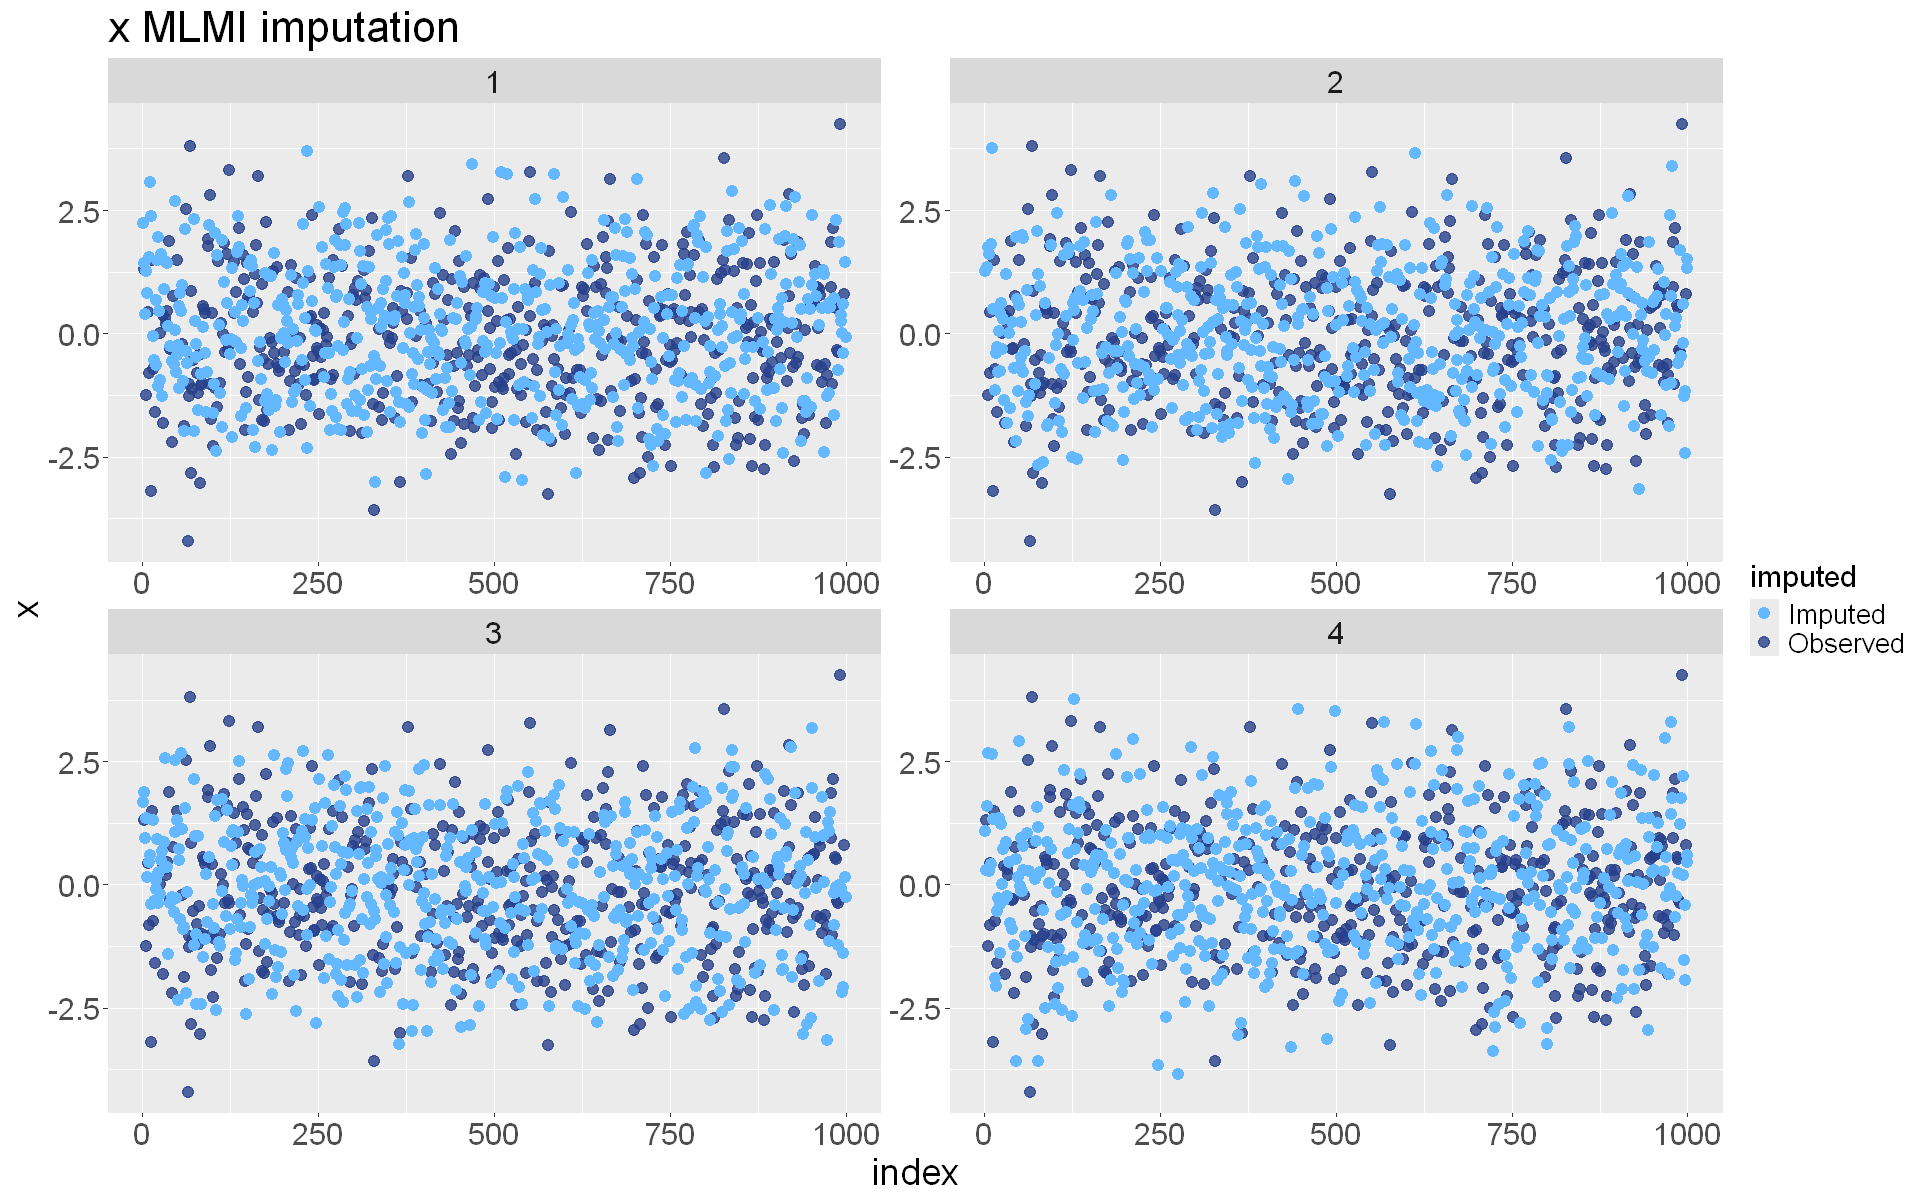

In [68]:
options(repr.plot.width = 16, repr.plot.height = 10)
visImpMul(train_num1_stack, test_num1_stack, train_num1_mlmi_con, test_num1_mlmi_con, "x", "MLMI")

In [69]:
train_num2_mlmi_con$index <- train_num2_stack$index
test_num2_mlmi_con$index <- test_num2_stack$index

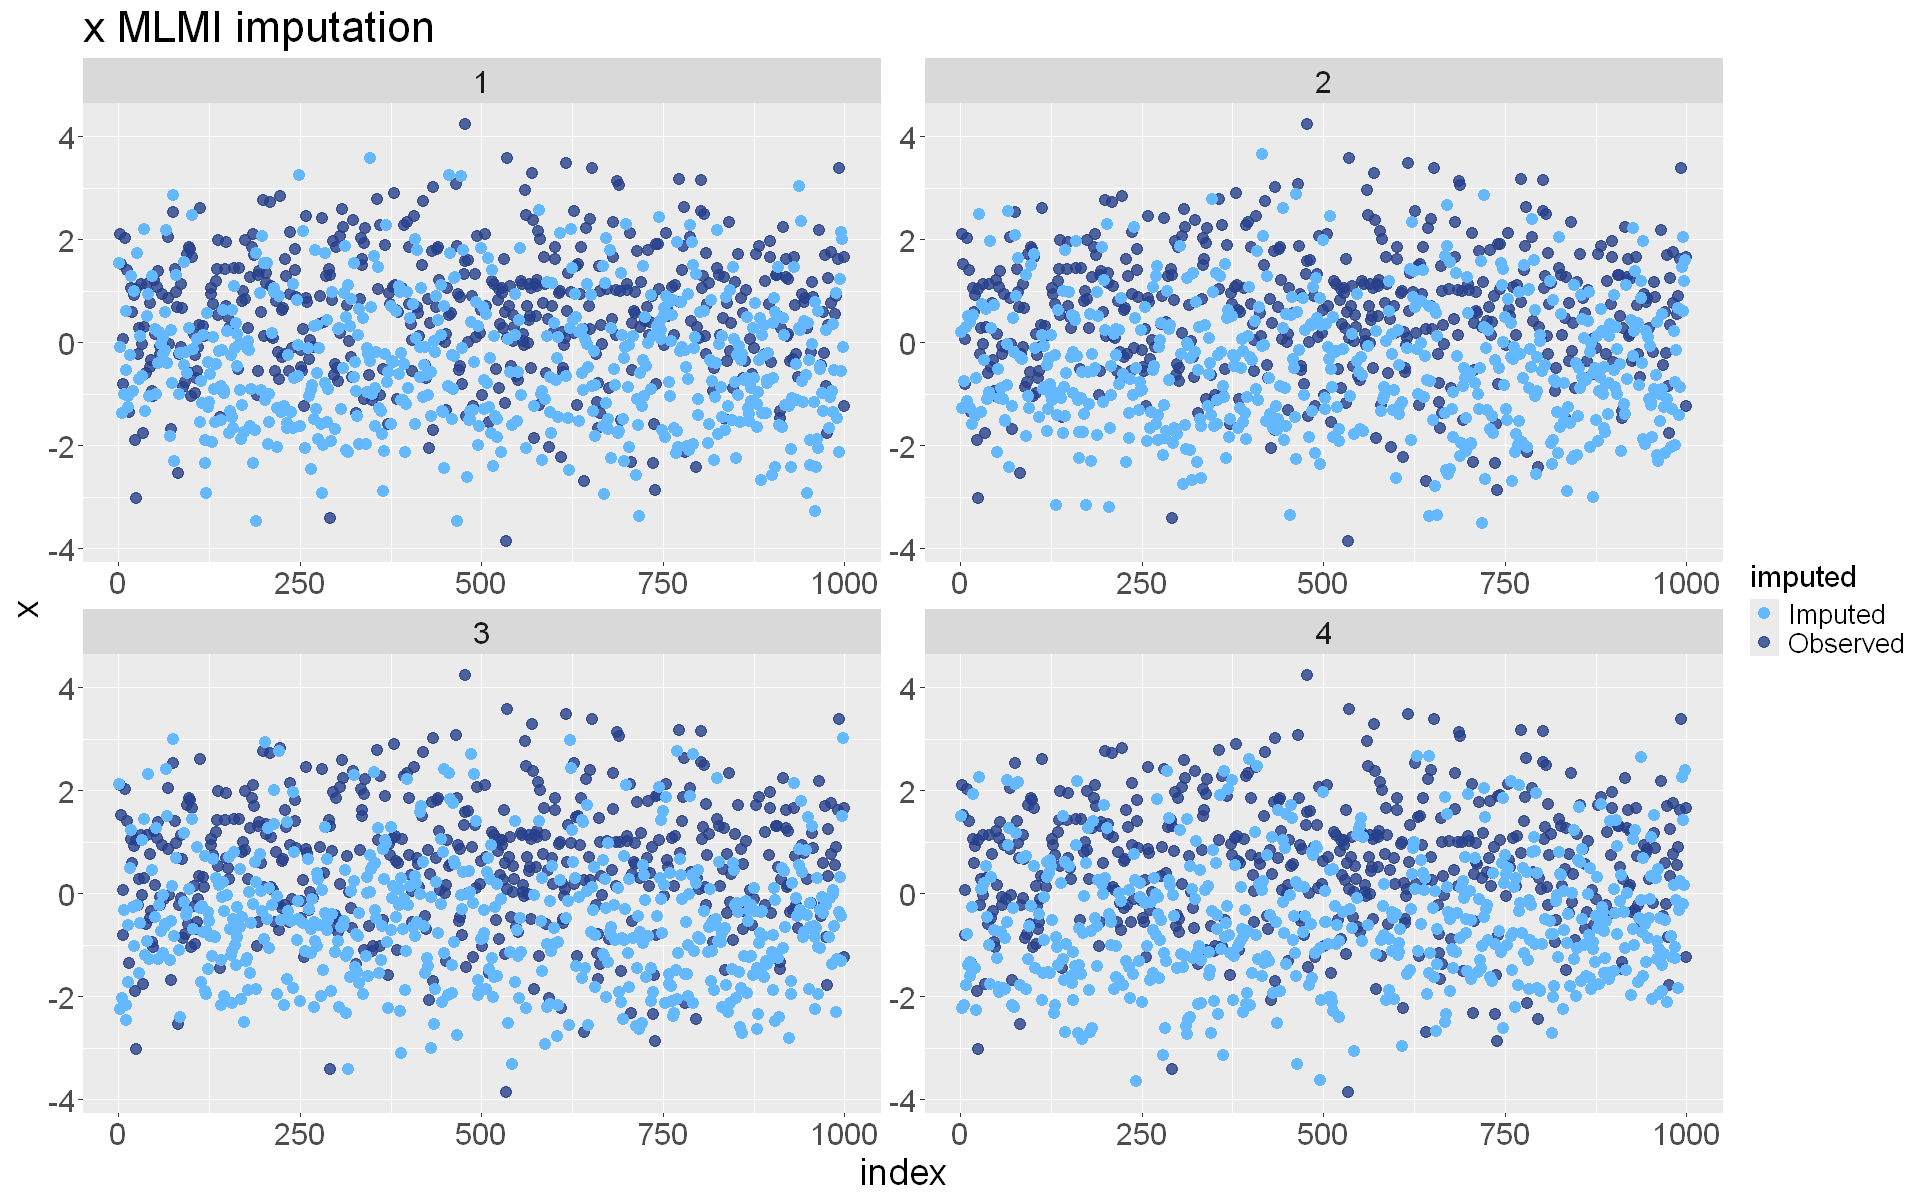

In [70]:
visImpMul(train_num2_stack, test_num2_stack, train_num2_mlmi_con, test_num2_mlmi_con, "x", "MLMI")

In [71]:
method10 <- c("cart", "", "", "", "")
train_num1_dt <- mice(data = train_num1, m = 1, maxit = 1, printFlag = FALSE, method = method10, predictorMatrix = predm) %>% complete()
train_num2_dt <- mice(data = train_num2, m = 1, maxit = 1, printFlag = FALSE, method = method10, predictorMatrix = predm) %>% complete()

test_num1_dt <- mice(data = test_num1, m = 1, maxit = 1, printFlag = FALSE, method = method10, predictorMatrix = predm) %>% complete()
test_num2_dt <- mice(data = test_num2, m = 1, maxit = 1, printFlag = FALSE, method = method10, predictorMatrix = predm) %>% complete()

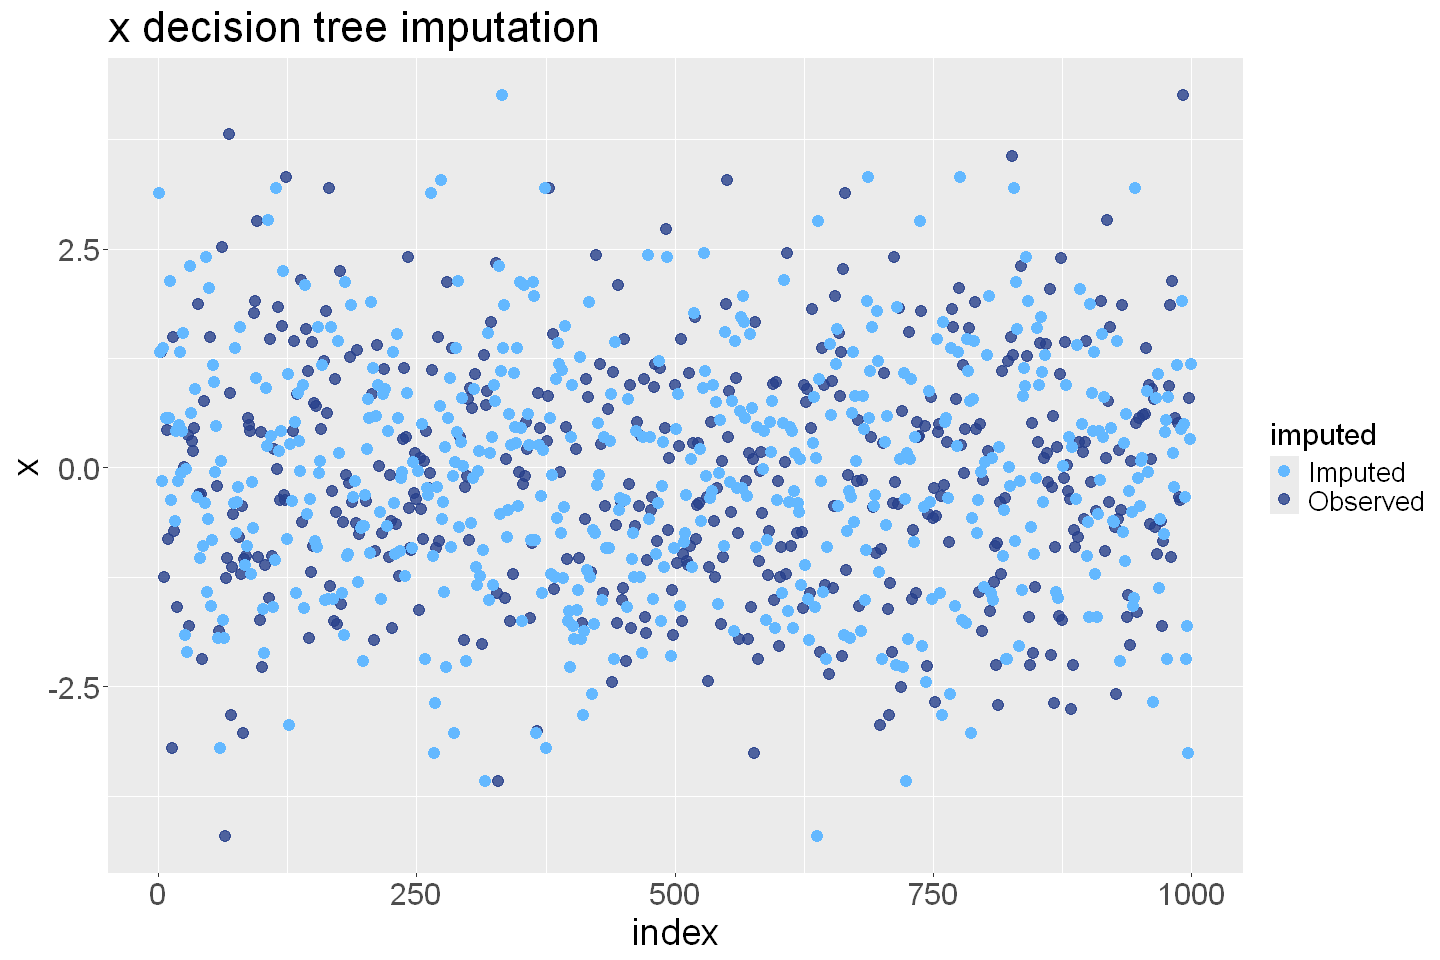

In [72]:
options(repr.plot.width = 12, repr.plot.height = 8)
visImpCont(train_num1, test_num1, train_num1_dt, test_num1_dt, "x", "decision tree")

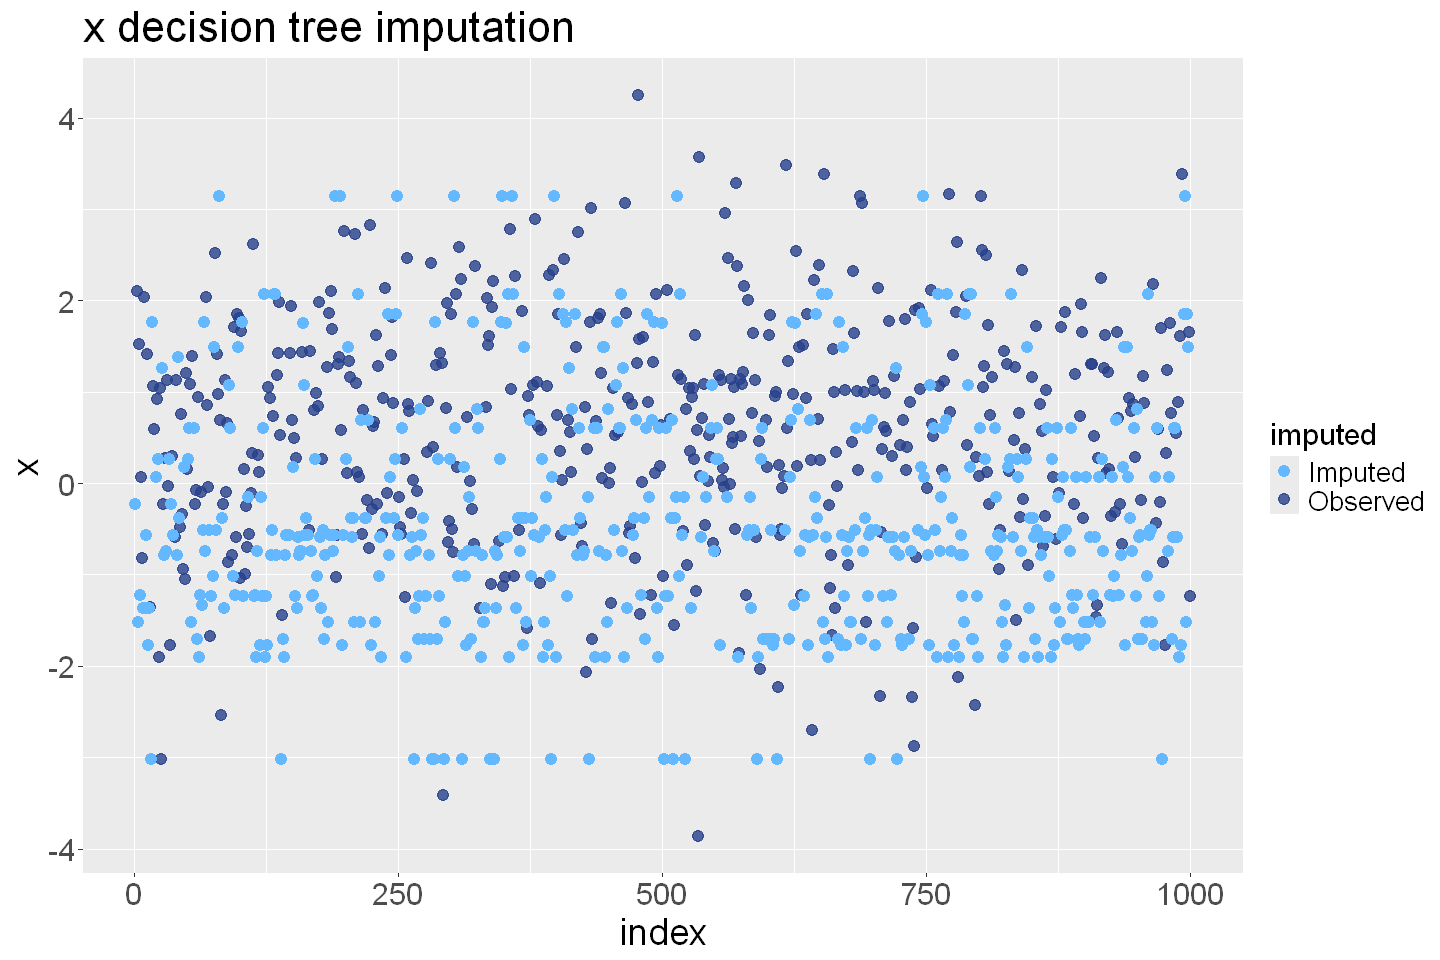

In [73]:
visImpCont(train_num2, test_num2, train_num2_dt, test_num2_dt, "x", "decision tree")

In [74]:
method11 <- c("rf", "", "", "", "")
train_num1_rf <- mice(data = train_num1, m = 1, maxit = 1, printFlag = FALSE, method = method11, predictorMatrix = predm) %>% complete()
train_num2_rf <- mice(data = train_num2, m = 1, maxit = 1, printFlag = FALSE, method = method11, predictorMatrix = predm) %>% complete()

test_num1_rf <- mice(data = test_num1, m = 1, maxit = 1, printFlag = FALSE, method = method11, predictorMatrix = predm) %>% complete()
test_num2_rf <- mice(data = test_num2, m = 1, maxit = 1, printFlag = FALSE, method = method11, predictorMatrix = predm) %>% complete()

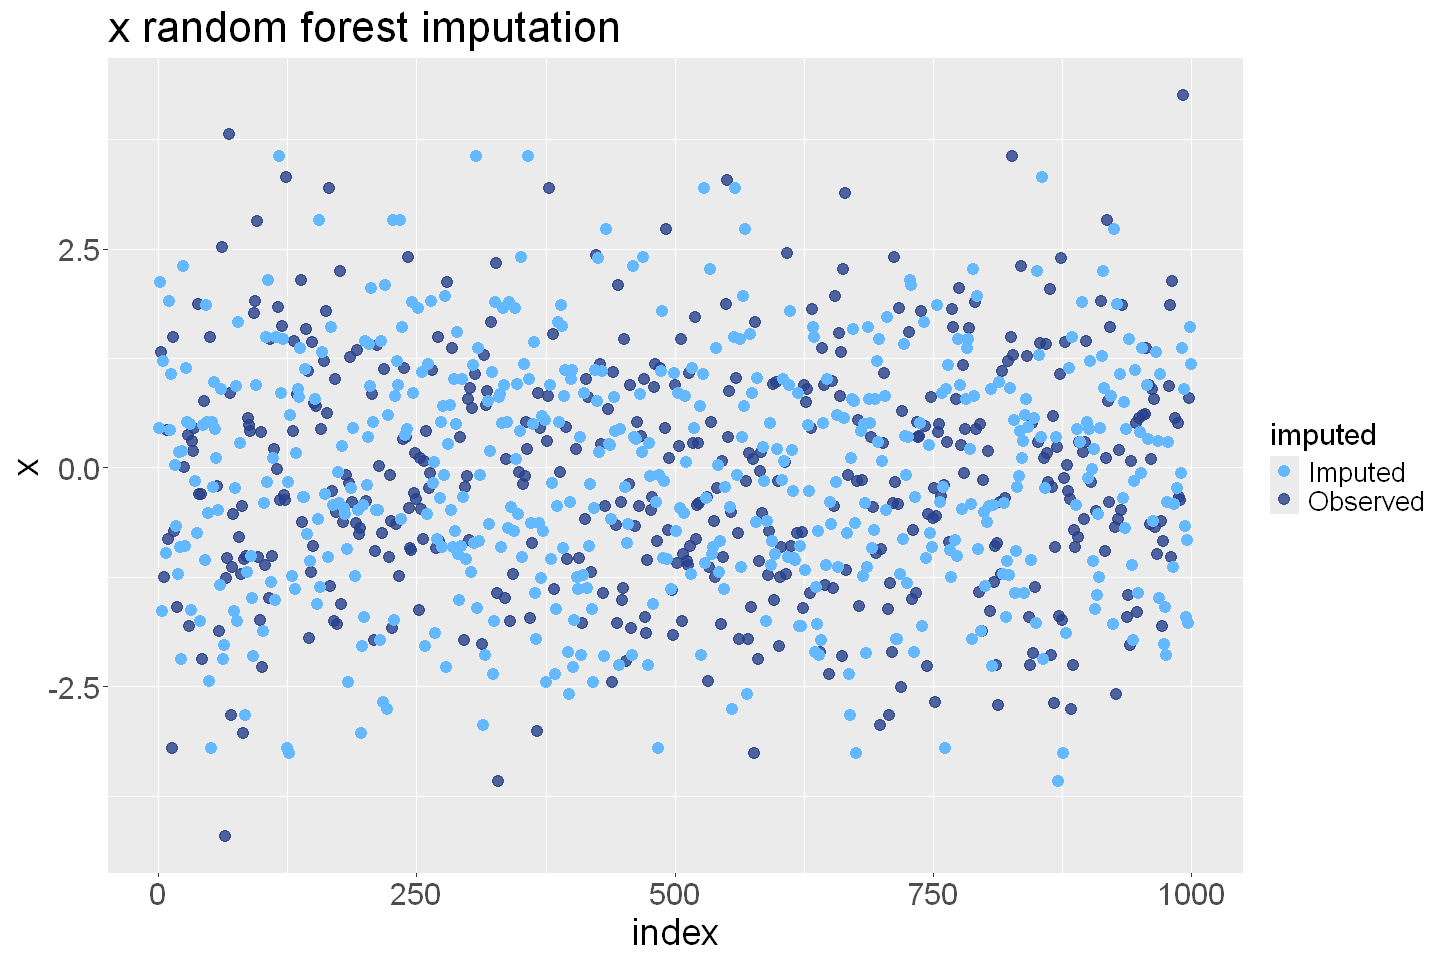

In [75]:
visImpCont(train_num1, test_num1, train_num1_rf, test_num1_rf, "x", "random forest")

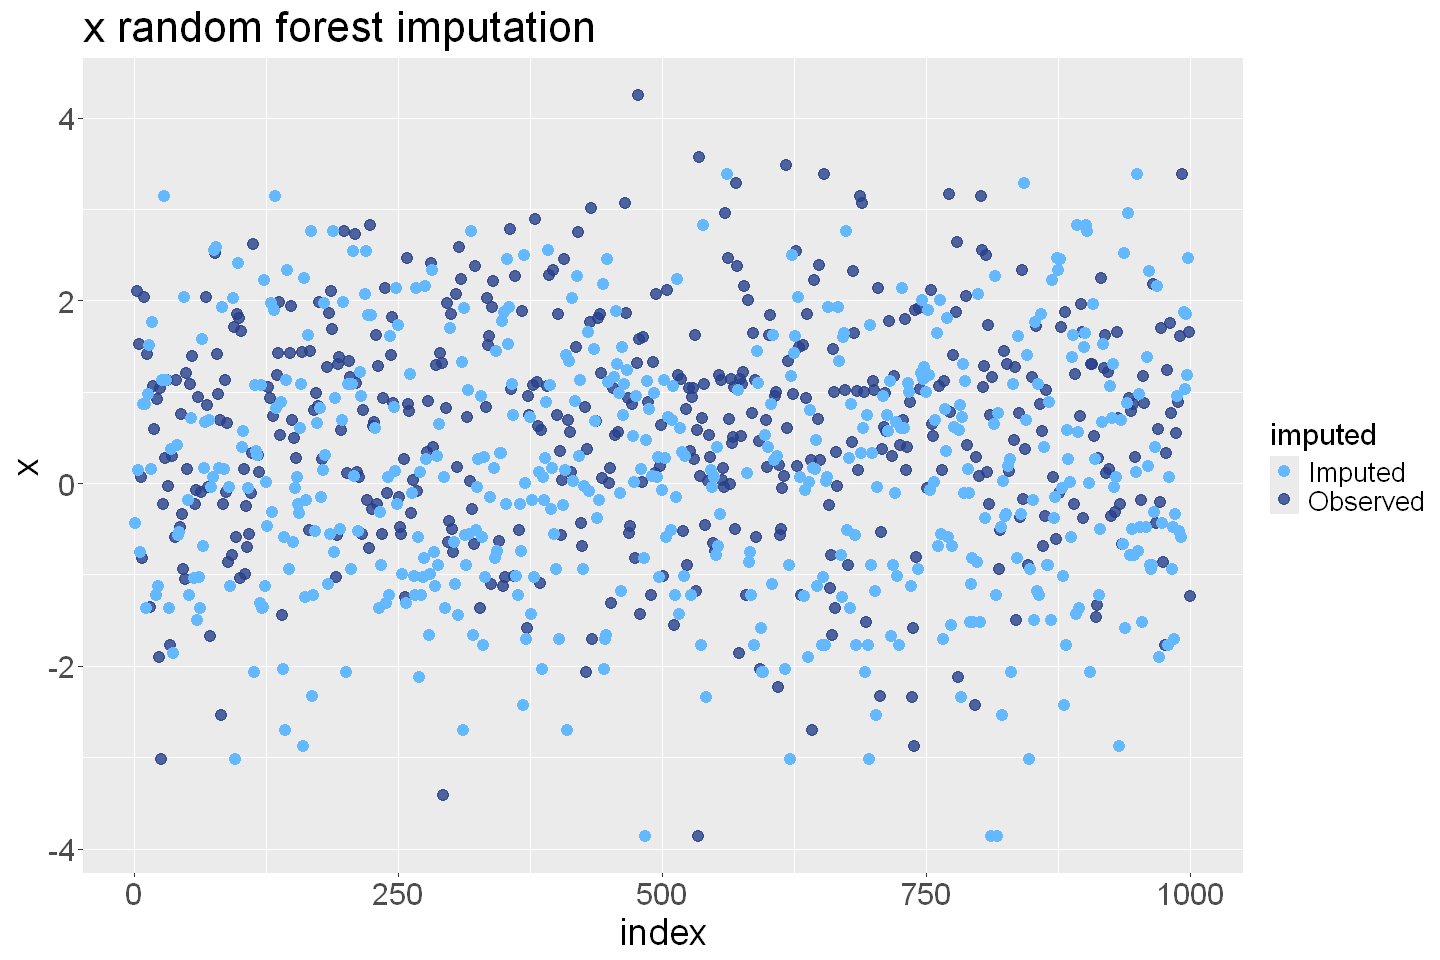

In [76]:
visImpCont(train_num2, test_num2, train_num2_rf, test_num2_rf, "x", "random forest")

In [84]:
head(train_cat1_logreg)

,x,y,z,class,index
,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,-1.3164364,-1.0120654,0,1,2
2,-1.5740428,-0.1080209,1,1,3
3,0.3220095,1.7863004,0,0,4
4,0.6621555,1.3723612,0,0,6
5,2.0510987,1.8395048,1,0,7
6,-0.9502243,-0.7769774,0,1,9


In [81]:
method12 <- c("", "", "logreg", "", "")
train_cat1_logreg <- mice(data = train_cat1, m = 1, maxit = 1, printFlag = FALSE, method = method12, predictorMatrix = predm) %>% complete()
train_cat2_logreg <- mice(data = train_cat2, m = 1, maxit = 1, printFlag = FALSE, method = method12, predictorMatrix = predm) %>% complete()

test_cat1_logreg <- mice(data = test_cat1, m = 1, maxit = 1, printFlag = FALSE, method = method12, predictorMatrix = predm) %>% complete()
test_cat2_logreg <- mice(data = test_cat2, m = 1, maxit = 1, printFlag = FALSE, method = method12, predictorMatrix = predm) %>% complete()

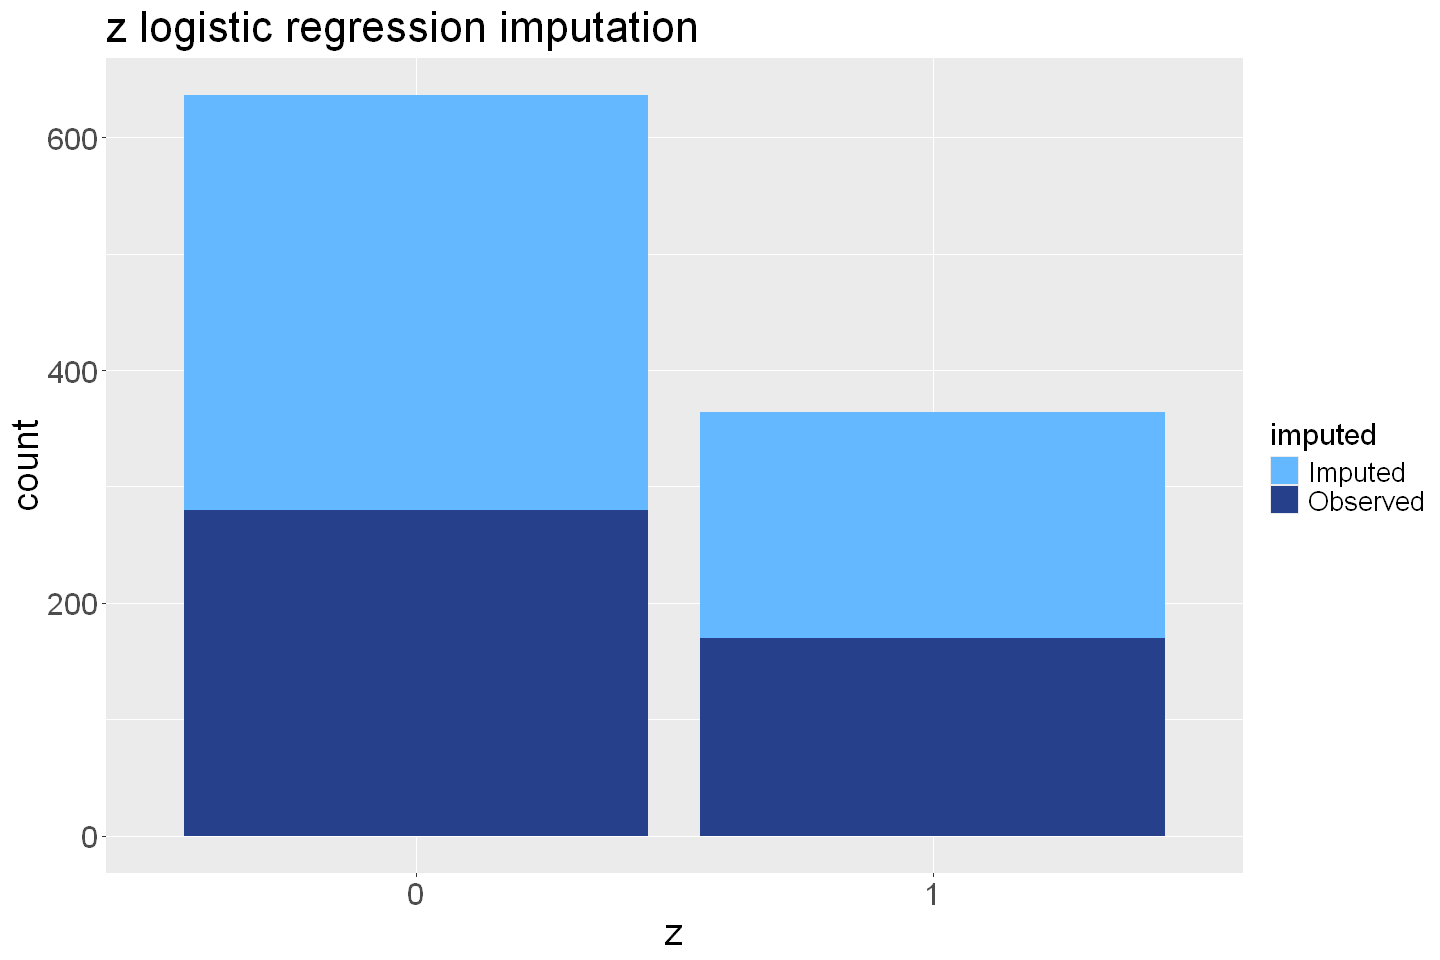

In [86]:
visImpCat(train_cat1, test_cat1, train_cat1_logreg, test_cat1_logreg, "z", "logistic regression")

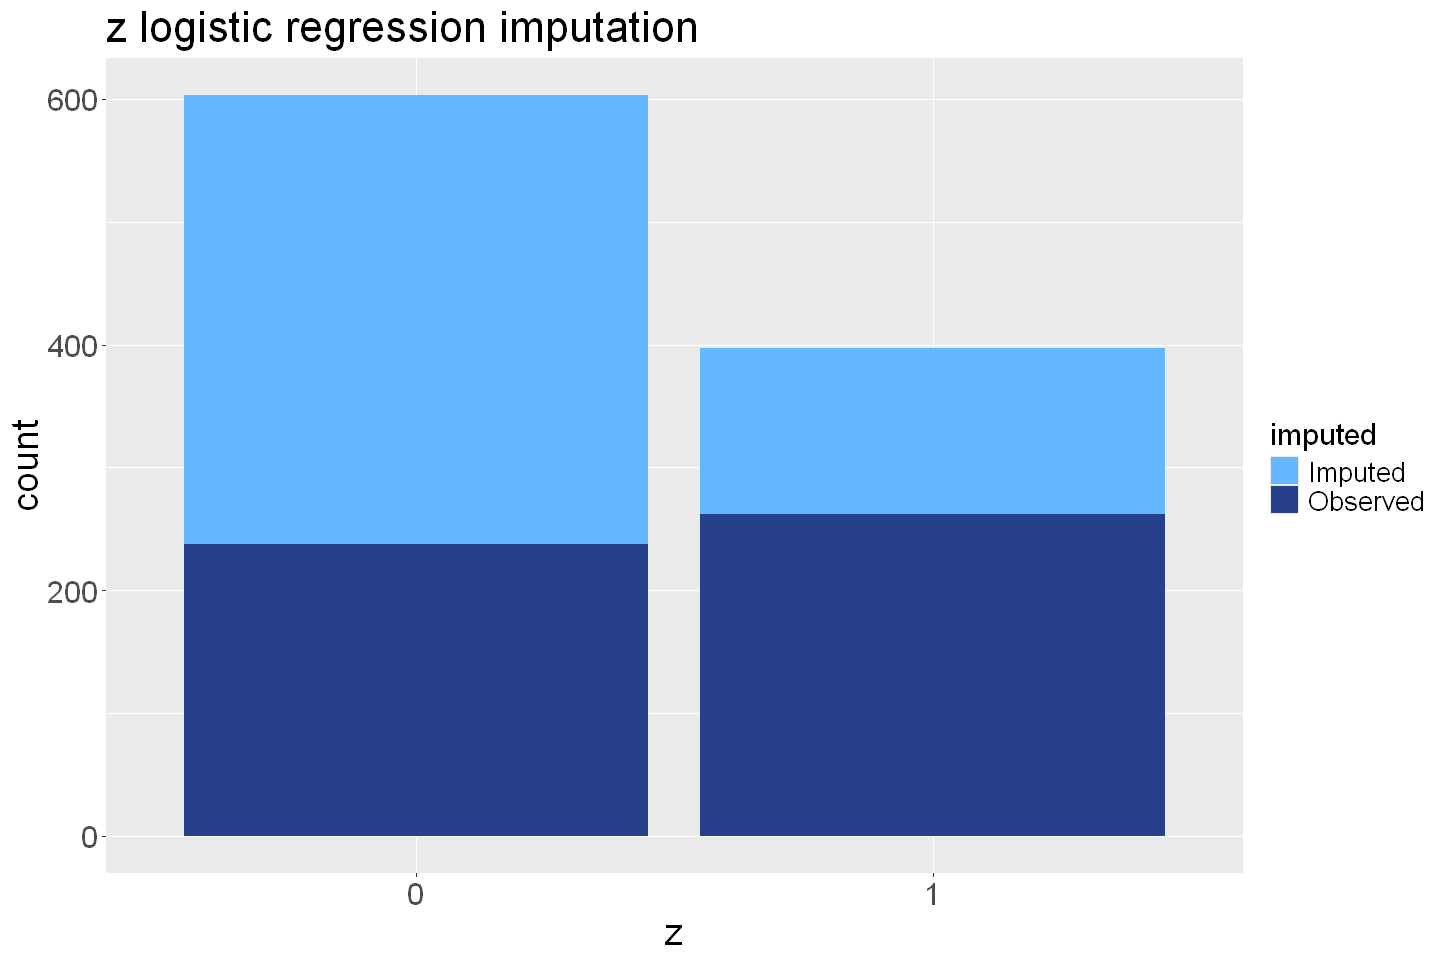

In [87]:
visImpCat(train_cat2, test_cat2, train_cat2_logreg, test_cat2_logreg, "z", "logistic regression")

In [88]:
method13 <- c("", "", "cart", "", "")
train_cat1_dt <- mice(data = train_cat1, m = 1, maxit = 1, printFlag = FALSE, method = method13, predictorMatrix = predm) %>% complete()
train_cat2_dt <- mice(data = train_cat2, m = 1, maxit = 1, printFlag = FALSE, method = method13, predictorMatrix = predm) %>% complete()

test_cat1_dt <- mice(data = test_cat1, m = 1, maxit = 1, printFlag = FALSE, method = method13, predictorMatrix = predm) %>% complete()
test_cat2_dt <- mice(data = test_cat2, m = 1, maxit = 1, printFlag = FALSE, method = method13, predictorMatrix = predm) %>% complete()

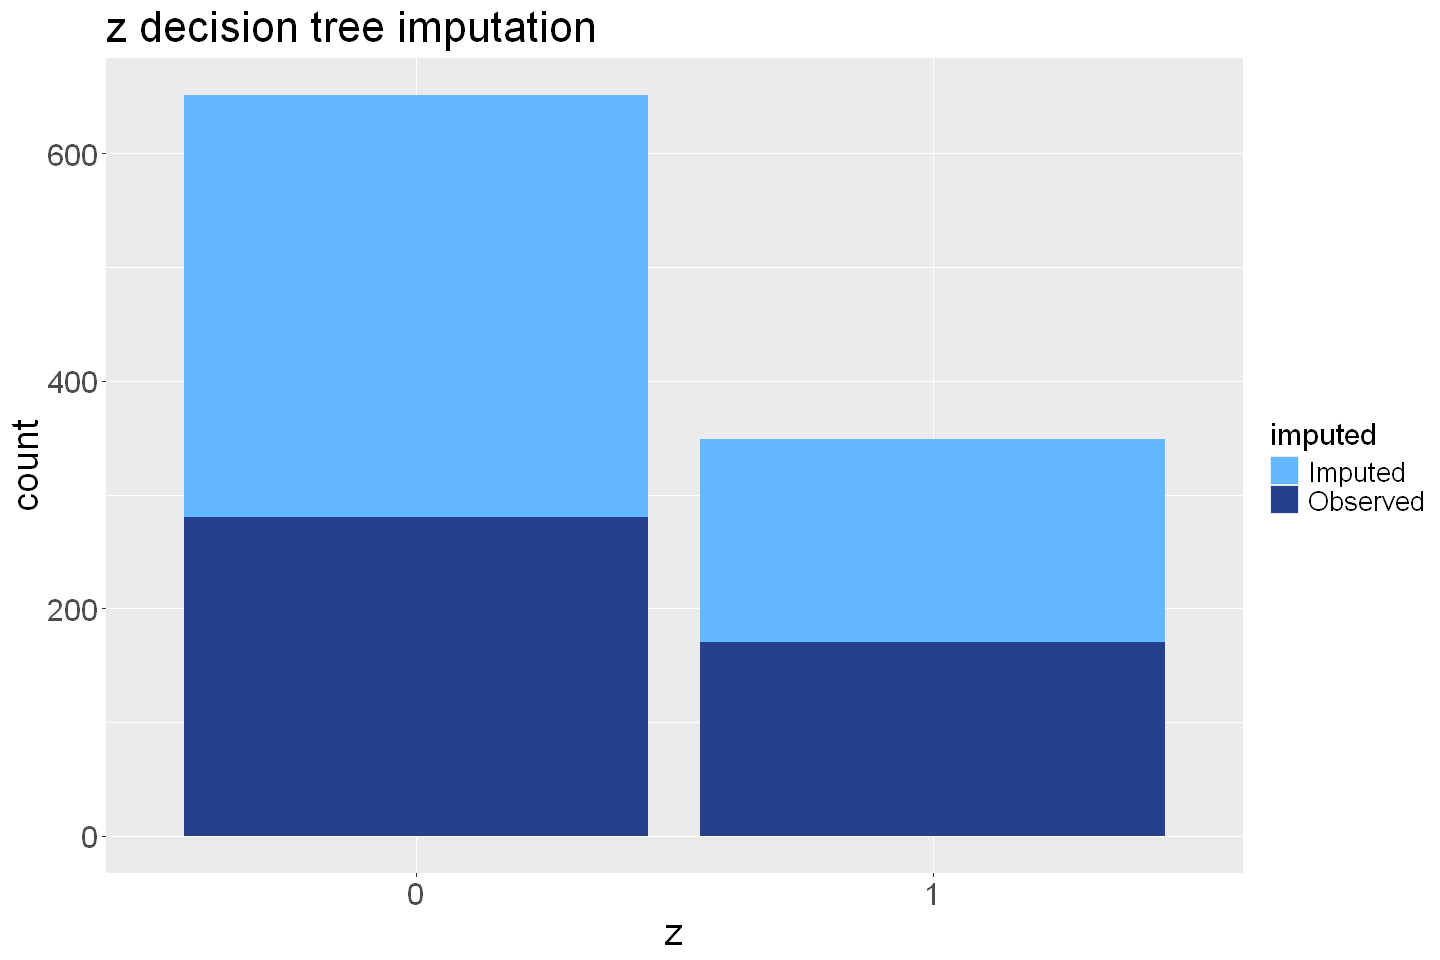

In [90]:
visImpCat(train_cat1, test_cat1, train_cat1_dt, test_cat1_dt, "z", "decision tree")

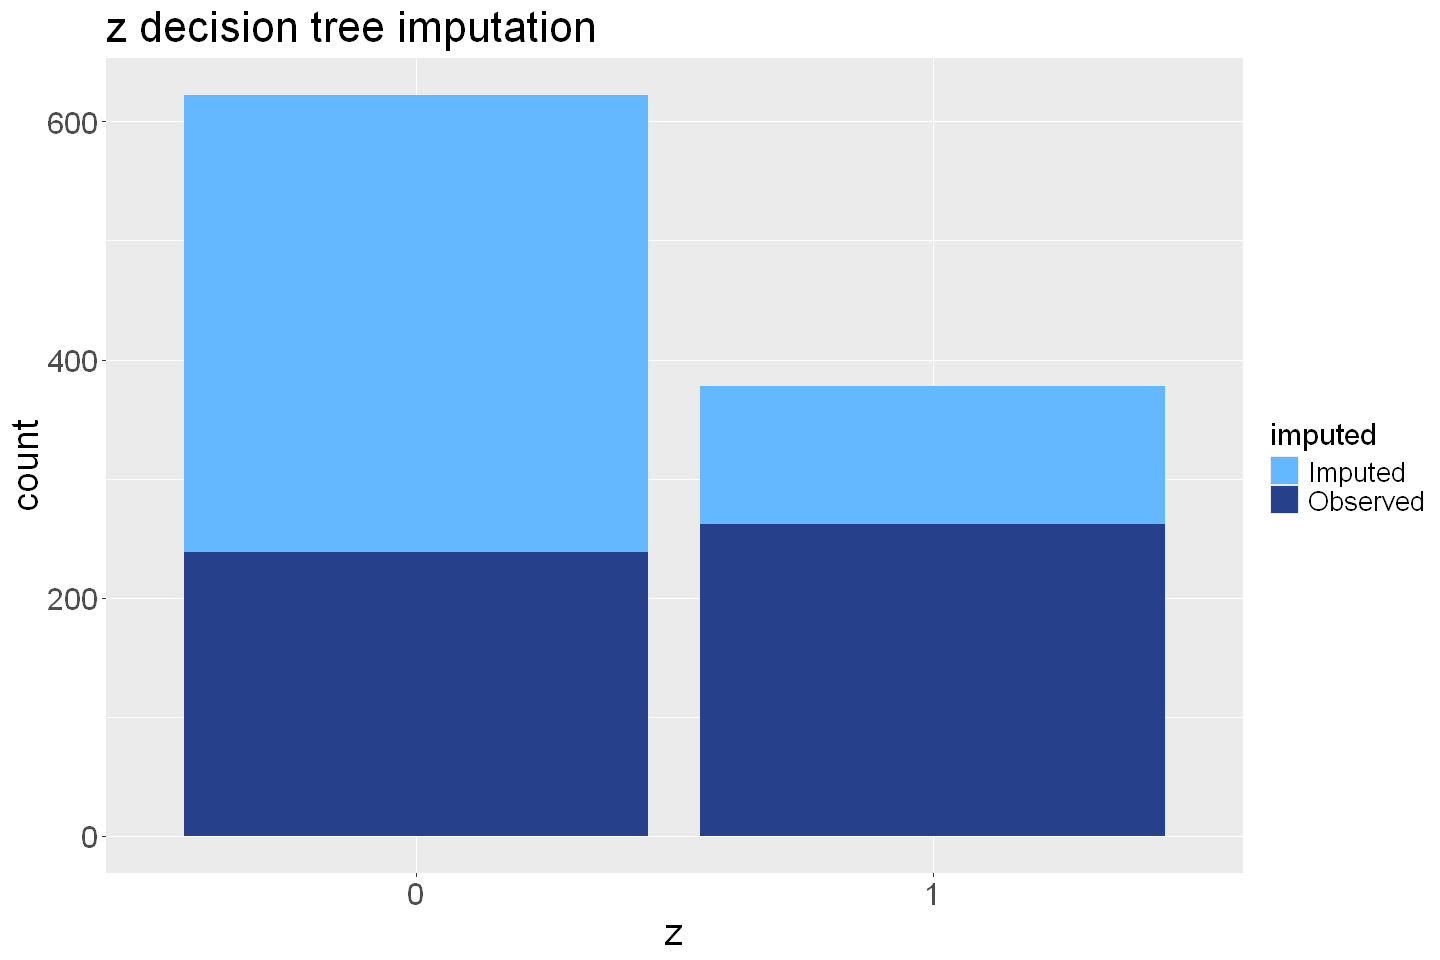

In [91]:
visImpCat(train_cat2, test_cat2, train_cat2_dt, test_cat2_dt, "z", "decision tree")

In [92]:
method14 <- c("", "", "rf", "", "")
train_cat1_rf <- mice(data = train_cat1, m = 1, maxit = 1, printFlag = FALSE, method = method14, predictorMatrix = predm) %>% complete()
train_cat2_rf <- mice(data = train_cat2, m = 1, maxit = 1, printFlag = FALSE, method = method14, predictorMatrix = predm) %>% complete()

test_cat1_rf <- mice(data = test_cat1, m = 1, maxit = 1, printFlag = FALSE, method = method14, predictorMatrix = predm) %>% complete()
test_cat2_rf <- mice(data = test_cat2, m = 1, maxit = 1, printFlag = FALSE, method = method14, predictorMatrix = predm) %>% complete()

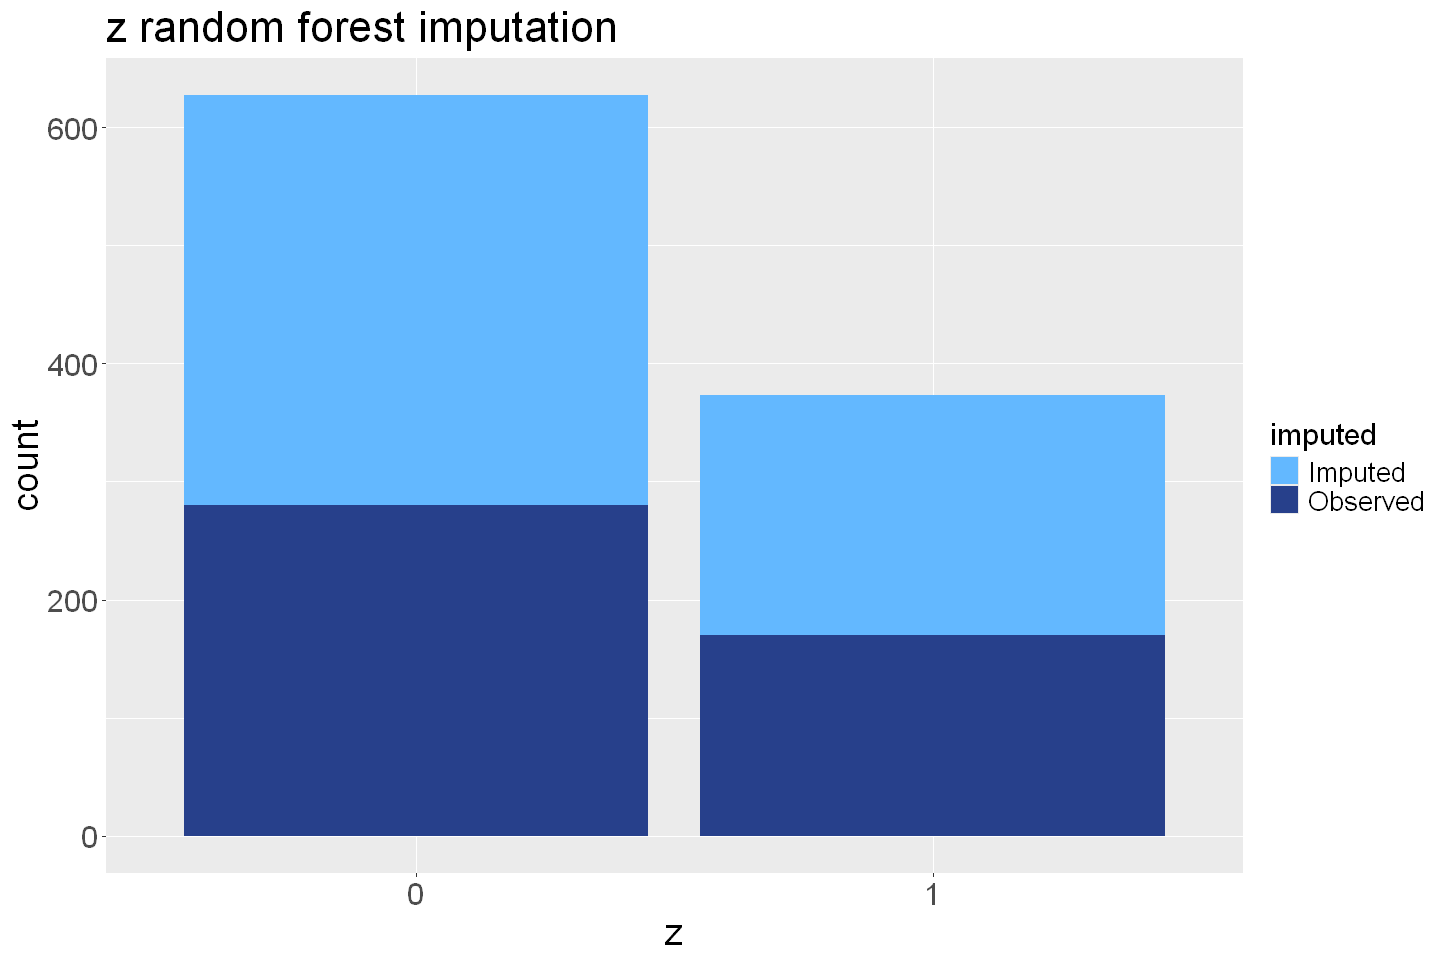

In [93]:
visImpCat(train_cat1, test_cat1, train_cat1_rf, test_cat1_rf, "z", "random forest")

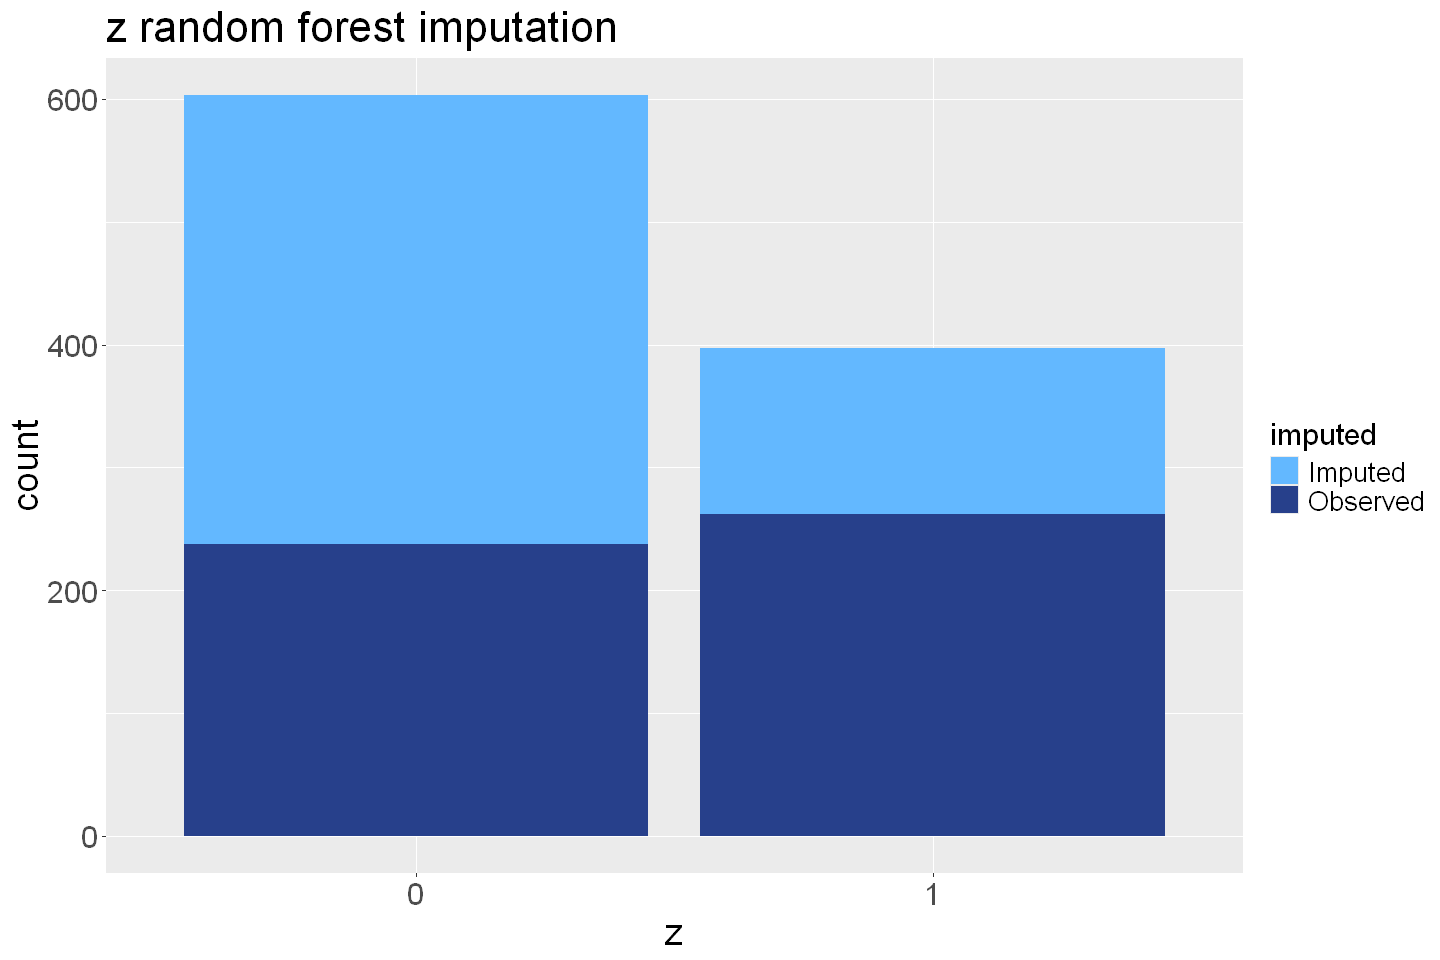

In [94]:
visImpCat(train_cat2, test_cat2, train_cat2_rf, test_cat2_rf, "z", "random forest")

In [95]:
train_cat1_knn <- knnImputation(train_cat1, scale=FALSE)
test_cat1_knn <- knnImputation(test_cat1, scale=FALSE)

train_cat2_knn <- knnImputation(train_cat2, scale=FALSE)
test_cat2_knn <- knnImputation(test_cat2, scale=FALSE)

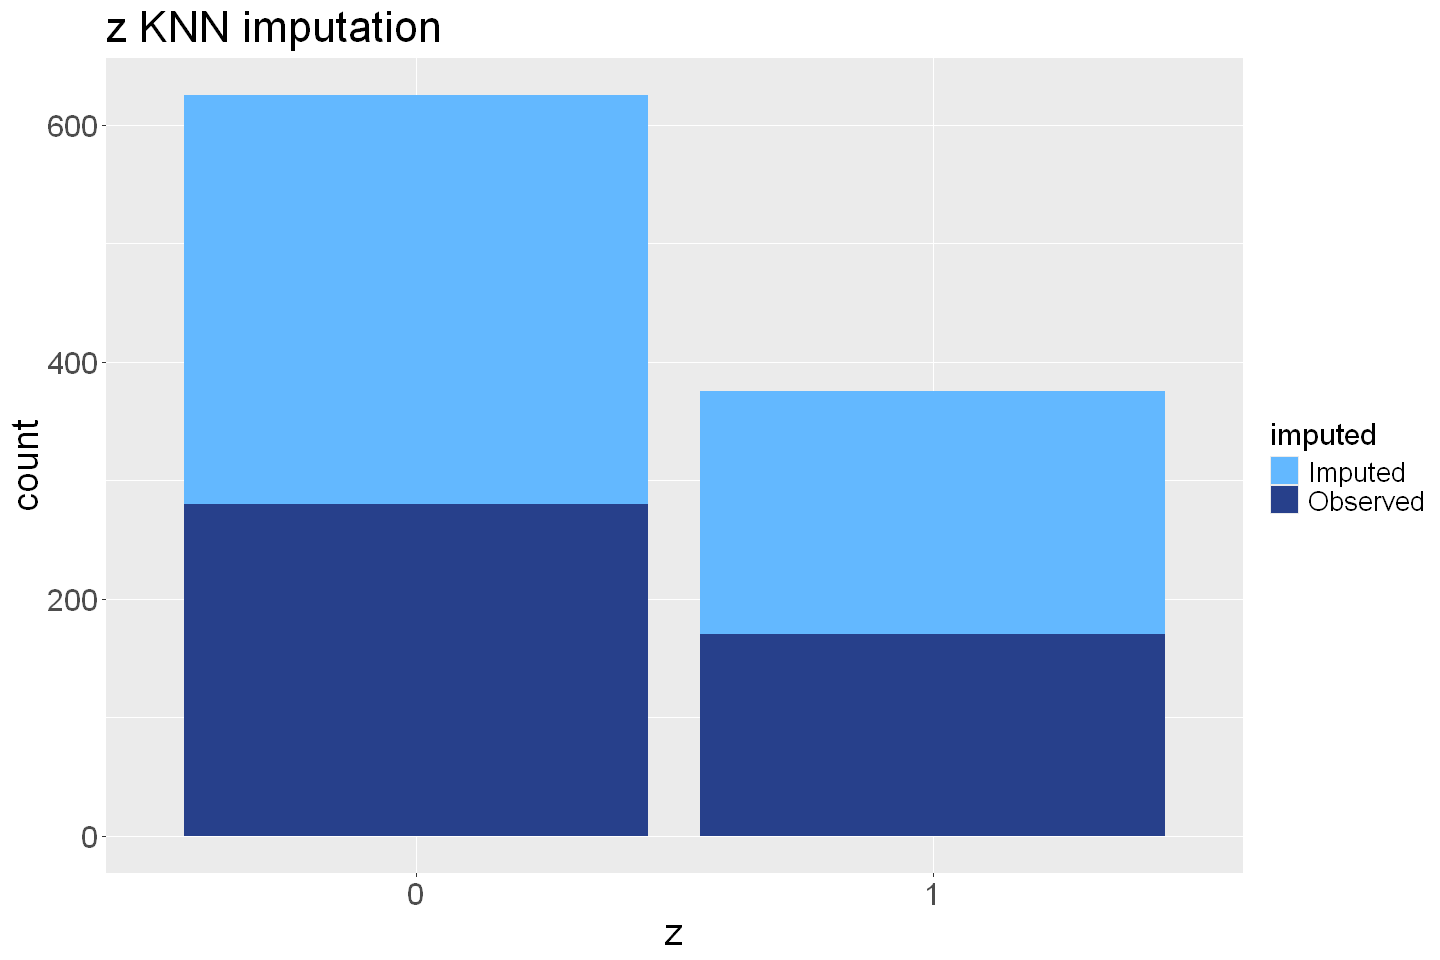

In [96]:
visImpCat(train_cat1, test_cat1, train_cat1_knn, test_cat1_knn, "z", "KNN")

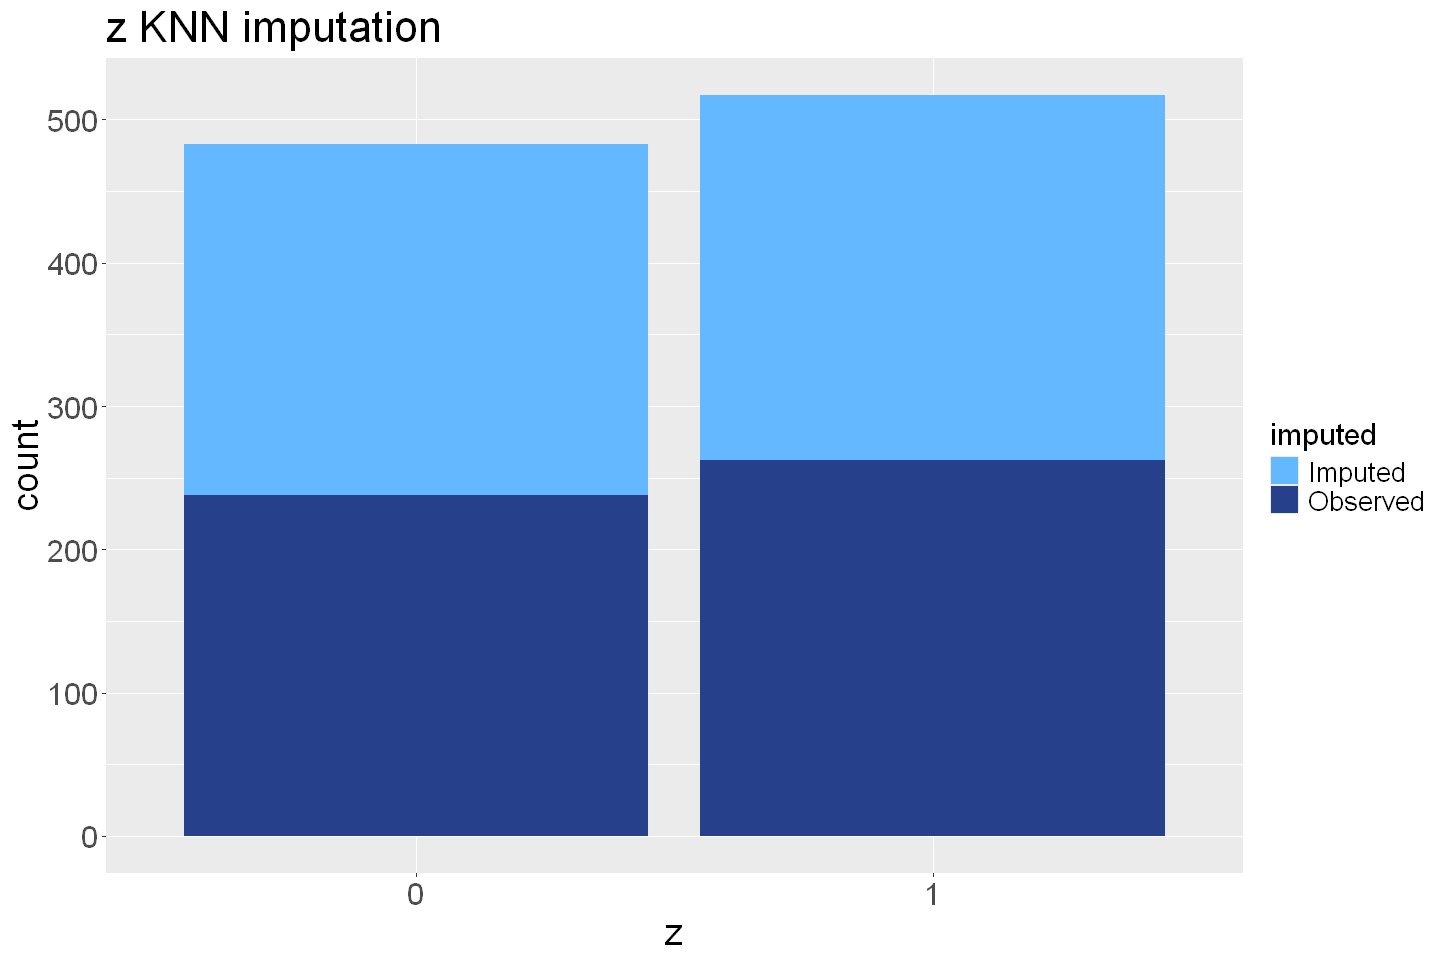

In [97]:
visImpCat(train_cat2, test_cat2, train_cat2_knn, test_cat2_knn, "z", "KNN")

In [106]:
train_cat1_stack <- rbind(train_cat1, train_cat1, train_cat1, train_cat1)
test_cat1_stack <- rbind(test_cat1, test_cat1, test_cat1, test_cat1)
train_cat2_stack <- rbind(train_cat2, train_cat2, train_cat2, train_cat2)
test_cat2_stack <- rbind(test_cat2, test_cat2, test_cat2, test_cat2)

In [101]:
newtrain_cat1 <- data.frame(z=train_cat1$z, class=train_cat1$class, x=train_cat1$x, y=train_cat1$y)
newtrain_cat1$z <- as.integer(newtrain_cat1$z)
newtrain_cat1$class <- as.integer(newtrain_cat1$class)
train_cat1_mlmi <- mixImp(obsData = newtrain_cat1, M = 4, nCat = 2, rseed = 1234)
newtest_cat1 <- data.frame(z=test_cat1$z, class=test_cat1$class, x=test_cat1$x, y=test_cat1$y)
newtest_cat1$z <- as.integer(newtest_cat1$z)
newtest_cat1$class <- as.integer(newtest_cat1$class)
test_cat1_mlmi <- mixImp(obsData = newtest_cat1, M = 4, nCat = 2, rseed = 1234)
for (i in 1:4) {
    train_cat1_mlmi[[i]]$z <- as.factor(ifelse(train_cat1_mlmi[[i]]$z == "2", 1, 0))
    train_cat1_mlmi[[i]]$class <- as.factor(ifelse(train_cat1_mlmi[[i]]$class == "2", 1, 0))
    test_cat1_mlmi[[i]]$z <- as.factor(ifelse(test_cat1_mlmi[[i]]$z == "2", 1, 0))
    test_cat1_mlmi[[i]]$class <- as.factor(ifelse(test_cat1_mlmi[[i]]$class == "2", 1, 0))
}

Imputing categorical variables using all 2-way associations.

Imputing continuous variables assuming main effects of categorical variables



Steps of ECM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...


Imputing categorical variables using all 2-way associations.

Imputing continuous variables assuming main effects of categorical variables



Steps of ECM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...


In [102]:
train_cat1_mlmi_con <- bind_rows(train_cat1_mlmi, .id = ".imp")
train_cat1_mlmi_con$.imp <- as.integer(train_cat1_mlmi_con$.imp)
    
test_cat1_mlmi_con <- bind_rows(test_cat1_mlmi, .id = ".imp")
test_cat1_mlmi_con$.imp <- as.integer(test_cat1_mlmi_con$.imp)

In [107]:
train_cat1_mlmi_con$index <- train_cat1_stack$index
test_cat1_mlmi_con$index <- test_cat1_stack$index

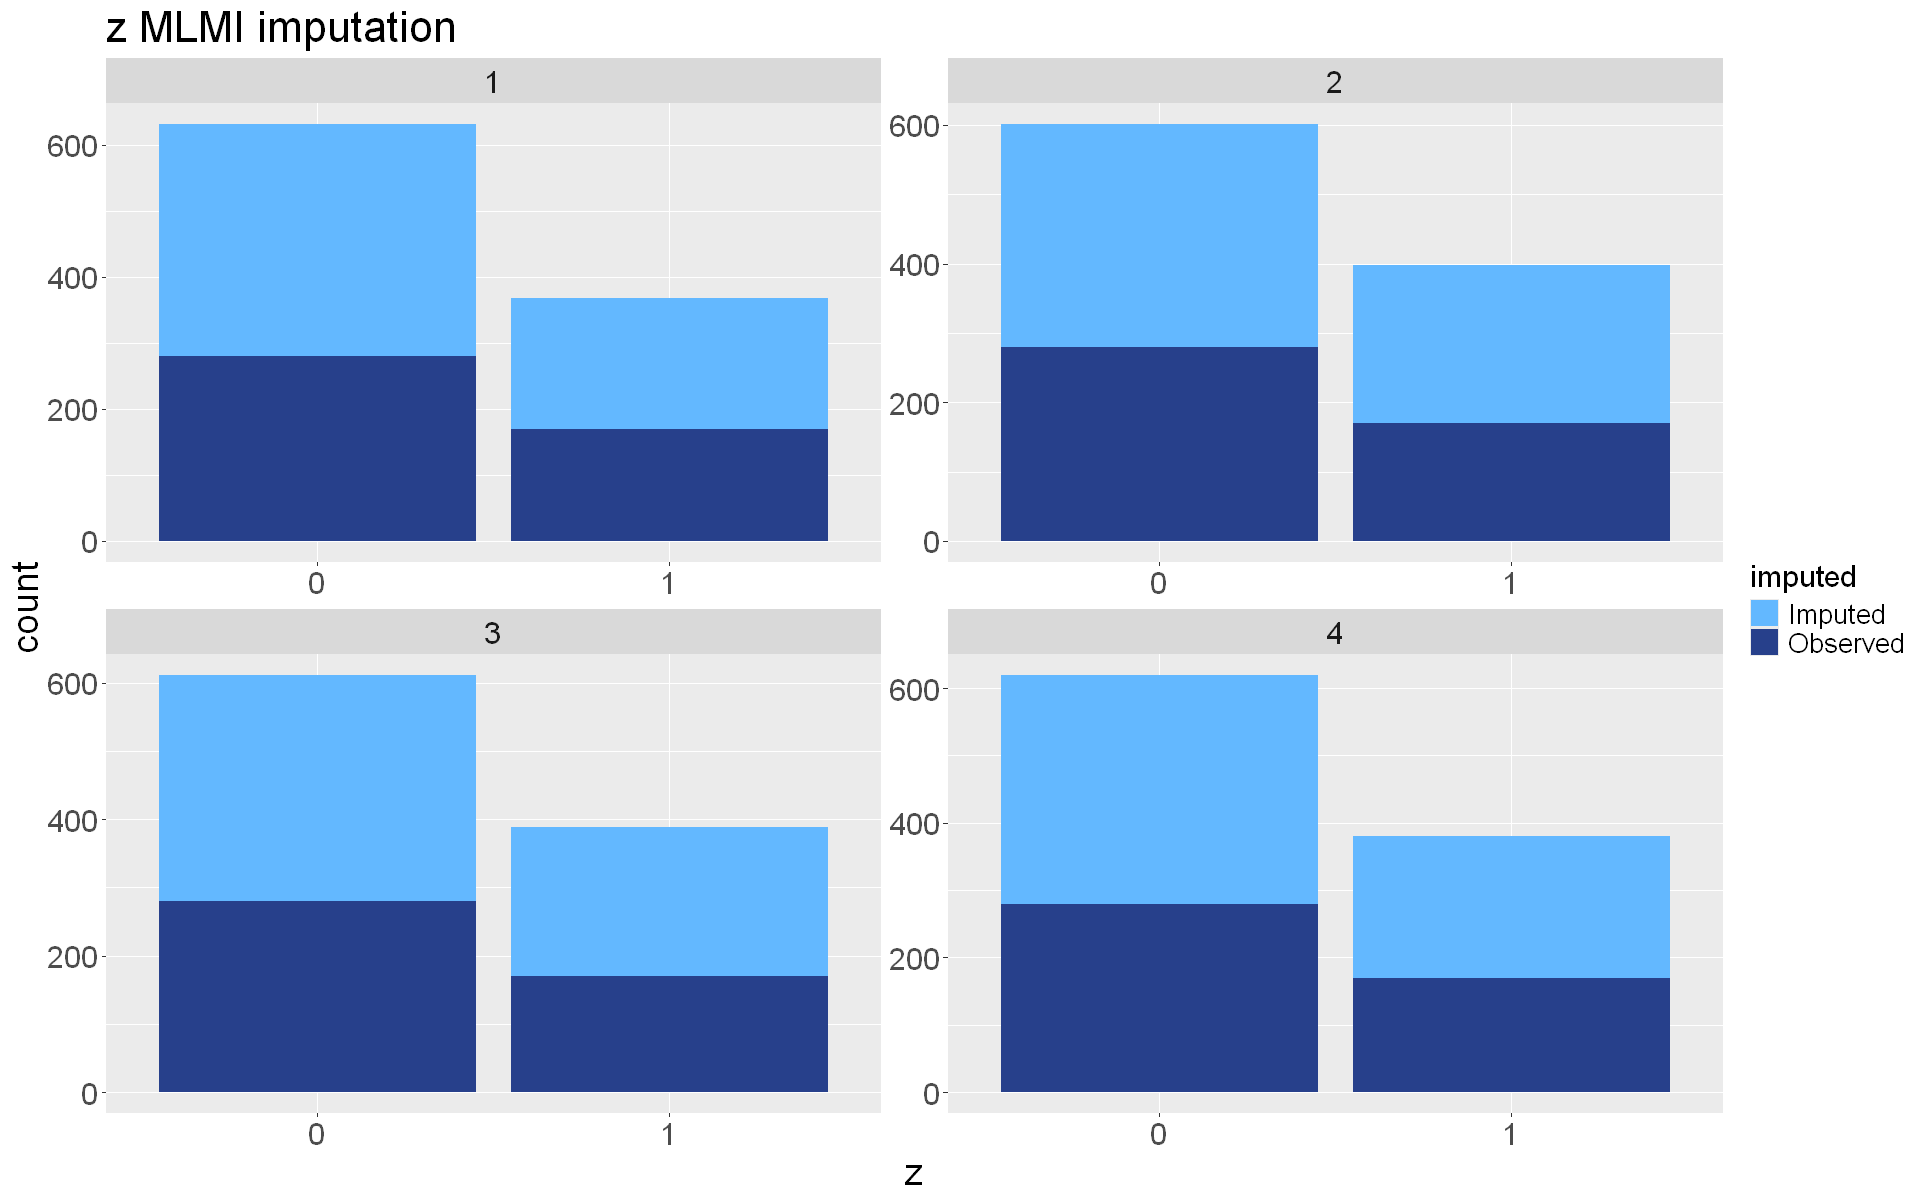

In [108]:
options(repr.plot.width = 16, repr.plot.height = 10)
visImpMulCat(train_cat1_stack, test_cat1_stack, train_cat1_mlmi_con, test_cat1_mlmi_con, "z", "MLMI")

In [109]:
newtrain_cat2 <- data.frame(z=train_cat2$z, class=train_cat2$class, x=train_cat2$x, y=train_cat2$y)
newtrain_cat2$z <- as.integer(newtrain_cat2$z)
newtrain_cat2$class <- as.integer(newtrain_cat2$class)
train_cat2_mlmi <- mixImp(obsData = newtrain_cat2, M = 4, nCat = 2, rseed = 1234)
newtest_cat2 <- data.frame(z=test_cat2$z, class=test_cat2$class, x=test_cat2$x, y=test_cat2$y)
newtest_cat2$z <- as.integer(newtest_cat2$z)
newtest_cat2$class <- as.integer(newtest_cat2$class)
test_cat2_mlmi <- mixImp(obsData = newtest_cat2, M = 4, nCat = 2, rseed = 1234)
for (i in 1:4) {
    train_cat2_mlmi[[i]]$z <- as.factor(ifelse(train_cat2_mlmi[[i]]$z == "2", 1, 0))
    train_cat2_mlmi[[i]]$class <- as.factor(ifelse(train_cat2_mlmi[[i]]$class == "2", 1, 0))
    test_cat2_mlmi[[i]]$z <- as.factor(ifelse(test_cat2_mlmi[[i]]$z == "2", 1, 0))
    test_cat2_mlmi[[i]]$class <- as.factor(ifelse(test_cat2_mlmi[[i]]$class == "2", 1, 0))
}

Imputing categorical variables using all 2-way associations.

Imputing continuous variables assuming main effects of categorical variables



Steps of ECM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...


Imputing categorical variables using all 2-way associations.

Imputing continuous variables assuming main effects of categorical variables



Steps of ECM: 
1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...


In [110]:
train_cat2_mlmi_con <- bind_rows(train_cat2_mlmi, .id = ".imp")
train_cat2_mlmi_con$.imp <- as.integer(train_cat2_mlmi_con$.imp)
    
test_cat2_mlmi_con <- bind_rows(test_cat2_mlmi, .id = ".imp")
test_cat2_mlmi_con$.imp <- as.integer(test_cat2_mlmi_con$.imp)

In [111]:
train_cat2_mlmi_con$index <- train_cat2_stack$index
test_cat2_mlmi_con$index <- test_cat2_stack$index

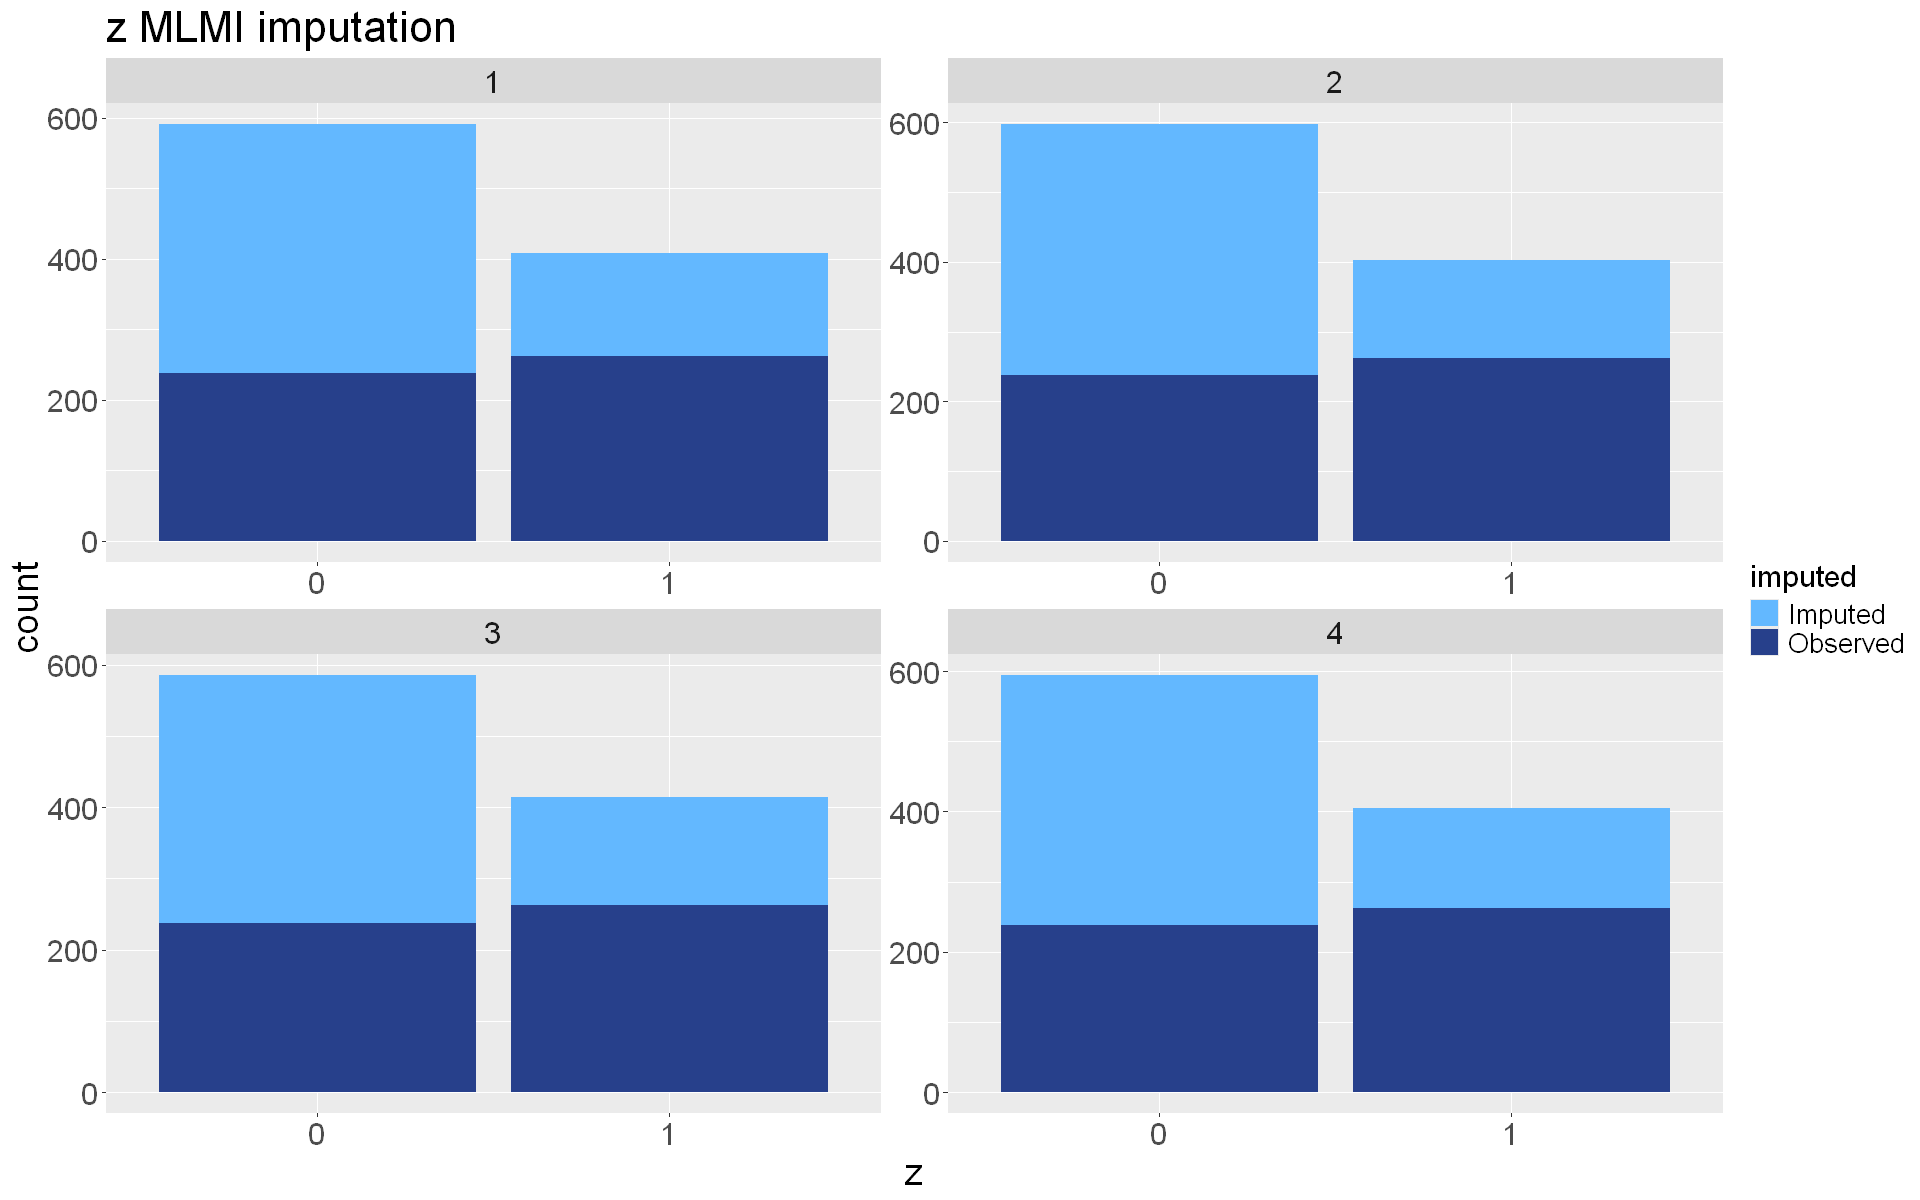

In [112]:
visImpMulCat(train_cat2_stack, test_cat2_stack, train_cat2_mlmi_con, test_cat2_mlmi_con, "z", "MLMI")

In [18]:
method17 <- c("ri", "", "", "", "")
train_num3_ri <- mice(data = train_num3, m = 1, maxit = 1, printFlag = FALSE, method = method17, predictorMatrix = predm) %>% complete()
test_num3_ri <- mice(data = test_num3, m = 1, maxit = 1, printFlag = FALSE, method = method17, predictorMatrix = predm) %>% complete()

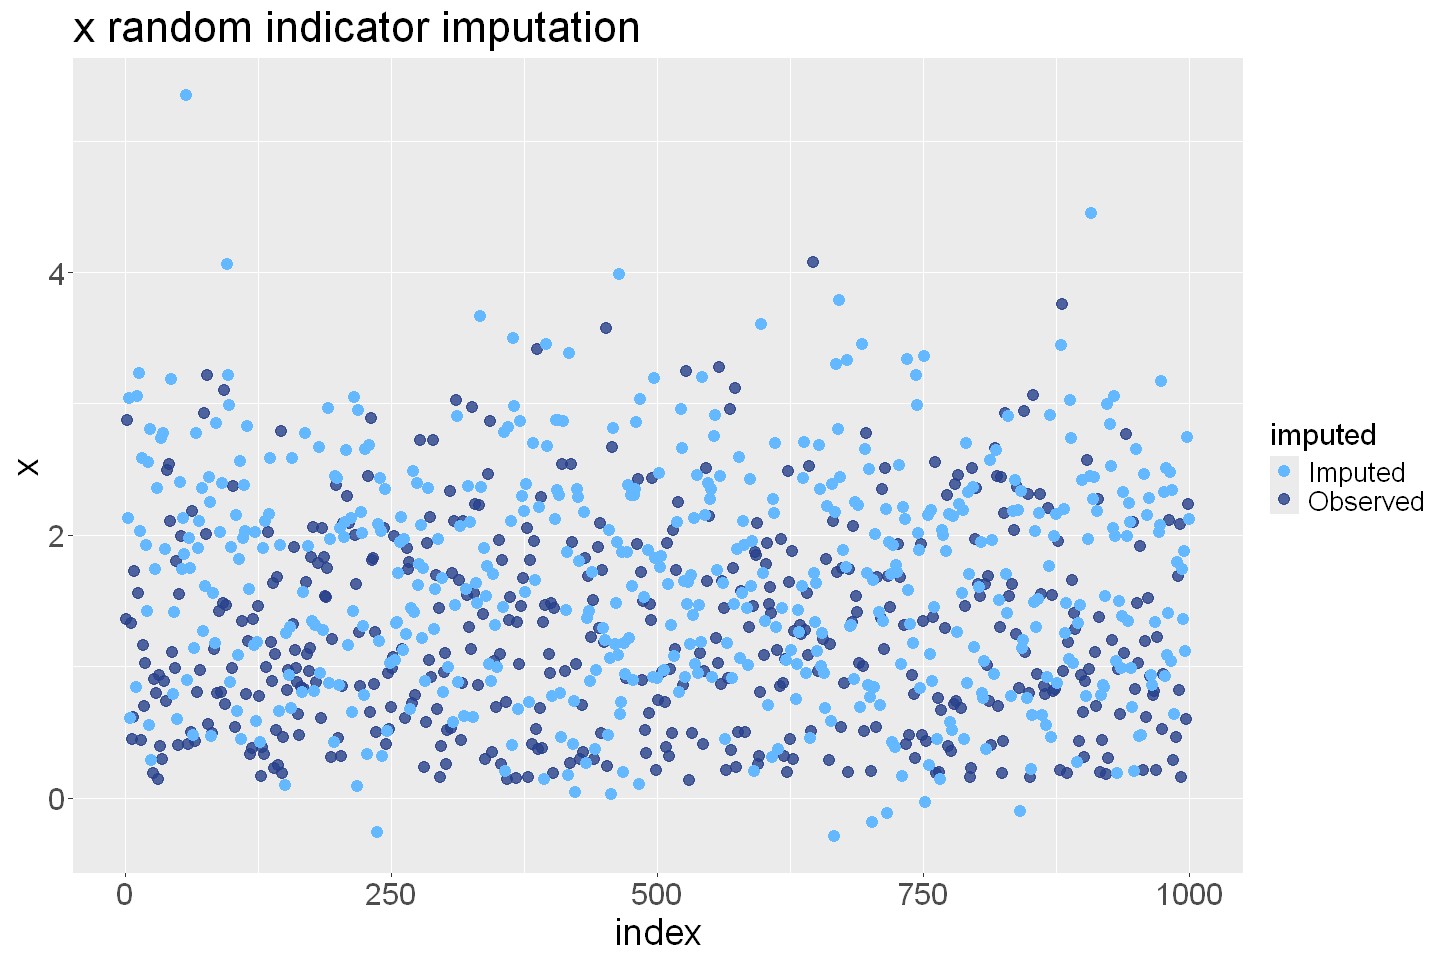

In [19]:
options(repr.plot.width = 12, repr.plot.height = 8)
visImpCont(train_num3, test_num3, train_num3_ri, test_num3_ri, "x", "random indicator")

In [21]:
method18 <- c("", "", "ri", "", "")
train_cat3_num <- train_cat3
test_cat3_num <- test_cat3
train_cat3_num$z <- as.numeric(as.character(train_cat3_num$z))
test_cat3_num$z <- as.numeric(as.character(test_cat3_num$z))

train_cat3_mice_ri <- mice(data = train_cat3_num, m = 1, maxit = 1, printFlag = FALSE, method = method18, predictorMatrix = predm) %>% complete()
test_cat3_mice_ri <- mice(data = test_cat3_num, m = 1, maxit = 1, printFlag = FALSE, method = method18, predictorMatrix = predm) %>% complete()

In [22]:
train_cat3_mice_ri$z <- rescale(train_cat3_mice_ri$z)
train_cat3_mice_ri$z <- ifelse(train_cat3_mice_ri$z > 0.5, 1, 0)
train_cat3_mice_ri$z <- as.factor(train_cat3_mice_ri$z)

test_cat3_mice_ri$z <- rescale(test_cat3_mice_ri$z)
test_cat3_mice_ri$z <- ifelse(test_cat3_mice_ri$z > 0.5, 1, 0)
test_cat3_mice_ri$z <- as.factor(test_cat3_mice_ri$z)

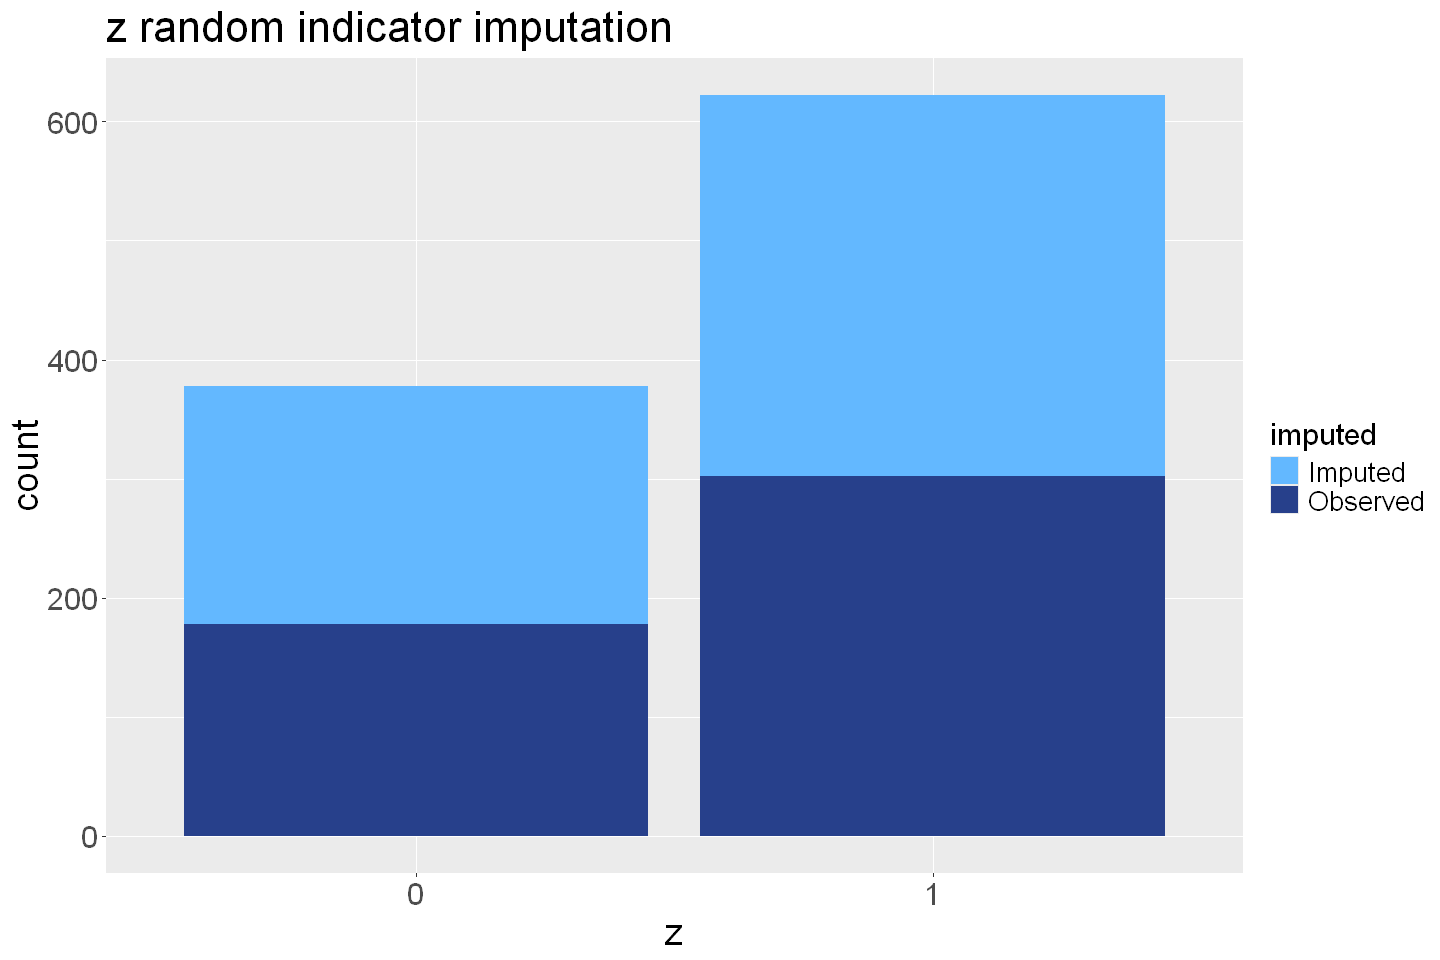

In [26]:
visImpCat(train_cat3, test_cat3, train_cat3_mice_ri, test_cat3_mice_ri, "z", "random indicator")

In [40]:
method19 <- c("mnar.norm", "", "", "", "", "")
train_num3_narfcs <- train_num3
test_num3_narfcs <- test_num3
train_num3_narfcs$x_miss <- ifelse(is.na(train_num3_narfcs$x), 1, 0)
test_num3_narfcs$x_miss <- ifelse(is.na(test_num3_narfcs$x), 1, 0)
predm2 <- make.predictorMatrix(train_num3_narfcs)
predm2[, "index"] <- 0

In [31]:
num3$x_miss <- ifelse(is.na(num3$x), 1, 0)
base_blots <- list(x = list(ums = "+$"))
elicited <- c(delta_num)
l <- list(delta_num-abs(2*delta_num))
u <- list(delta_num+abs(2*delta_num))
tol <- c(abs(delta_num / 10))
parms <- rep(list(list(NA)), 1)
names(parms) <- c("x")
step <- list(abs(delta_num / 10))
MSPfamily <- "gaussian"
MSPmodels <- "x~x_miss"
m <- 4
maxit <- 10
csp <- find_CSP(num3, base_blots, elicited, l, u, MSPmodels, MSPfamily, step, tol, parms, m, maxit, method19, 1234, predm2)
blots <- newblots(base_blots, list(x=csp))

Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning messa

In [37]:
train_num3_narfcs_imp <- mice(data = train_num3_narfcs, m = 4, maxit = 10, printFlag = FALSE, method = method19, predictorMatrix = predm2, blots=blots) %>% complete(action="long")
test_num3_narfcs_imp <- mice(data = test_num3_narfcs, m = 4, maxit = 10, printFlag = FALSE, method = method19, predictorMatrix = predm2, blots=blots) %>% complete(action="long")

Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"


In [41]:
train_num3_narfcs_stack <- rbind(train_num3_narfcs, train_num3_narfcs, train_num3_narfcs, train_num3_narfcs)
test_num3_narfcs_stack <- rbind(test_num3_narfcs, test_num3_narfcs, test_num3_narfcs, test_num3_narfcs)

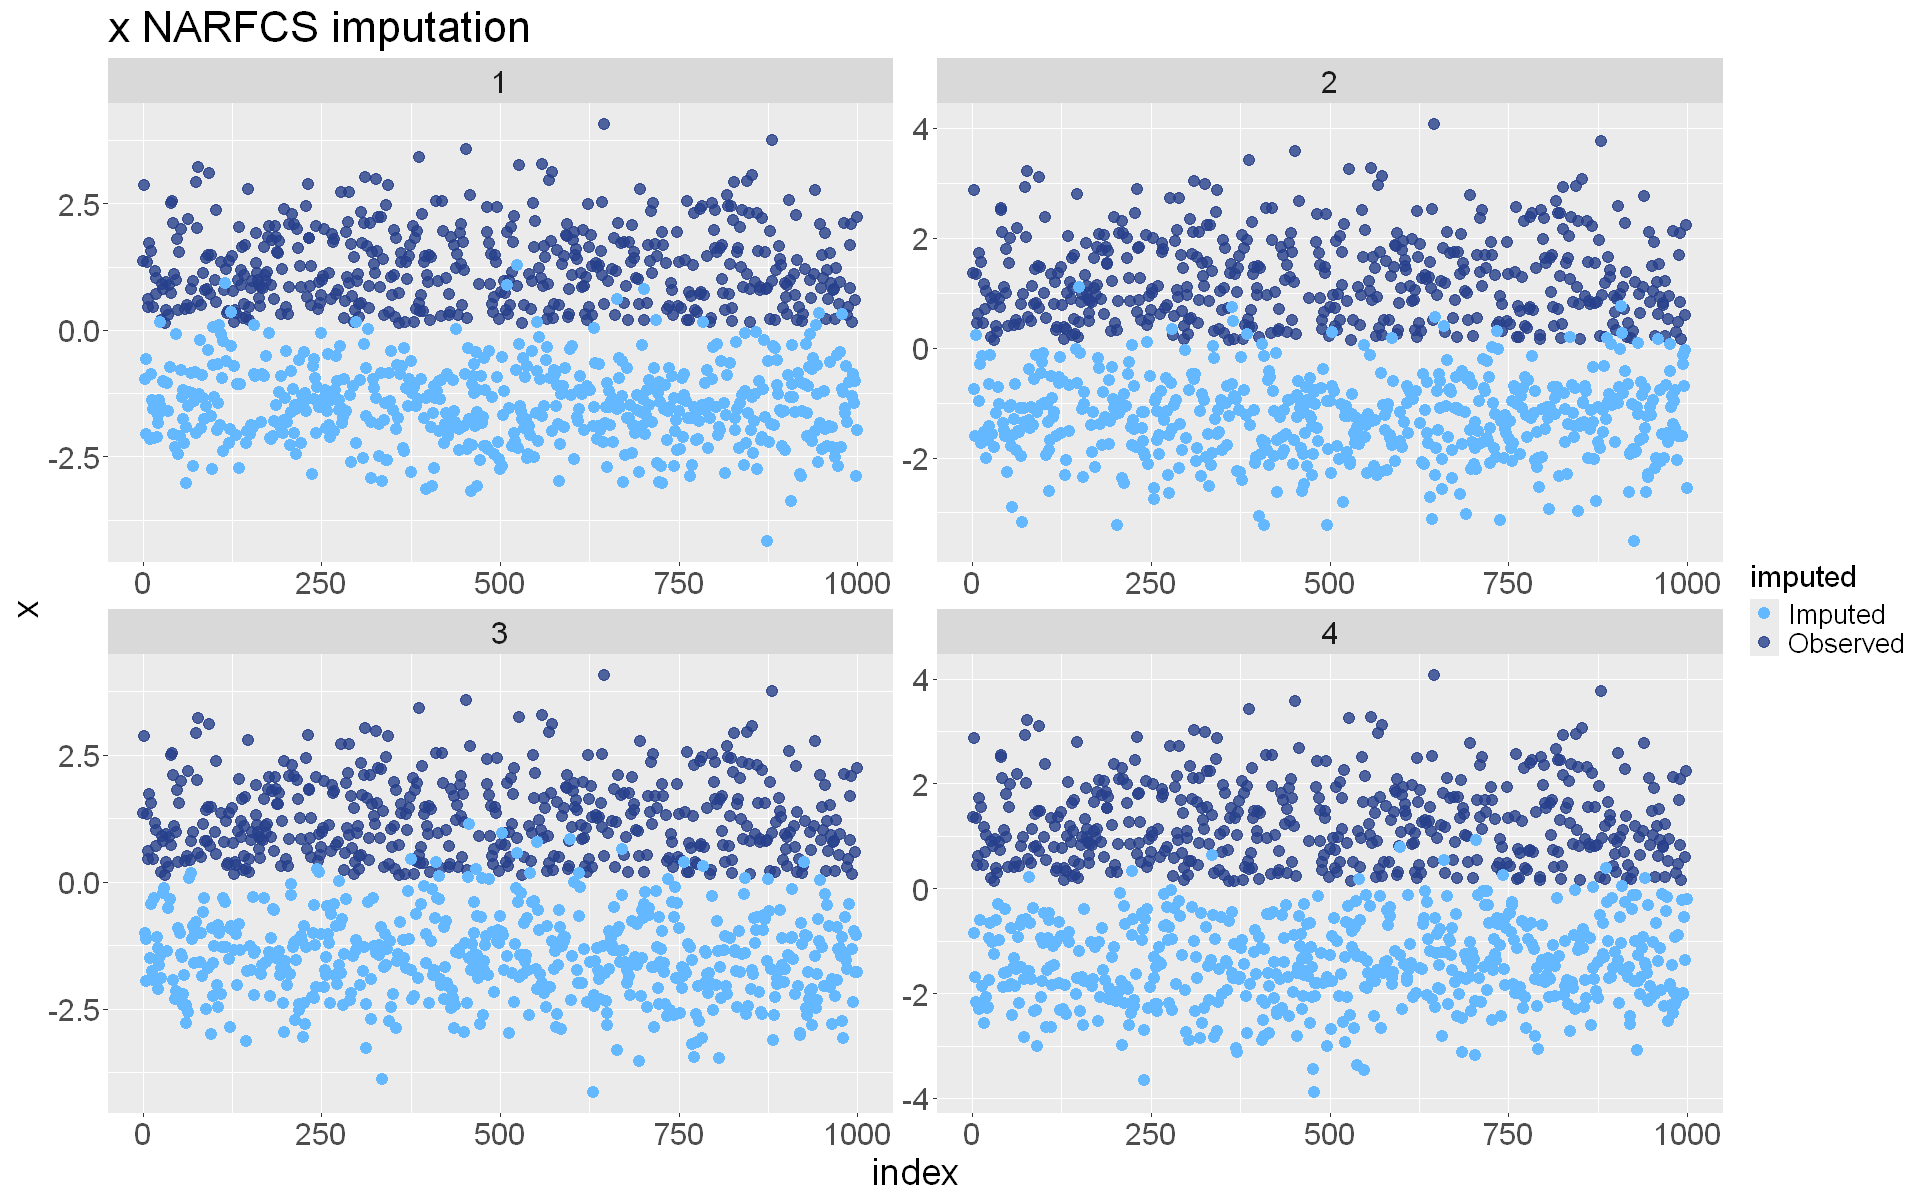

In [54]:
options(repr.plot.width = 16, repr.plot.height = 10)
visImpMul(train_num3_narfcs_stack, test_num3_narfcs_stack, train_num3_narfcs_imp, test_num3_narfcs_imp, "x", "NARFCS")

In [48]:
method20 <- c("", "", "mnar.logreg", "", "", "")
train_cat3_narfcs <- train_cat3
test_cat3_narfcs <- test_cat3
train_cat3_narfcs$z_miss <- ifelse(is.na(train_cat3_narfcs$z), 1, 0)
test_cat3_narfcs$z_miss <- ifelse(is.na(test_cat3_narfcs$z), 1, 0)
predm3 <- make.predictorMatrix(train_cat3_narfcs)
predm2[, "index"] <- 0

In [49]:
cat3$z_miss <- ifelse(is.na(cat3$z), 1, 0)
base_blots <- list(z = list(ums = "+$"))
elicited <- c(delta_cat)
l <- list(delta_cat-abs(2*delta_cat))
u <- list(delta_cat+abs(2*delta_cat))
tol <- c(abs(delta_cat / 10))
parms <- rep(list(list(NA)), 1)
names(parms) <- c("z")
step <- list(abs(delta_cat / 10))
MSPfamily <- "binomial"
MSPmodels <- "z~z_miss"
m <- 4
maxit <- 10
csp <- find_CSP(cat3, base_blots, elicited, l, u, MSPmodels, MSPfamily, step, tol, parms, m, maxit, method20, 1234, predm3)
blots <- newblots(base_blots, list(z=csp))

Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"
Warning messa

In [50]:
blots

$z
$z$ums
[1] "-5.85094693268785"

In [51]:
train_cat3_narfcs_imp <- mice(data = train_cat3_narfcs, m = 4, maxit = 10, printFlag = FALSE, method = method20, predictorMatrix = predm3, blots=blots) %>% complete(action="long")
test_cat3_narfcs_imp <- mice(data = test_cat3_narfcs, m = 4, maxit = 10, printFlag = FALSE, method = method20, predictorMatrix = predm3, blots=blots) %>% complete(action="long")

Warning message:
"Number of logged events: 40"
Warning message:
"Number of logged events: 40"


In [52]:
train_cat3_narfcs_stack <- rbind(train_cat3_narfcs, train_cat3_narfcs, train_cat3_narfcs, train_cat3_narfcs)
test_cat3_narfcs_stack <- rbind(test_cat3_narfcs, test_cat3_narfcs, test_cat3_narfcs, test_cat3_narfcs)

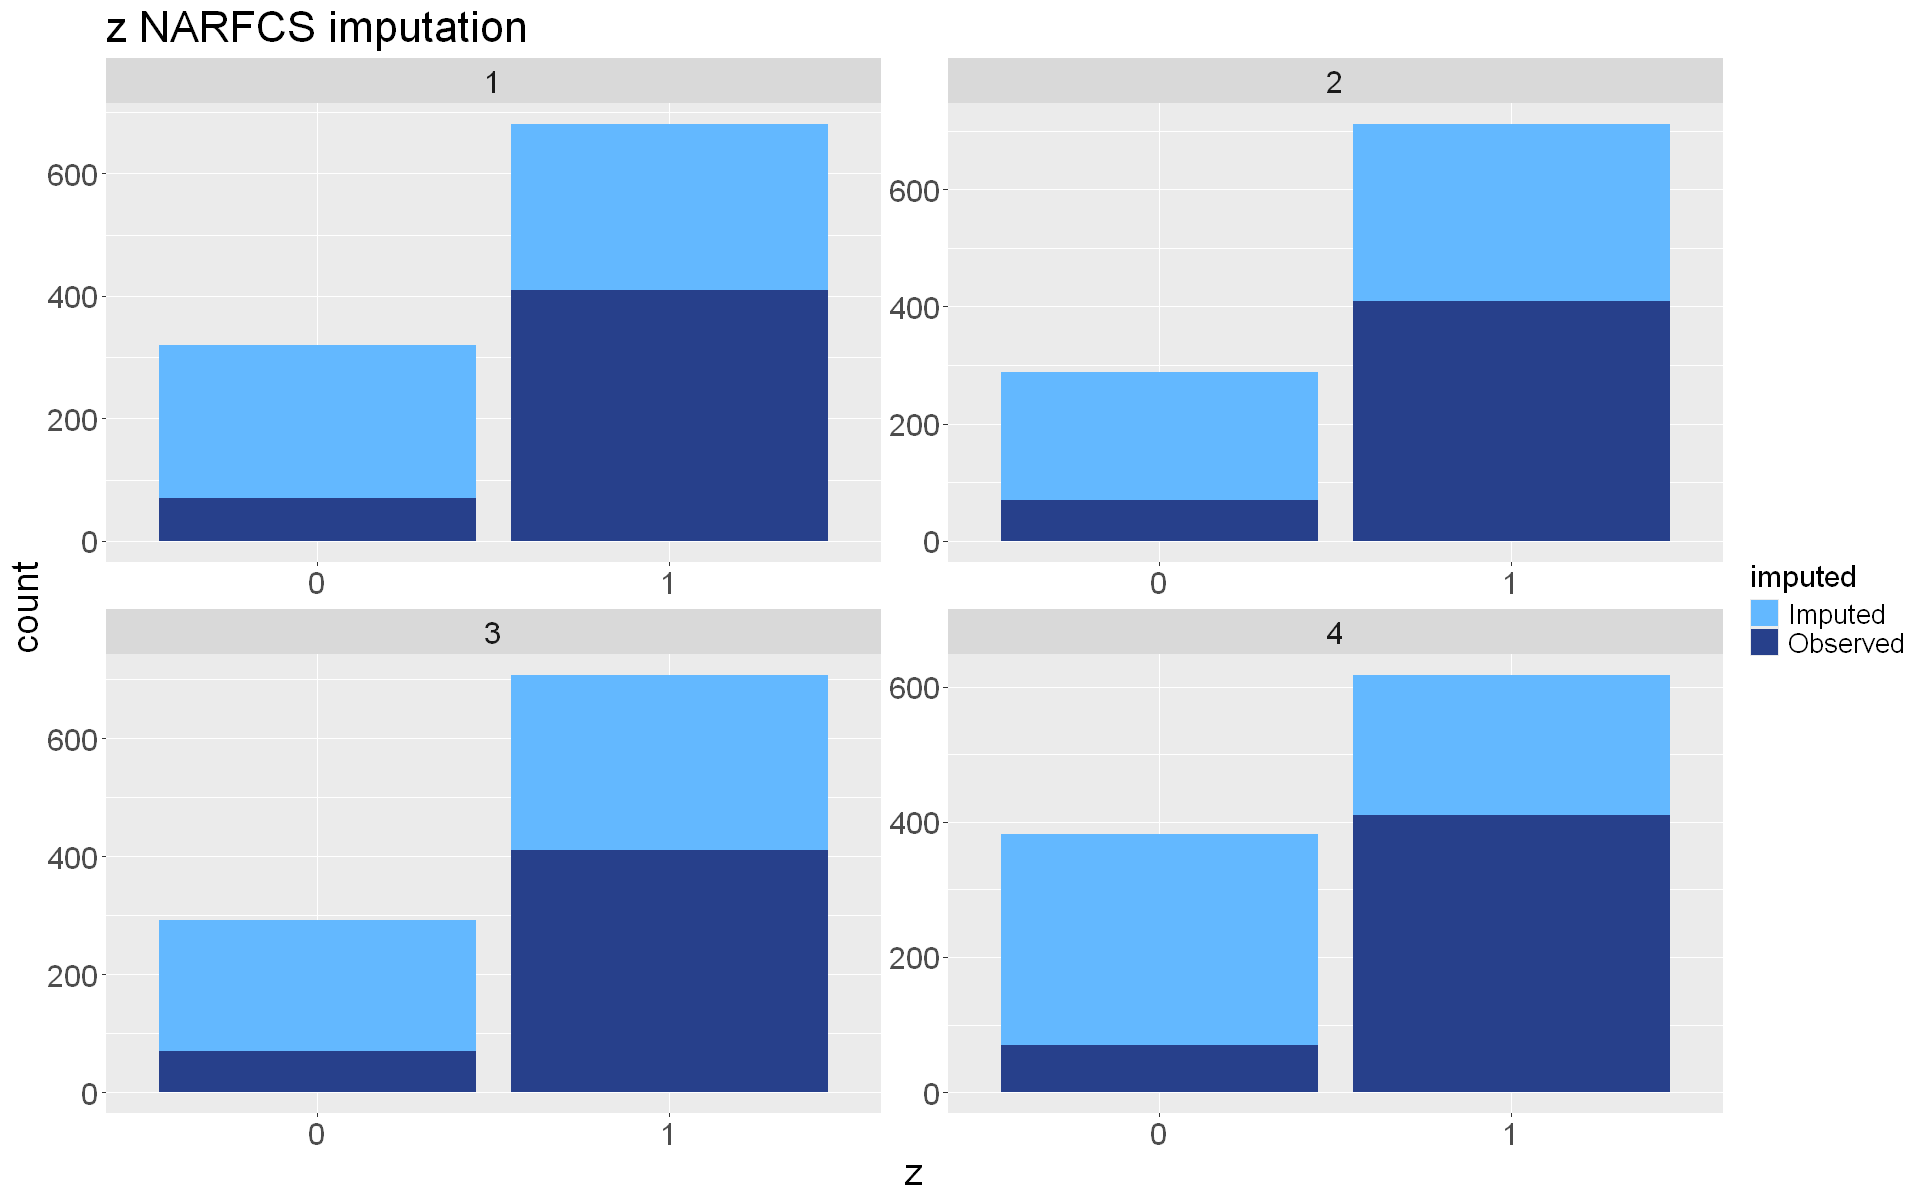

In [53]:
visImpMulCat(train_cat3_narfcs_stack, test_cat3_narfcs_stack, train_cat3_narfcs_imp, test_cat3_narfcs_imp, "z", "NARFCS")